Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!
  
  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 14

In [1]:
num_days_R_prediction=14

In [2]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [3]:
%%R
max_days_prediction<-num_days_R_prediction

In [4]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=10 # =(10/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=15 => 06/02
## DROP_N=45 => 08/03
## DROP_N=75 => 07/04
## DROP_N=145 => 15/06
## DROP_N=175 => 15/07
#
drop_n_dataset_days=235
#

### Load Data from Github - John Hopkins Institute 

In [5]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [6]:
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
242                           NaN                Thailand  15.870032   
243                           NaN             Timor-Leste  -8.874217   
244                           NaN                    Togo   8.619500   
245                           NaN     Trinidad and Tobago  10.691800   
246                           NaN                 Tunisia  33.886917   
247                           NaN                  Turkey  38.963700   
248                           NaN           United States  40.000000   
249                           NaN                  Uganda   1.373333   
250                           NaN                 Ukraine  48.379400   
251                           NaN    United Arab Emirates  23.424076   
252                      Anguilla          United Kingdom  18.220600   
253                       Bermuda          United Kingdom  32.307800   
254        British Virgin Islands          United Kingdom  18.420700   
255                Cayman Islands          United Kingdom  19.313300   
256               Channel Islands          United Kingdom  49.372300   
257   Falkland Islands (Malvinas)          United Kingdom -51.796300   
258                     Gibraltar          United Kingdom  36.140800   
259                   Isle of Man          United Kingdom  54.236100   
260                    Montserrat          United Kingdom  16.742498   
261      Turks and Caicos Islands          United Kingdom  21.694000   
262                           NaN          United Kingdom  55.378100   
263                           NaN                 Uruguay -32.522800   
264                           NaN              Uzbekistan  41.377491   
265                           NaN                 Vanuatu -

## Get Population

In [7]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [8]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
248                           NaN                Thailand  15.870032   
249                           NaN             Timor-Leste  -8.874217   
250                           NaN                    Togo   8.619500   
251                           NaN     Trinidad and Tobago  10.691800   
252                           NaN                 Tunisia  33.886917   
253                           NaN                  Turkey  38.963700   
254                           NaN           United States  40.000000   
255                           NaN                  Uganda   1.373333   
256                           NaN                 Ukraine  48.379400   
257                           NaN    United Arab Emirates  23.424076   
258                      Anguilla          United Kingdom  18.220600   
259                       Bermuda          United Kingdom  32.307800   
260        British Virgin Islands          United Kingdom  18.420700   
261                Cayman Islands          United Kingdom  19.313300   
262               Channel Islands          United Kingdom  49.372300   
263   Falkland Islands (Malvinas)          United Kingdom -51.796300   
264                     Gibraltar          United Kingdom  36.140800   
265                   Isle of Man          United Kingdom  54.236100   
266                    Montserrat          United Kingdom  16.742498   
267      Turks and Caicos Islands          United Kingdom  21.694000   
268                           NaN          United Kingdom  55.378100   
269                           NaN                 Uruguay -32.522800   
270                           NaN              Uzbekistan  41.377491   
271                           NaN                 Vanuatu -

In [9]:
# merge region death
death.iloc[185:195,:]

Province/State Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN     Mauritania  21.007900  -10.940800        0        0   
186            NaN      Mauritius -20.348404   57.552152        0        0   
187            NaN         Mexico  23.634500 -102.552800        0        0   
188            NaN        Moldova  47.411600   28.369900        0        0   
189            NaN         Monaco  43.733300    7.416700        0        0   
190            NaN       Mongolia  46.862500  103.846700        0        0   
191            NaN     Montenegro  42.708678   19.374390        0        0   
192            NaN        Morocco  31.791700   -7.092600        0        0   
193            NaN     Mozambique -18.665695   35.529562        0        0   
194            NaN        Namibia -22.957600   18.490400        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  12/31/20  1/1/21  1/2/21  \
185        0        0        0        0  ...       347     349     353   
186        0        0        0        0  ...        10      10      10   
187        0        0        0        0  ...    125807  126507  126851   
188        0        0        0        0  ...      2985    3004    3020   
189        0        0        0        0  ...         3       3       3   
190        0        0        0        0  ...         1       1       1   
191        0        0        0        0  ...       682     684     684   
192        0        0        0        0  ...      7388    7425    7452   
193        0        0        0        0  ...       166     167     168   
194        0        0        0        0  ...       205     208     213   

     1/3/21  1/4/21  1/5/21  1/6/21  1/7/21   Population           region  
185     358     360     367     373     378     4,649,658  Mauritania_nan  
186      10      10      10      10      10           NaN   Mauritius_nan  
187  127213  127757  128822  129987  131031   128,640,794      Mexico_nan  
188    3037    3054    3070    3088    3106     4,035,942     Moldova_nan  
189       3       3       3       3       3        39,183      Monaco_nan  
190       1       1       1       1       2           NaN    Mongolia_nan  
191     689     692     699     705     712       622 500  Montenegro_nan  
192    7485    7538    7581    7618    7645    36,817,128     Morocco_nan  
193     169     171     171     172     176    31,542,919  Mozambique_nan  
194     215     218     222     235     240     2,540,905     Namibia_nan  

[10 rows x 358 columns]

In [10]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region      Lat      Long  \
175                               NaN        Morocco  31.7917   -7.0926   
176                               NaN     Mozambique -18.6657   35.5296   
177                               NaN        Namibia -22.9576   18.4904   
178                               NaN          Nepal  28.1667   84.2500   
179                             Aruba    Netherlands  12.5211  -69.9683   
180  Bonaire, Sint Eustatius and Saba    Netherlands  12.1784  -68.2385   
181                           Curacao    Netherlands  12.1696  -68.9900   
182                      Sint Maarten    Netherlands  18.0425  -63.0548   
183                               NaN    Netherlands  52.1326    5.2913   
184                               NaN    New Zealand -40.9006  174.8860   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  12/31/20  \
175        0        0        0        0        0        0  ...    407504   
176        0        0        0        0        0        0  ...     16663   
177        0        0        0        0        0        0  ...     20076   
178        0        0        0        0        0        0  ...    252359   
179        0        0        0        0        0        0  ...      5149   
180        0        0        0        0        0        0  ...       180   
181        0        0        0        0        0        0  ...      2925   
182        0        0        0        0        0        0  ...      1331   
183        0        0        0        0        0        0  ...         0   
184        0        0        0        0        0        0  ...      2082   

     1/1/21  1/2/21  1/3/21  1/4/21  1/5/21  1/6/21  1/7/21   Population   \
175  409638  412168  413393  414972  416708  418744  420569    36,817,128   
176   16680   16684   16765   16828   17069   17141   17455    31,542,919   
177   20727   20931   21055   21167   21777   22200   22666     2,540,905   
178  253107  253857  254494  255088  255666  256161  256644    29,300,000   
179    5179    5209    5209    5218    5237    5273    5323       116,600   
180     180     180     180     180     180     180     180           NaN   
181    2950    2950    3170    3280    3320    3463    3479       158,665   
182    1342    1355    1360    1370    1385    1387    1394           NaN   
183       0       0       0       0       0       0       0    17,180,000   
184    2082    2084    2084    2100    2100    2101    2101     4,813,844   

                                           region  
175                                   Morocco_nan  
176                                Mozambique_nan  
177                                   Namibia_nan  
178                                     Nepal_nan  
179                             Netherlands_Aruba  
180  Netherlands_Bonaire, Sint Eustatius and Saba  
181                           Netherlands_Curacao  
182                      Netherlands_Sint Maarten  
183                               Netherlands_nan  
184                               New Zealand_nan  

[10 rows x 358 columns]

In [11]:
confirmed.iloc[185:195,:]

Province/State Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN     Mauritania  21.007900  -10.940800        0        0   
186            NaN      Mauritius -20.348404   57.552152        0        0   
187            NaN         Mexico  23.634500 -102.552800        0        0   
188            NaN        Moldova  47.411600   28.369900        0        0   
189            NaN         Monaco  43.733300    7.416700        0        0   
190            NaN       Mongolia  46.862500  103.846700        0        0   
191            NaN     Montenegro  42.708678   19.374390        0        0   
192            NaN        Morocco  31.791700   -7.092600        0        0   
193            NaN     Mozambique -18.665695   35.529562        0        0   
194            NaN        Namibia -22.957600   18.490400        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  12/31/20   1/1/21   1/2/21  \
185        0        0        0        0  ...     14364    14581    14677   
186        0        0        0        0  ...       527      527      527   
187        0        0        0        0  ...   1426094  1437185  1443544   
188        0        0        0        0  ...    144818   145258   145694   
189        0        0        0        0  ...       875      885      901   
190        0        0        0        0  ...      1220     1242     1263   
191        0        0        0        0  ...     48247    48589    48856   
192        0        0        0        0  ...    439193   440970   442141   
193        0        0        0        0  ...     18642    18794    18968   
194        0        0        0        0  ...     23941    24545    24654   

      1/3/21   1/4/21   1/5/21   1/6/21   1/7/21   Population           region  
185    14794    14875    14981    15111    15214     4,649,658  Mauritania_nan  
186      527      531      531      539      539           NaN   Mauritius_nan  
187  1448755  1455219  1466490  1479835  1493569   128,640,794      Mexico_nan  
188   145873   146309   146921   147871   148294     4,035,942     Moldova_nan  
189      907      917      947      978     1018        39,183      Monaco_nan  
190     1286     1308     1308     1308     1395           NaN    Mongolia_nan  
191    49195    49630    50054    50697    51160       622 500  Montenegro_nan  
192   443146   443802   445439   447081   448678    36,817,128     Morocco_nan  
193    19309    19463    19542    19667    19961    31,542,919  Mozambique_nan  
194    25116    25386    25887    26319    26682     2,540,905     Namibia_nan  

[10 rows x 358 columns]

In [12]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN             Saint Kitts and Nevis  17.357822  -62.782998   
221            NaN                       Saint Lucia  13.909400  -60.978900   
222            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   
223            NaN                             Samoa -13.759000 -172.104600   
224            NaN                        San Marino  43.942400   12.457800   
225            NaN             Sao Tome and Principe   0.186400    6.613100   
226            NaN                      Saudi Arabia  23.885942   45.079162   
227            NaN                           Senegal  14.497400  -14.452400   
228            NaN                            Serbia  44.016500   21.005900   
229            NaN                        Seychelles  -4.679600   55.492000   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  12/31/20  \
220        0        0        0        0        0        0  ...        32   
221        0        0        0        0        0        0  ...       353   
222        0        0        0        0        0        0  ...       121   
223        0        0        0        0        0        0  ...         2   
224        0        0        0        0        0        0  ...      2428   
225        0        0        0        0        0        0  ...      1014   
226        0        0        0        0        0        0  ...    362741   
227        0        0        0        0        0        0  ...     19140   
228        0        0        0        0        0        0  ...    337923   
229        0        0        0        0        0        0  ...       275   

     1/1/21  1/2/21  1/3/21  1/4/21  1/5/21  1/6/21  1/7/21   Population   \
220      32      33      33      33      33      33      33           NaN   
221     353     353     353     360     380     382     383           NaN   
222     121     122     124     124     133     149     149           NaN   
223       2       2       2       2       2       2       2           NaN   
224    2428    2428    2428    2493    2549    2549    2583        33,916   
225    1022    1024    1024    1024    1024    1025    1035           NaN   
226  362878  362979  363061  363155  363259  363377  363485    34,695,447   
227   19364   19511   19697   19803   19964   20156   20376    16,743,927   
228  339997  341904  343870  346585  349238  352120  353907     8,744,671   
229     275     285     297     313     313     313     313           NaN   

                                   region  
220             Saint Kitts and Nevis_nan  
221                       Saint Lucia_nan  
222  Saint Vincent and the Grenadines_nan  
223                             Samoa_nan  
224                        San Marino_nan  
225             Sao Tome and Principe_nan  
226                      Saudi Arabia_nan  
227                           Senegal_nan  
228                            Serbia_nan  
229                        Seychelles_nan  

[10 rows x 358 columns]

## Create Time Series + Plots

In [13]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [14]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [15]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

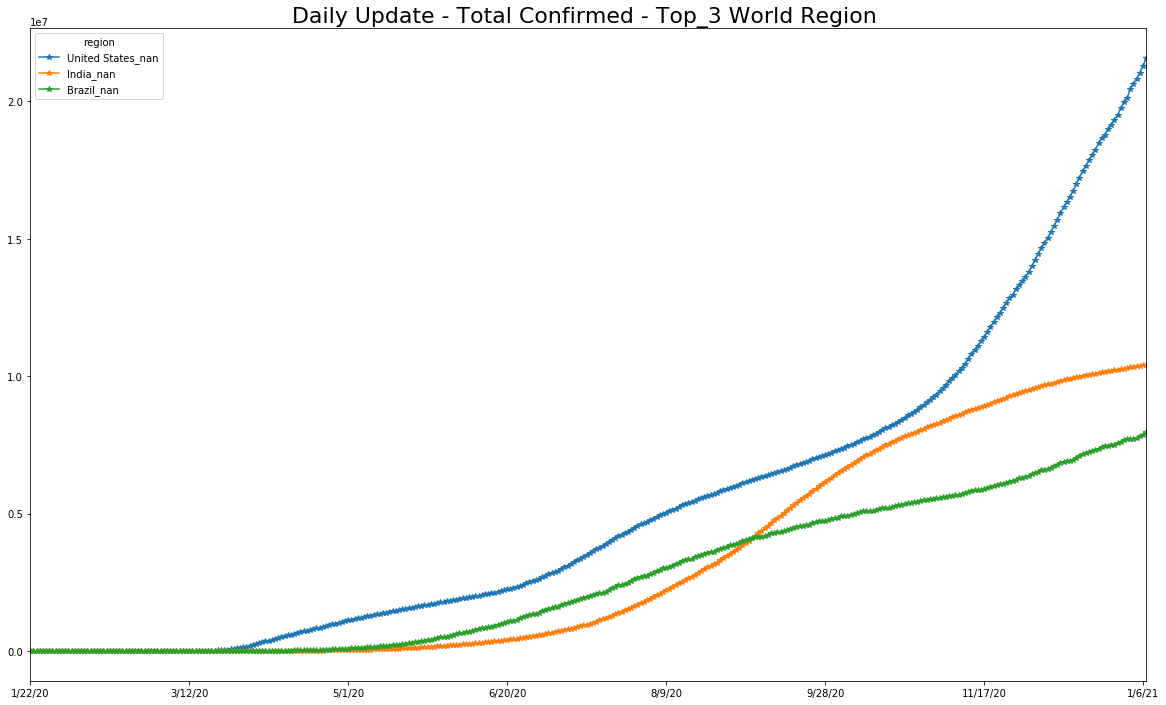

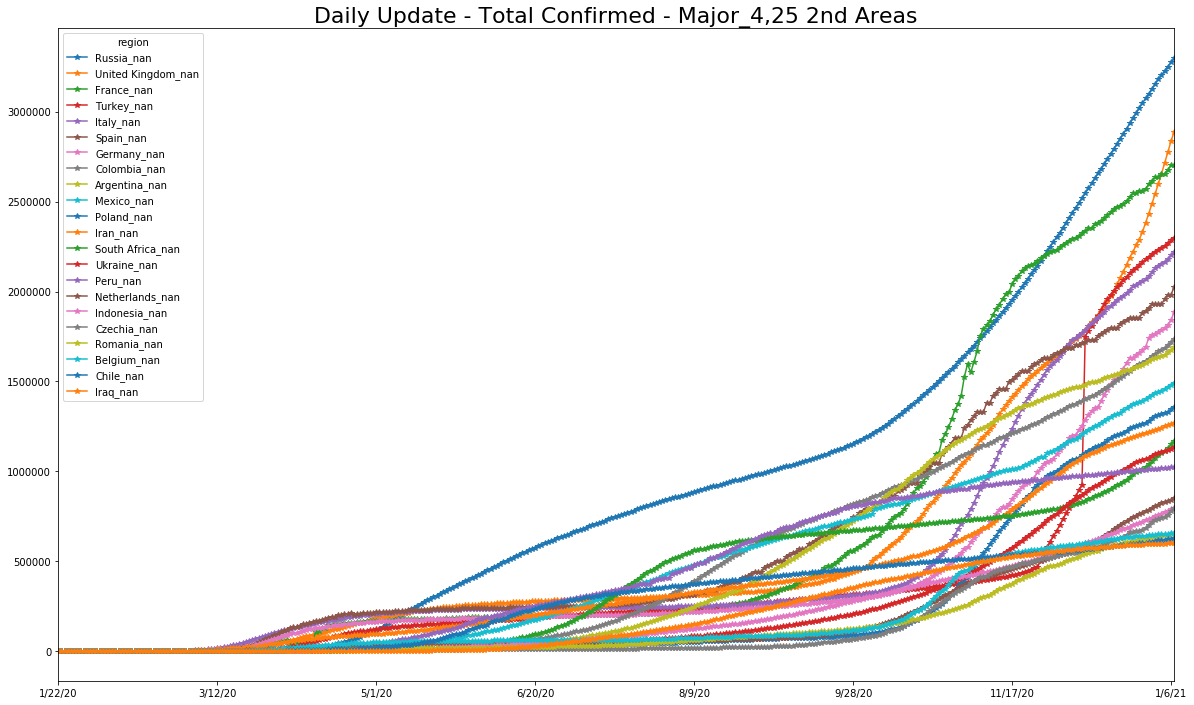

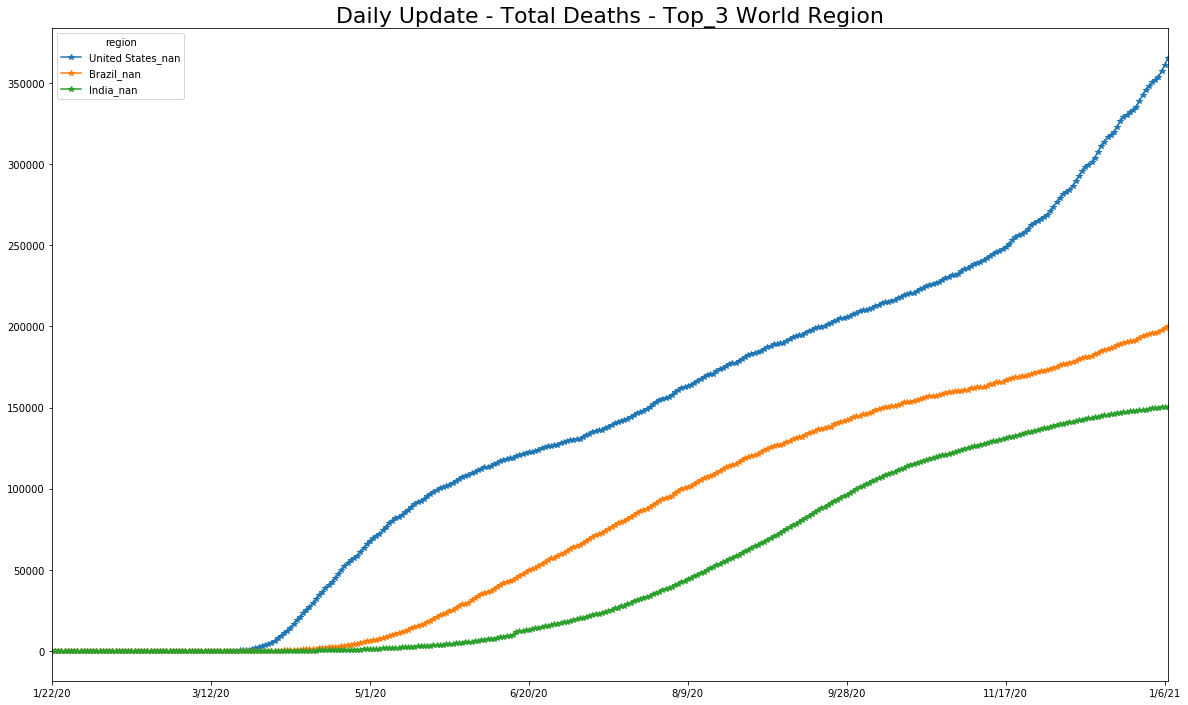

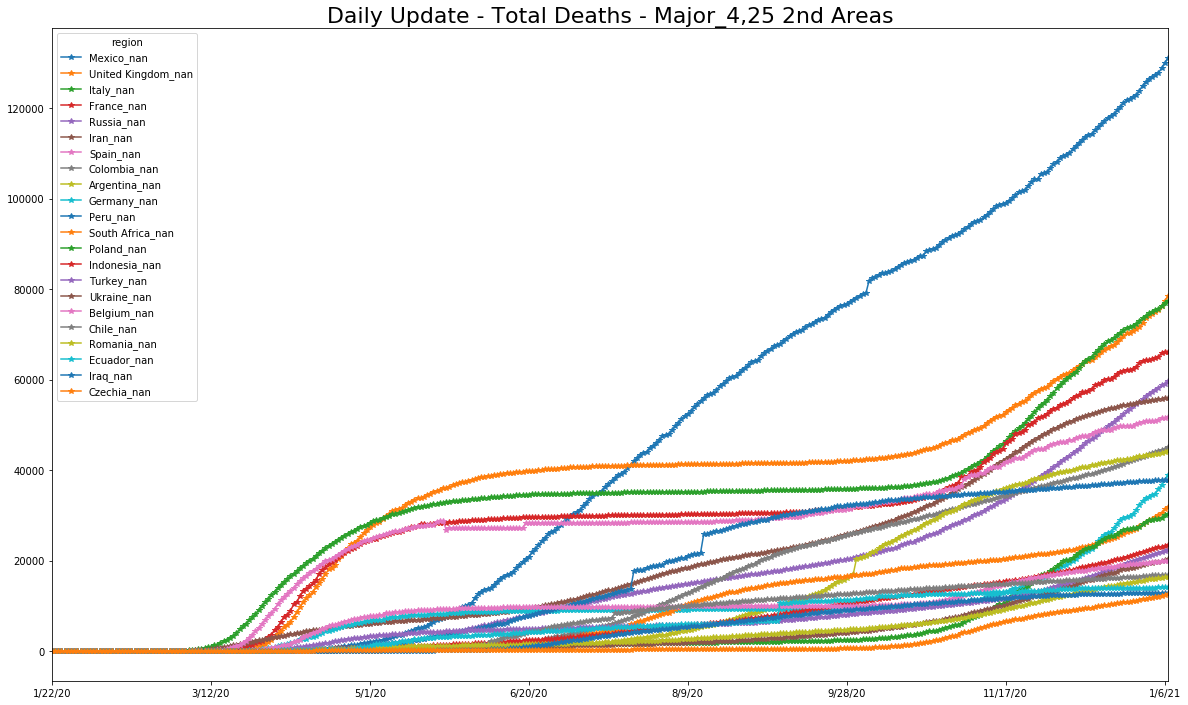

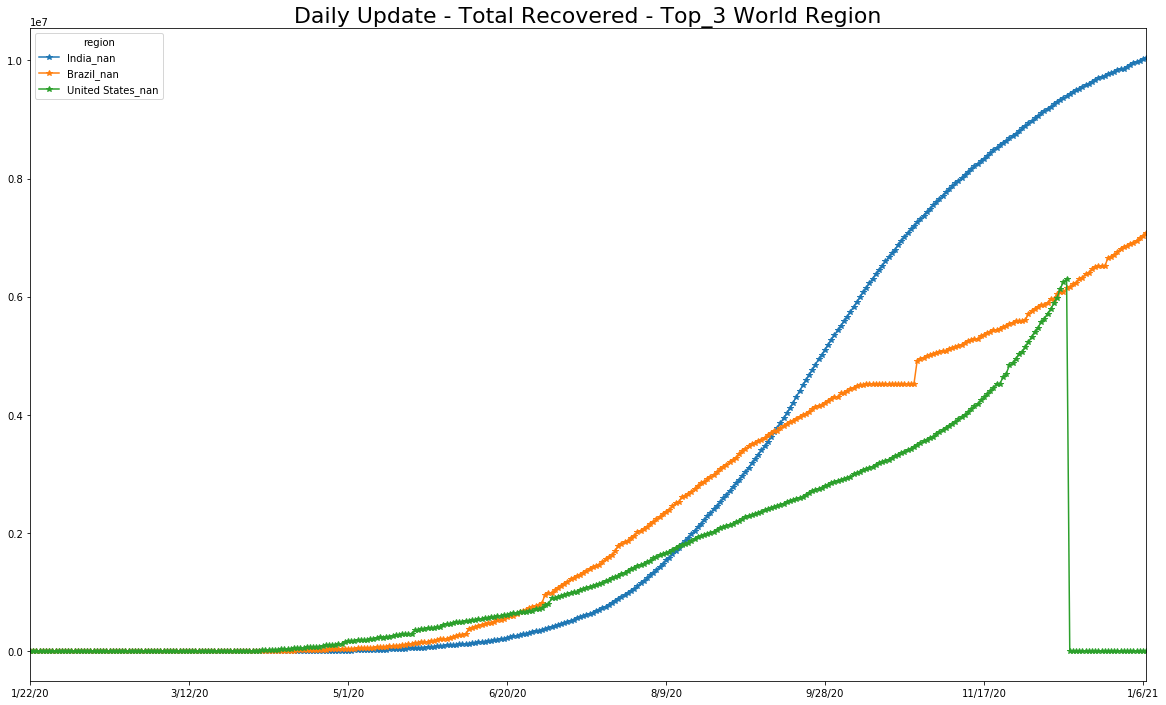

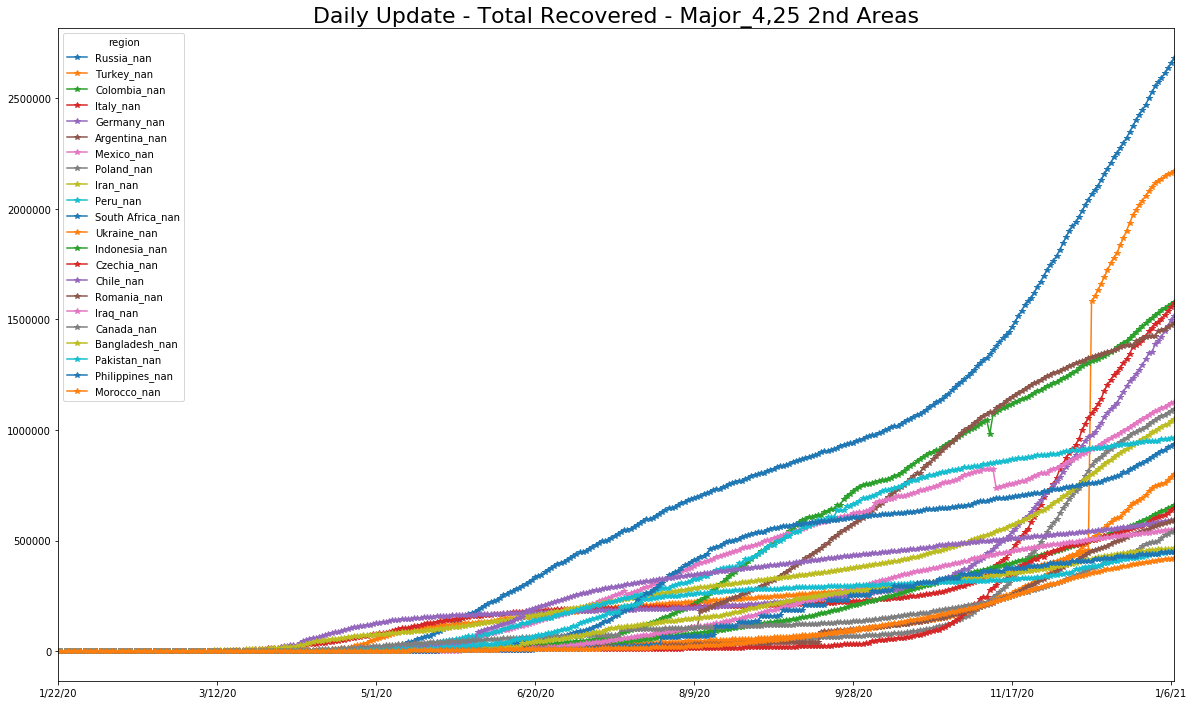

In [16]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [17]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [18]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [19]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2021/01/08


In [20]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [21]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [22]:
# Joao - FIX - Improve Performance 
## DROP_N=15
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [23]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
9/13/20            38716        11353        48254         1344        3388   
9/14/20            38772        11520        48496         1438        3439   
9/15/20            38815        11672        48734         1438        3569   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
9/13/20                       95         555537        45862   
9/14/20                       95         565446        45969   
9/15/20                       95         577338        46119   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
9/13/20                                     113                       4170   
9/14/20                                     113                       4177   
9/15/20                                     113                       4185   

region   ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
9/13/20  ...            6514569         1808           47287            0   
9/14/20  ...            6548677         1812           47836            0   
9/15/20  ...            6588026         1827           48429            0   

region   Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
9/13/20          60540         1063                   30574       2011   
9/14/20          61569         1063                   31362       2013   
9/15/20          62655         1063                   32250       2016   

region   Zambia_nan  Zimbabwe_nan  
9/13/20       13539          7526  
9/14/20       13720          7531  
9/15/20       13819          7576  

[3 rows x 272 columns]

In [24]:
ts[-4:]

region  Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
1/4/21            53011        59623       100645         8249       17684   
1/5/21            53105        60283       100873         8308       17756   
1/6/21            53105        61008       101120         8348       17864   
1/7/21            53207        61705       101382         8348       17974   

region  Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
1/4/21                      160        1648940       160220   
1/5/21                      160        1662730       160544   
1/6/21                      163        1676171       160853   
1/7/21                      163        1690006       161054   

region  Australia_Australian Capital Territory  Australia_New South Wales  \
1/4/21                                     118                       4973   
1/5/21                                     118                       4978   
1/6/21                                     118                       4984   
1/7/21                                     118                       4995   

region  ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
1/4/21  ...           20819087        21426           77258            1   
1/5/21  ...           21049605        22104           77295            1   
1/6/21  ...           21299340        23048           77350            1   
1/7/21  ...           21574043        23807           77412            1   

region  Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
1/4/21         114407         1497                  142228       2101   
1/5/21         114662         1504                  143169       2101   
1/6/21         114908         1505                  144257       2102   
1/7/21         115322         1509                  145252       2104   

region  Zambia_nan  Zimbabwe_nan  
1/4/21       21993         15829  
1/5/21       22645         17194  
1/6/21       23495         17804  
1/7/21       24297         18675  

[4 rows x 272 columns]

In [25]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [26]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [27]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [28]:
p=%R pred_all

In [29]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [30]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [31]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [32]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [33]:
w_in_model.tail(2)

date       region   min   max
8379 2020-05-10  Vietnam_nan  26.9  33.0
8380 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [34]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [35]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [36]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2020-09-14  Afghanistan_nan      38772             0             0   
2     2020-09-15  Afghanistan_nan      38815            56             0   
3     2020-09-16  Afghanistan_nan      38855            43             0   
4     2020-09-17  Afghanistan_nan      38872            40           139   
5     2020-09-18  Afghanistan_nan      38897            17           100   
6     2020-09-19  Afghanistan_nan      38919            25            82   
7     2020-09-20  Afghanistan_nan      39044            22            64   
8     2020-09-21  Afghanistan_nan      39074           125           172   
9     2020-09-22  Afghanistan_nan      39096            30           177   
10    2020-09-23  Afghanistan_nan      39145            22           177   
11    2020-09-24  Afghanistan_nan      39170            49           101   
12    2020-09-25  Afghanistan_nan      39186            25            96   
13    2020-09-26  Afghanistan_nan      39192            16            90   
14    2020-09-27  Afghanistan_nan      39227             6            47   
15    2020-09-28  Afghanistan_nan      39239            35            57   
16    2020-09-29  Afghanistan_nan      39254            12            53   
17    2020-09-30  Afghanistan_nan      39268            15            62   
18    2020-10-01  Afghanistan_nan      39285            14            41   
19    2020-10-02  Afghanistan_nan      39290            17            46   
20    2020-10-03  Afghanistan_nan      39297             5            36   
21    2020-10-04  Afghanistan_nan      39341             7            29   
22    2020-10-05  Afghanistan_nan      39422            44            56   
23    2020-10-06  Afghanistan_nan      39486            81           132   
24    2020-10-07  Afghanistan_nan      39548            64           189   
25    2020-10-08  Afghanistan_nan      39616            62           207   
26    2020-10-09  Afghanistan_nan      39693            68           194   
27    2020-10-10  Afghanistan_nan      39703            77           207   
28    2020-10-11  Afghanistan_nan      39799            10           155   
29    2020-10-12  Afghanistan_nan      39870            96           183   
30    2020-10-13  Afghanistan_nan      39928            71           177   
...          ...              ...        ...           ...           ...   
32774 2020-12-10     Zimbabwe_nan      11081            95           289   
32775 2020-12-11     Zimbabwe_nan      11162            74           242   
32776 2020-12-12     Zimbabwe_nan      11219            81           250   
32777 2020-12-13     Zimbabwe_nan      11246            57           212   
32778 2020-12-14     Zimbabwe_nan      11358            27           165   
32779 2020-12-15     Zimbabwe_nan      11522           112           196   
32780 2020-12-16     Zimbabwe_nan      11749           164           303   
32781 2020-12-17     Zimbabwe_nan      11866           227           503   
32782 2020-12-18     Zimbabwe_nan      12047           117           508   
32783 2020-12-19     Zimbabwe_nan      12151           181           525   
32784 2020-12-20     Zimbabwe_nan      12325           104           402   
32785 2020-12-21     Zimbabwe_nan      12422           174           459   
32786 2020-12-22     Zimbabwe_nan      12544            97           375   
32787 2020-12-23     Zimbabwe_nan      12656           122           393   
32788 2020-12-24     Zimbabwe_nan      12786           112           331   
32789 2020-12-25     Zimbabwe_nan      12880           130           364   
32790 2020-12-26     Zimbabwe_nan      12963            94           336   
32791 2020-12-27     Zimbabwe_nan      13077            83           307   
32792 2020-12-28     Zimbabwe_nan      13148           114           291   
32793 2020-12-29     Zimbabwe_nan      13325            71           268   
32794 2020-12-30     Zimbabwe_nan      13625           177  

In [37]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [38]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
32803 2021-01-08  Zimbabwe_nan          0           871          2846   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
32803          4808         104.892215         117.979721         134.672316   

       last_day  kalman_prediction  population  infected_rate  min  max  
32803     18675            19189.0    14862924       0.000013  NaN  NaN

In [39]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
32803 2021-01-08  Zimbabwe_nan          0           871          2846   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
32803          4808         104.892215         117.979721         134.672316   

       last_day  kalman_prediction  population  infected_rate  min  max  
32803     18675            19189.0    14862924       0.000013  NaN  NaN

In [40]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=ratiod['infected_rate']*1000
ratiod['delta : new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : new_cases per 1M hab']=ratiod['delta : new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
32093  2021-01-06  Zimbabwe_nan      17804          1365          2703   
32094  2021-01-07  Zimbabwe_nan      18675           610          2539   
32095  2021-01-08  Zimbabwe_nan          0           871          2846   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
32093          3869         108.623476         118.653026         129.035722   
32094          4179         103.547807         116.632886         130.671633   
32095          4808         104.892215         117.979721         134.672316   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
32093                17194  ...    14862924       0.000012  NaN  NaN   
32094                17804  ...    14862924       0.000012  NaN  NaN   
32095                18675  ...    14862924       0.000013  NaN  NaN   

       population_percentage : infected_rate confirmed  \
32093                                         0.001157   
32094                                         0.001198   
32095                                         0.001257   

       population_percentage : factor 9/10 infected_rate confirmed  \
32093                                           0.011569             
32094                                           0.011979             
32095                                           0.012565             

       delta : new_cases  delta : new_cases per 1M hab  \
32093              -50.0                     -3.364076   
32094              360.0                     24.221344   
32095              514.0                     34.582697   

       delta : roling 7day AVG  \
32093               552.714286   
32094               597.000000   
32095               686.857143   

       delta : aprox 14-day case notification rate per 100k hab  
32093                                          52.062434         
32094                                          56.233888         
32095                                          64.697902         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse            mae
262  United States_nan  4.061056e+12  2.015206e+06  220819.487179


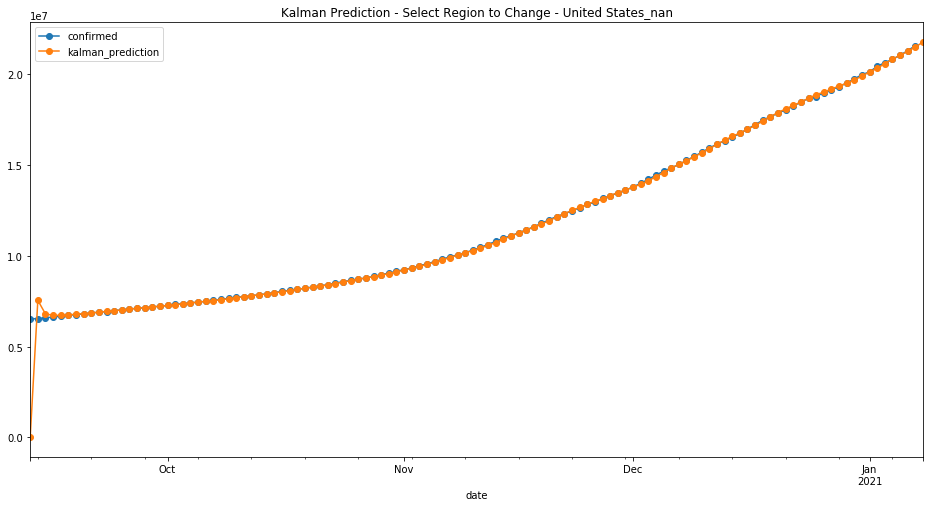

In [41]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse           rmse           mae
212  Russia_nan  9.463442e+10  307627.084801  32179.846154


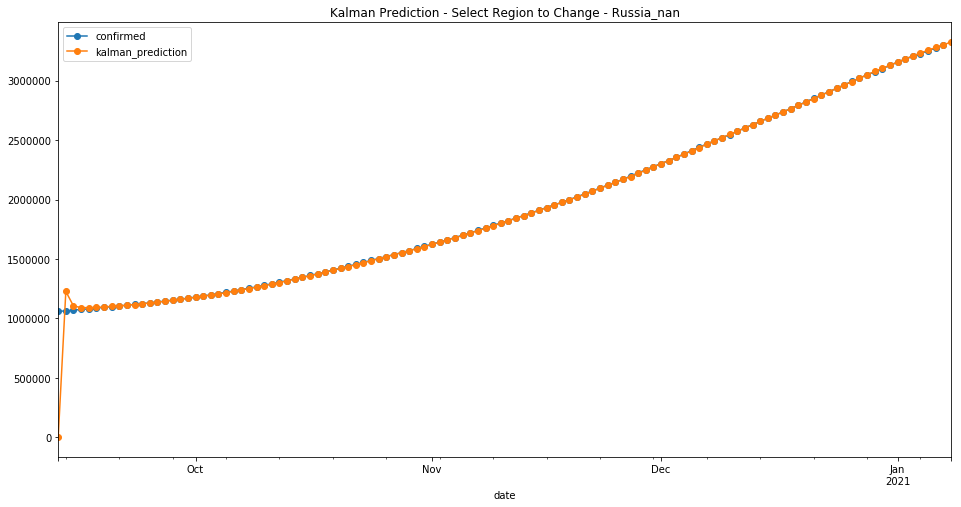

In [42]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse           rmse          mae
30  Brazil_nan  5.473341e+11  739820.290012  91202.65812


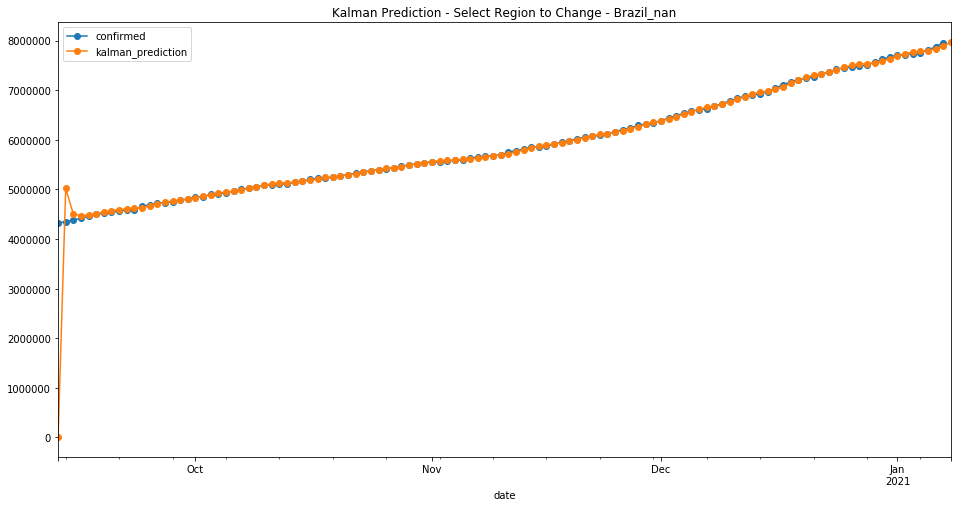

In [43]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse           rmse           mae
261  United Kingdom_nan  7.439355e+10  272751.805081  31048.623932


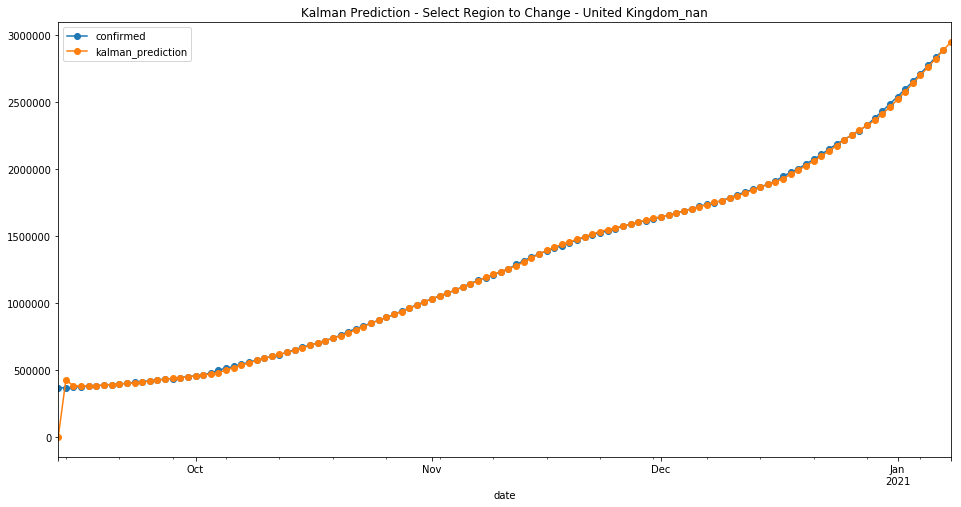

In [44]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [45]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpytd12pq0
  JVM stdout: /tmp/tmpytd12pq0/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpytd12pq0/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O_cluster_uptime:         03 secs
H2O_cluster_timezone:       Etc/GMT
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.30.1.3
H2O_cluster_version_age:    3 months and 10 days !!!
H2O_cluster_name:           H2O_from_python_unknownUser_qe4n05
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.541 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         accepting new members, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.7.7 final
--------------------------  ------------------------------------------------------------------

In [46]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2020-12-29
last_train_date= 2021-01-07
first_bootstrap_date= 2020-12-30
boost_bootstrap_date= 2021-01-04
first_test_date= 2020-12-29
last_test_date= 2021-01-08
first_valid_date= 2021-01-06


In [47]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [48]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [49]:
pred2.iloc[:25]

0  confirmed       date           region
0    51713.0      51405 2020-12-30  Afghanistan_nan
1    51782.0      51526 2020-12-31  Afghanistan_nan
2    51855.0      51526 2021-01-01  Afghanistan_nan
3    51885.0      51526 2021-01-02  Afghanistan_nan
4    51868.0      51526 2021-01-03  Afghanistan_nan
5    51837.0      53011 2021-01-04  Afghanistan_nan
6    52693.0      53105 2021-01-05  Afghanistan_nan
7    53370.0      53105 2021-01-06  Afghanistan_nan
8    53650.0      53207 2021-01-07  Afghanistan_nan
9    53714.0          0 2021-01-08  Afghanistan_nan
10   57663.0      57727 2020-12-30      Albania_nan
11   58220.0      58316 2020-12-31      Albania_nan
12   58833.0      58316 2021-01-01      Albania_nan
13   59069.0      58991 2021-01-02      Albania_nan
14   59521.0      59438 2021-01-03      Albania_nan
15   59978.0      59623 2021-01-04      Albania_nan
16   60281.0      60283 2021-01-05      Albania_nan
17   60766.0      61008 2021-01-06      Albania_nan
18   61438.0      61705 2021-01-07      Albania_nan
19   62196.0          0 2021-01-08      Albania_nan
20   99571.0      99311 2020-12-30      Algeria_nan
21   99890.0      99610 2020-12-31      Algeria_nan
22  100178.0      99897 2021-01-01      Algeria_nan
23  100446.0     100159 2021-01-02      Algeria_nan
24  100689.0     100408 2021-01-03      Algeria_nan

In [50]:
pred2.iloc[175:195]

0  confirmed       date          region
175  221351.0     220599 2021-01-04  Azerbaijan_nan
176  221531.0     221401 2021-01-05  Azerbaijan_nan
177  222261.0     222200 2021-01-06  Azerbaijan_nan
178  222960.0     222885 2021-01-07  Azerbaijan_nan
179  223658.0          0 2021-01-08  Azerbaijan_nan
180    8078.0       7857 2020-12-30     Bahamas_nan
181    8085.0       7871 2020-12-31     Bahamas_nan
182    8093.0       7887 2021-01-01     Bahamas_nan
183    8105.0       7887 2021-01-02     Bahamas_nan
184    8157.0       7914 2021-01-03     Bahamas_nan
185    8095.0       7924 2021-01-04     Bahamas_nan
186    8160.0       7928 2021-01-05     Bahamas_nan
187    8188.0       7945 2021-01-06     Bahamas_nan
188    8158.0       7959 2021-01-07     Bahamas_nan
189    8182.0          0 2021-01-08     Bahamas_nan
190   92626.0      92425 2020-12-30     Bahrain_nan
191   92877.0      92675 2020-12-31     Bahrain_nan
192   93134.0      92913 2021-01-01     Bahrain_nan
193   93383.0      93184 2021-01-02     Bahrain_nan
194   93654.0      93478 2021-01-03     Bahrain_nan

In [51]:
pred2.iloc[220:240]

0  confirmed       date       region
220  192396.0     192361 2020-12-30  Belarus_nan
221  194336.0     194284 2020-12-31  Belarus_nan
222  196246.0     196223 2021-01-01  Belarus_nan
223  198195.0     198125 2021-01-02  Belarus_nan
224  200111.0     199962 2021-01-03  Belarus_nan
225  201965.0     201831 2021-01-04  Belarus_nan
226  203840.0     203104 2021-01-05  Belarus_nan
227  205128.0     204958 2021-01-06  Belarus_nan
228  206960.0     206796 2021-01-07  Belarus_nan
229  208690.0          0 2021-01-08  Belarus_nan
230  643383.0     644242 2020-12-30  Belgium_nan
231  646008.0     646496 2020-12-31  Belgium_nan
232  648126.0     648289 2021-01-01  Belgium_nan
233  650084.0     649169 2021-01-02  Belgium_nan
234  651041.0     650011 2021-01-03  Belgium_nan
235  651955.0     650887 2021-01-04  Belgium_nan
236  652699.0     652735 2021-01-05  Belgium_nan
237  654428.0     655732 2021-01-06  Belgium_nan
238  657339.0     658655 2021-01-07  Belgium_nan
239  660266.0          0 2021-01-08  Belgium_nan

In [52]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [53]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  9380535736.845945
# MSE on the validation data =  6024506657024.079
# R^2 on the training data =  0.9987417519923114
# R^2 on the validation data =  0.4441154529230533


In [54]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1610096090825_1


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0              500.0                     500.0           15368637.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0       20.0       23.0      22.778      2164.0      2505.0     2403.434



ModelMetricsRegression: drf
** Reported on train data. **

MSE: 9380535736.845945
RMSE: 96853.16585866435
MAE: 8795.24238100838
RMSLE: 0.2656544717783206
Mean Residual Deviance: 9380535736.845945

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 6024506657024.079
RMSE: 2454487.0456011943
MAE: 626824.2753028341
RMSLE: 7.374479318540028
Mean Residual Deviance: 6024506657024.079

Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2021-01-08 08:55:00   0.089 sec              0.0            NaN   
1     2021-01-08 08:55:01   0.516 sec              1.0   78230.427676   
2     2021-01-08 08:55:01   0.702 sec              2.0   60933.245914   
3     2021-01-08 08:55:01   0.857 sec              3.0   59028.624768   
4     2021-01-08 08:55:01   1.215 sec              4.0   56772.398033   
5     2021-01-08 08:55:01   1.316 sec              5.0   62215.055678   
6     2021-01-08 08:55:01   1.395 sec              6.0   80539.120391   
7     2021-01-08 08:55:02   1.472 sec              7.0   67215.460192   
8     2021-01-08 08:55:02   1.558 sec              8.0   64273.601994   
9     2021-01-08 08:55:02   1.627 sec              9.0   62951.208401   
10    2021-01-08 08:55:02   1.686 sec             10.0   61669.583403   
11    2021-01-08 08:55:02   1.763 sec             11.0   61201.210152   
12    2021-01-08 08:55:02   1.868 sec             12.0   58442.668302   
13    2021-01-08 08:55:02   1.938 sec             13.0   68877.066238   
14    2021-01-08 08:55:02   2.005 sec             14.0   73617.774709   
15    2021-01-08 08:55:02   2.078 sec             15.0   77207.188421   
16    2021-01-08 08:55:02   2.156 sec             16.0   78477.890202   
17    2021-01-08 08:55:02   2.240 sec             17.0   83028.003770   
18    2021-01-08 08:55:02   2.345 sec             18.0   82713.017396   
19    2021-01-08 08:55:02   2.410 sec             19.0   82213.297580   

    training_mae  training_deviance  validation_rmse  validation_mae  \
0            NaN                NaN              NaN             NaN   
1   20896.790997       6.120000e+09     2.473695e+06   619949.577351   
2   16998.435851       3.712860e+09     2.461708e+06   617583.433488   
3   15988.024735       3.484379e+09     2.464286e+06   616152.095485   
4   14889.829541       3.223105e+09     2.457258e+06   614007.952977   
5   15137.057047       3.870713e+09     2.456633e+06   614292.405168   
6   15594.701015       6.486550e+09     2.457722e+06   614360.305615   
7   14583.512383       4.517918e+09     2.456552e+06   613554.556086   
8   13565.448122       4.131096e+09     2.455842e+06   613486.665691   
9   13109.956781       3.962855e+09     2.457978e+06   613401.616875   
10  12636.219193       3.803138e+09     2.459680e+06   613465.691935   
11  12285.721178       3.745588e+09     2.459144e+06   613078.390965   
12  11776.995152       3.415545e+09     2.456871e+06   612417.901914   
13  11895.431415       4.744050e+09     2.456215e+06   612269.950216   
14  11723.157735       5.419577e+09     2.457704e+06   612476.218995   
15  11830.668642       5.960950e+09     2.457589e+06   612611.753682   
16  11666.565229       6.158779e+09     2.456464e+06   612817.752101   
17  11322.672702       6.893649e+09     2.456952e+06   612417.074721   
18  11480.055111       6.841443e+09     2.457438e+06   612428.362553   
19  11337.630653       6.759026e+09     2.458305e+06   612636.278251   

    validation_deviance  
0                   NaN  
1          6.119167e+12  
2          6.060004e+12  
3          6.072705e+12  
4          6.038116e+12  
5          6.035045e+12  
6          6.040397e+12  
7          6.034649e+12  
8          6.031162e+12  
9          6.041658e+12  
10         6.050025e+12  
11         6.047388e+12  
12         6.036215e+12  
13         6.032992e+12  
14         6.040311e+12  
15         6.039741e+12  
16         6.034216e+12  
17         6.036611e+12  
18         6.039000e+12  
19         6.043265e+12


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0   kalman_prediction         5.173330e+18           1.000000    0.323721
1            last_day         4.426781e+18           0.855693    0.277005
2              region         3.053945e+18           0.590325    0.191100
3        7_day_change         1.265974e+18           0.244712    0.079218
4        3_day_change         7.484611e+17           0.144677    0.046835
5        1_day_change         5.869826e+17           0.113463    0.036730
6       infected_rate         5.426439e+17           0.104893    0.033956
7                 max         6.423908e+16           0.012417    0.004020
8                 min         5.930389e+16           0.011463    0.003711
9   7_day_change_rate         3.348899e+16           0.006473    0.002096
10  1_day_change_rate         1.415189e+16           0.002736    0.000886
11  3_day_change_rate         1.154664e+16           0.002232    0.000723

In [55]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0   kalman_prediction         5.173330e+18           1.000000    0.323721
1            last_day         4.426781e+18           0.855693    0.277005
2              region         3.053945e+18           0.590325    0.191100
3        7_day_change         1.265974e+18           0.244712    0.079218
4        3_day_change         7.484611e+17           0.144677    0.046835
5        1_day_change         5.869826e+17           0.113463    0.036730
6       infected_rate         5.426439e+17           0.104893    0.033956
7                 max         6.423908e+16           0.012417    0.004020
8                 min         5.930389e+16           0.011463    0.003711
9   7_day_change_rate         3.348899e+16           0.006473    0.002096
10  1_day_change_rate         1.415189e+16           0.002736    0.000886
11  3_day_change_rate         1.154664e+16           0.002232    0.000723

In [56]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


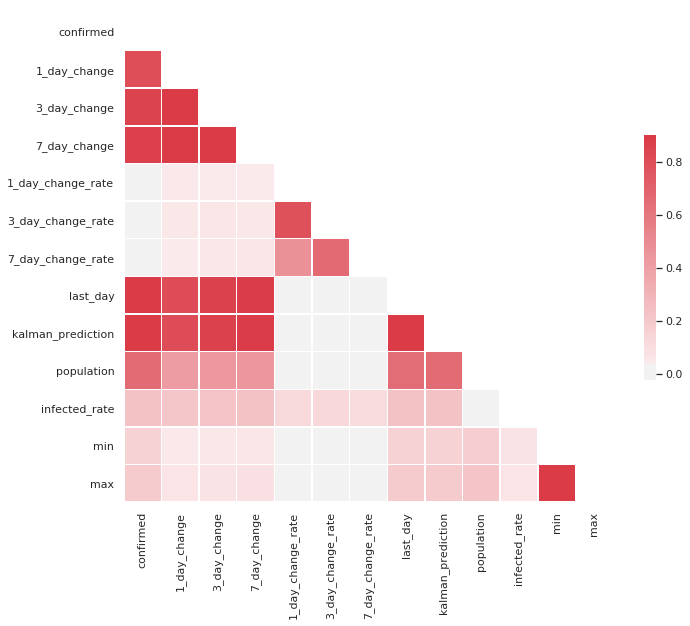

In [57]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [58]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.795191
3_day_change         0.850425
7_day_change         0.869495
1_day_change_rate    0.026352
3_day_change_rate    0.027164
7_day_change_rate    0.022142
last_day             0.986604
kalman_prediction    0.988011
population           0.656986
infected_rate        0.234191
min                  0.160867
max                  0.183193
Name: confirmed, dtype: float64


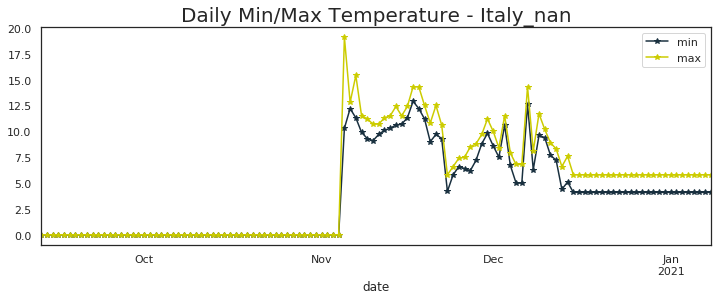

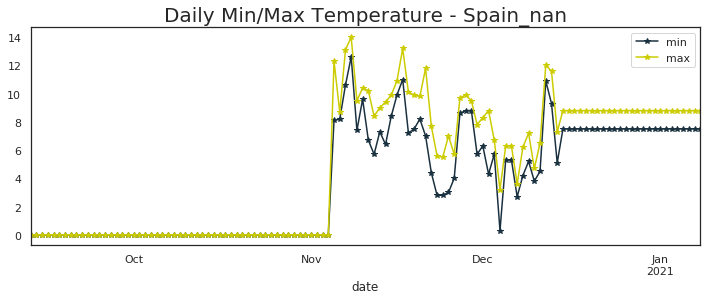

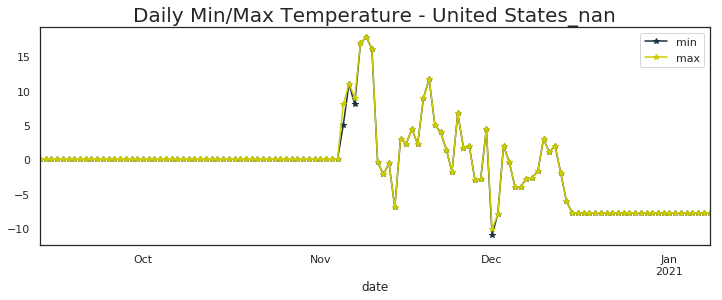

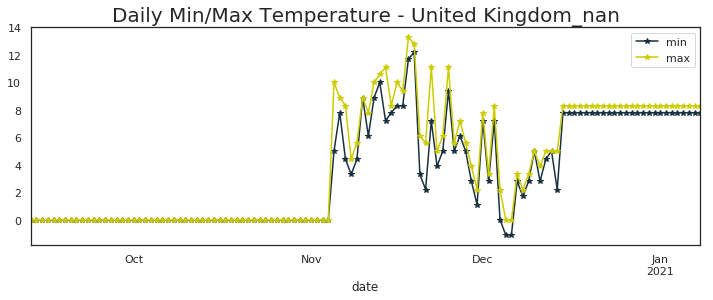

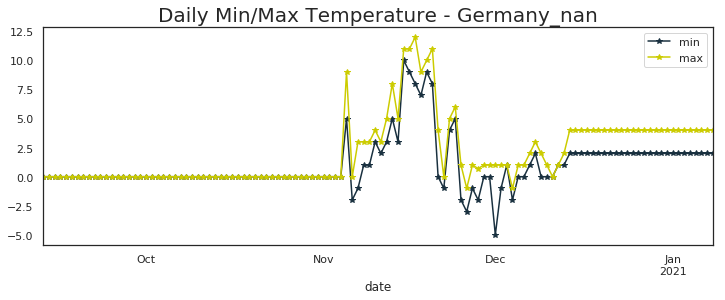

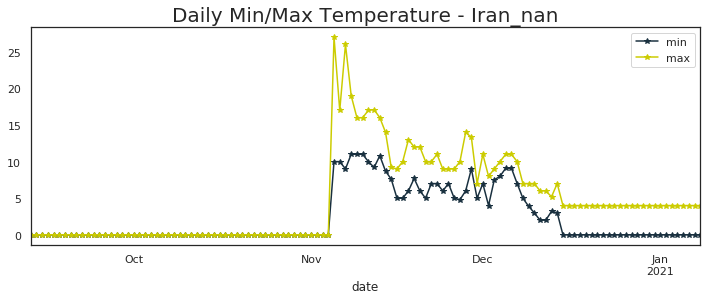

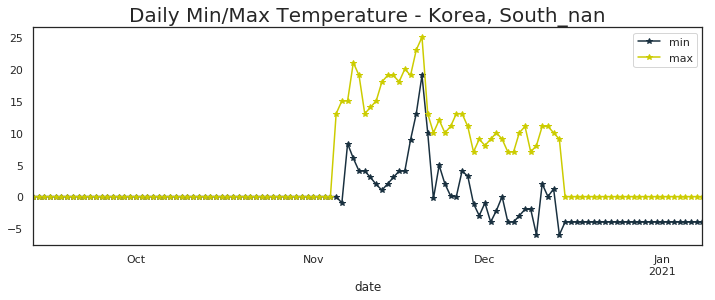

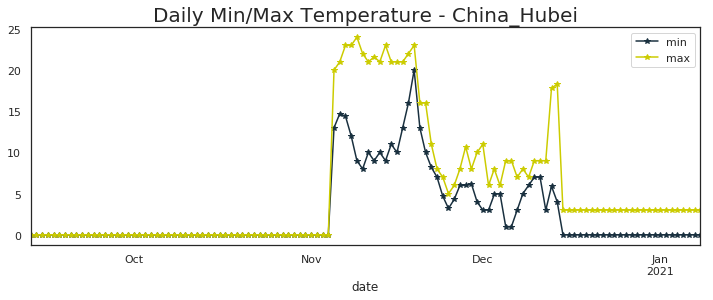

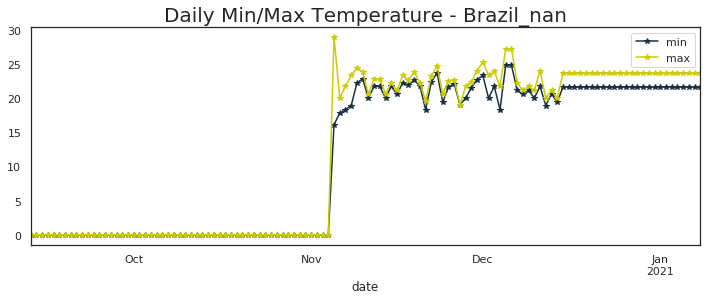

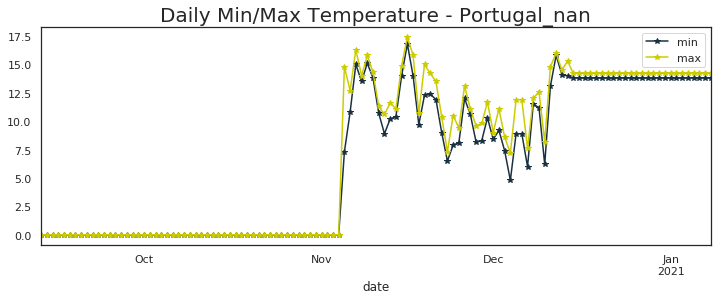

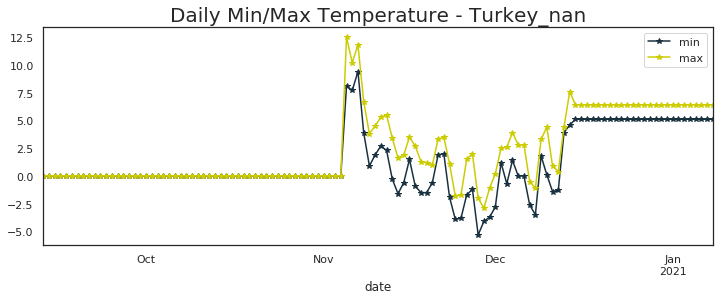

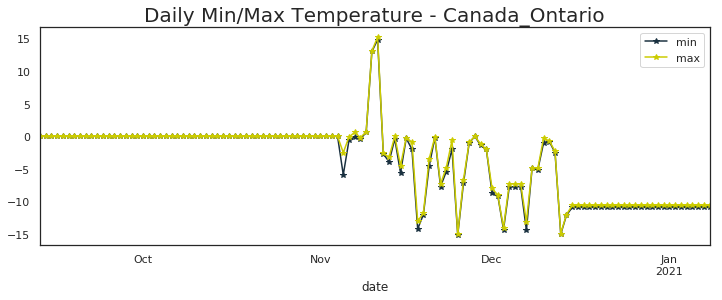

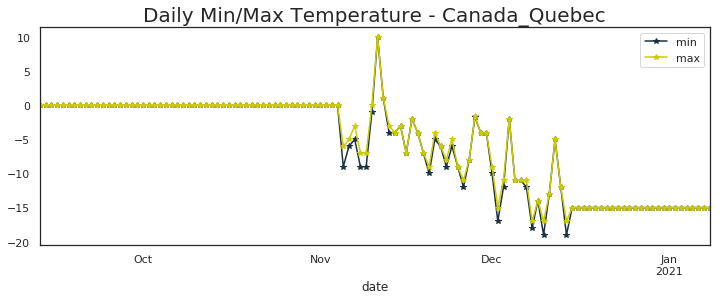

In [59]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [60]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                             min   max
region                                
United States_nan           17.8  17.8
India_nan                   22.0  31.0
Brazil_nan                  24.8  28.9
Russia_nan                   0.0   4.0
United Kingdom_nan          12.2  13.3
France_nan                  12.1  13.3
Turkey_nan                   9.4  12.5
Italy_nan                   12.9  19.1
Spain_nan                   12.6  14.0
Germany_nan                 10.0  12.0
Colombia_nan                 0.0   0.0
Argentina_nan                0.0   0.0
Mexico_nan                  15.1  15.1
Poland_nan                   8.9  10.6
Iran_nan                    11.0  27.0
South Africa_nan             0.0   0.0
Ukraine_nan                  0.0   0.0
Peru_nan                    24.6  29.9
Netherlands_nan             14.4  16.1
Indonesia_nan                0.0   0.0
Czechia_nan                  0.0   0.0
Romania_nan                  0.0   0.0
Belgium_nan                 

### Kalman X Days Ahead Prediction

In [61]:
%%R

#install.packages('reshape')

NULL


In [62]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [63]:
all_new=%R all_new

In [64]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

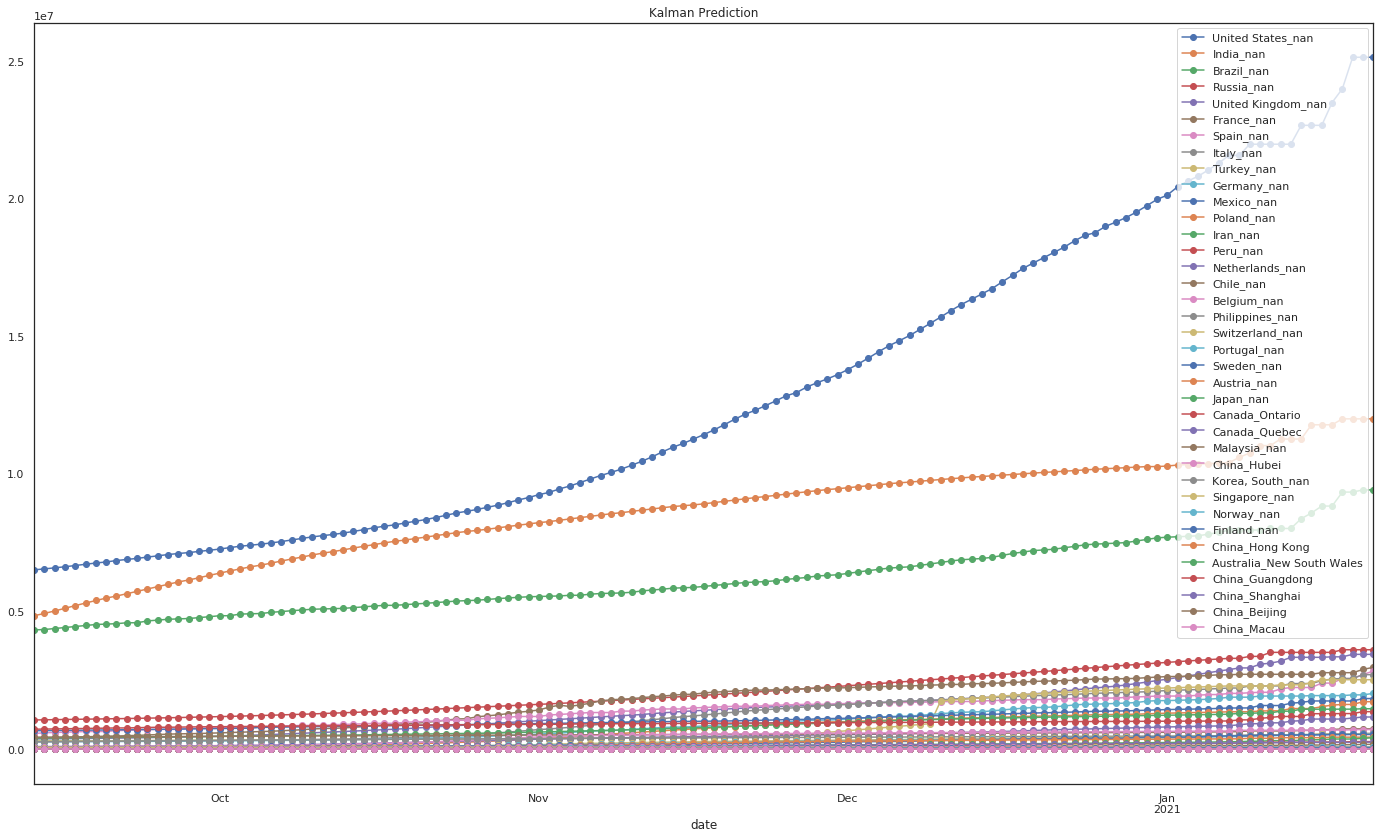

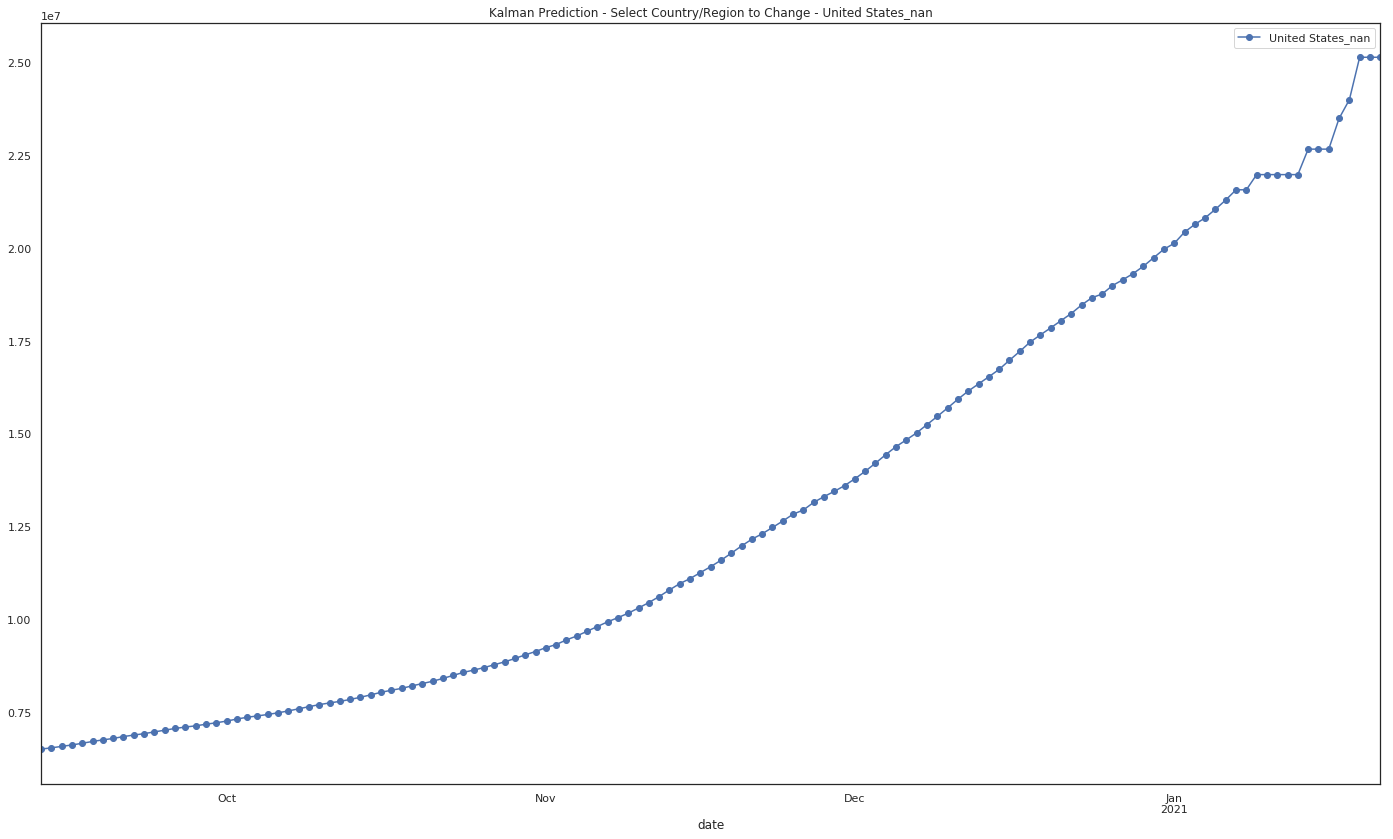

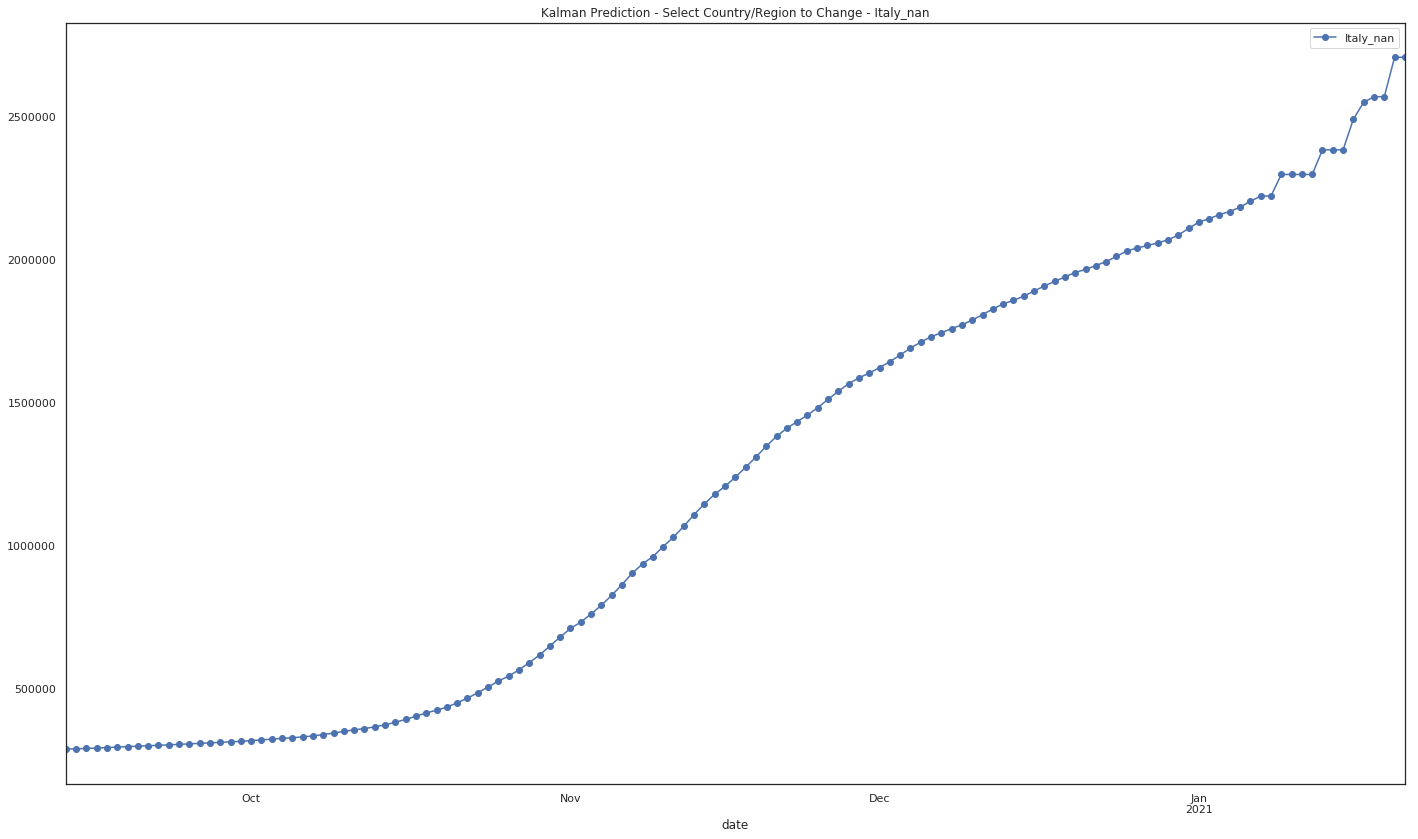

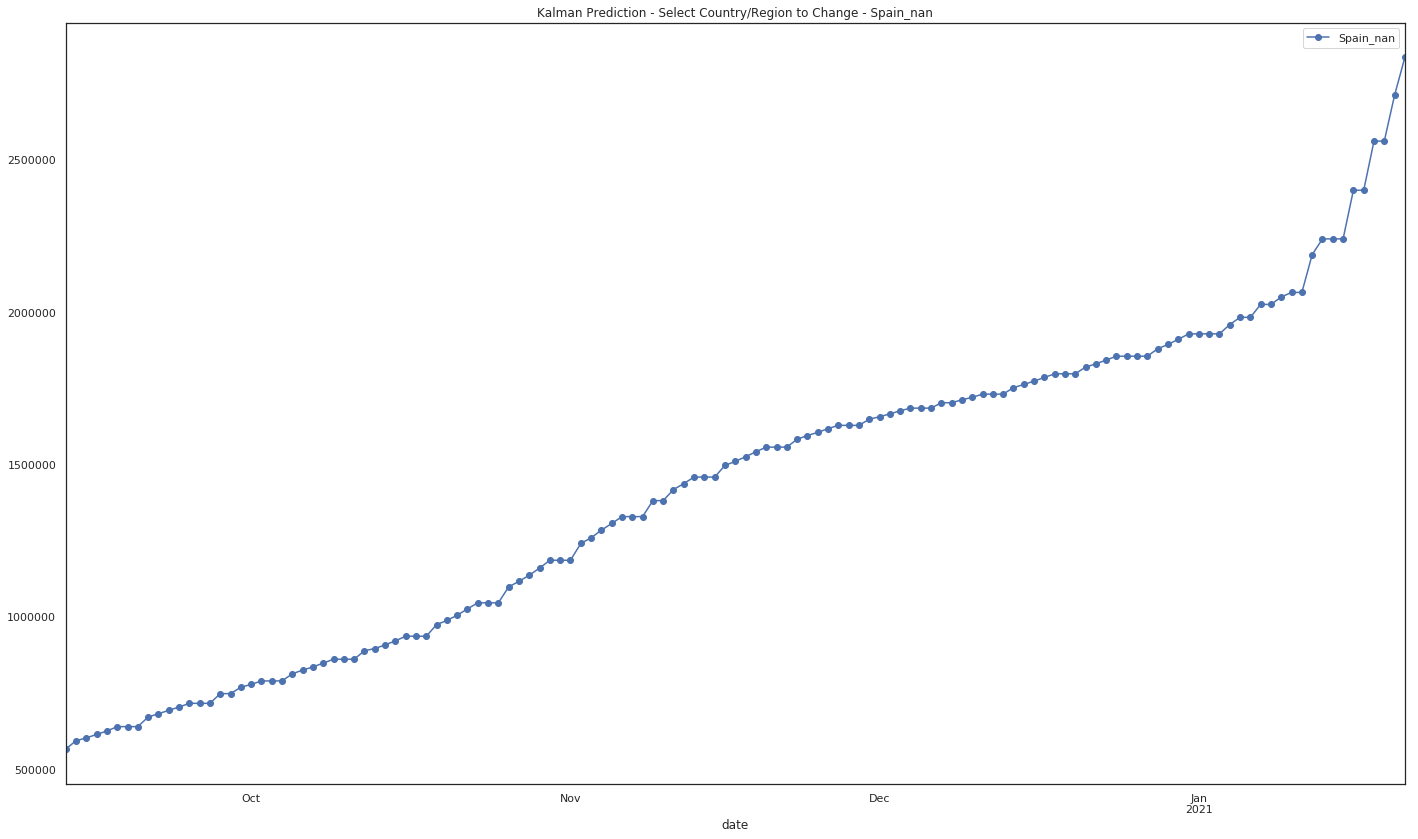

In [65]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


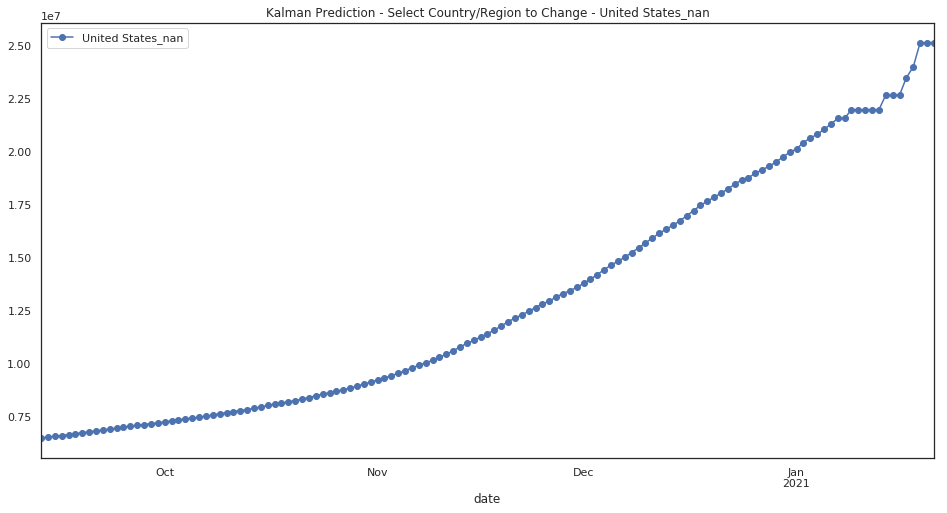

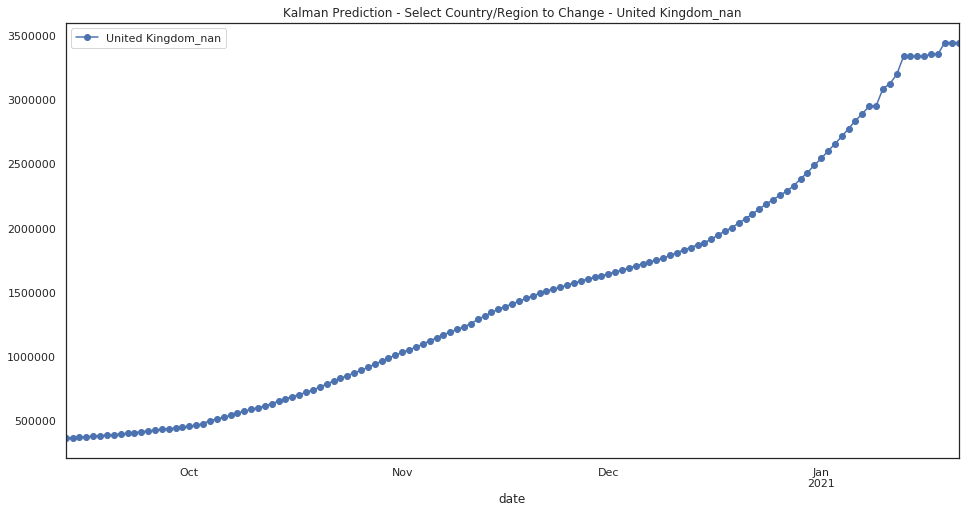

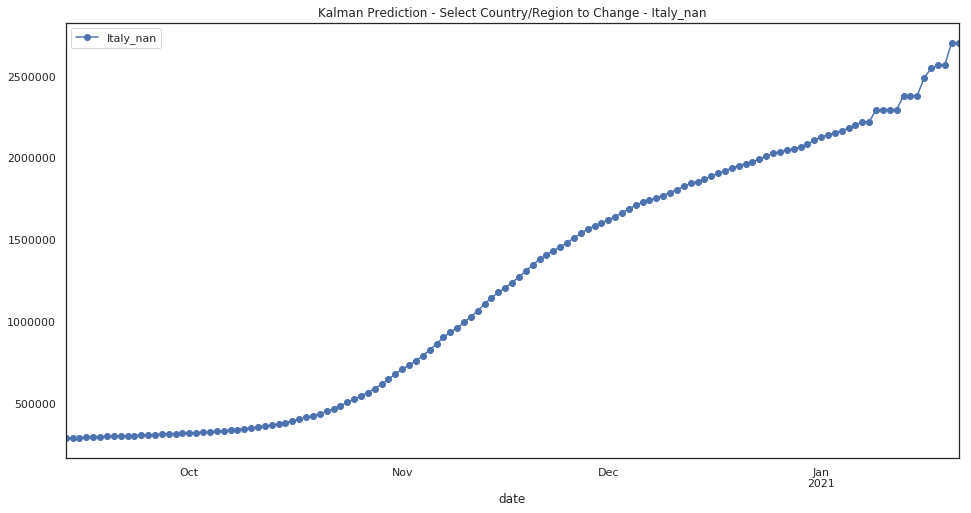

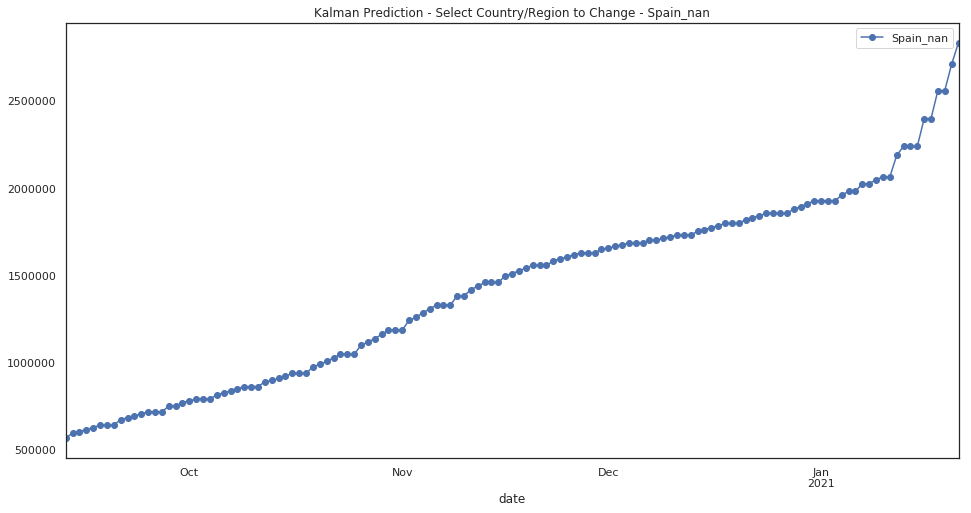

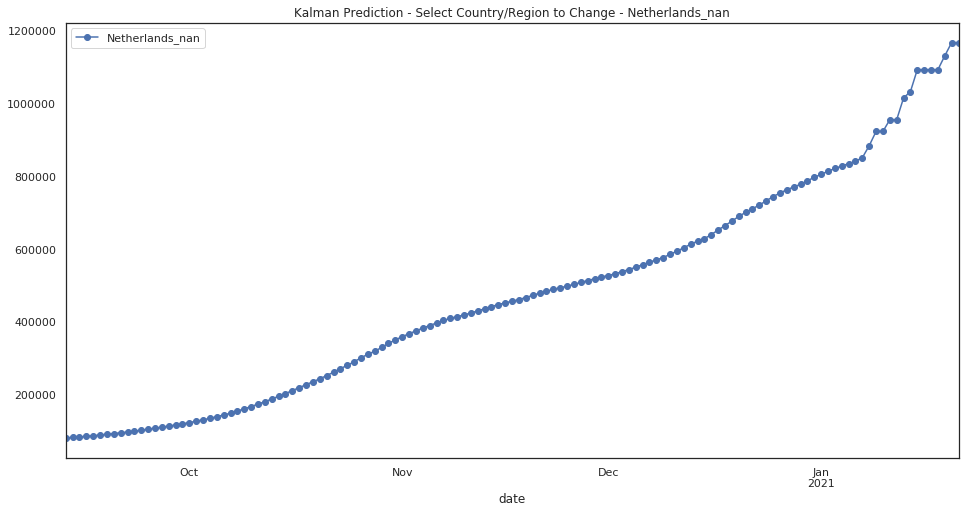

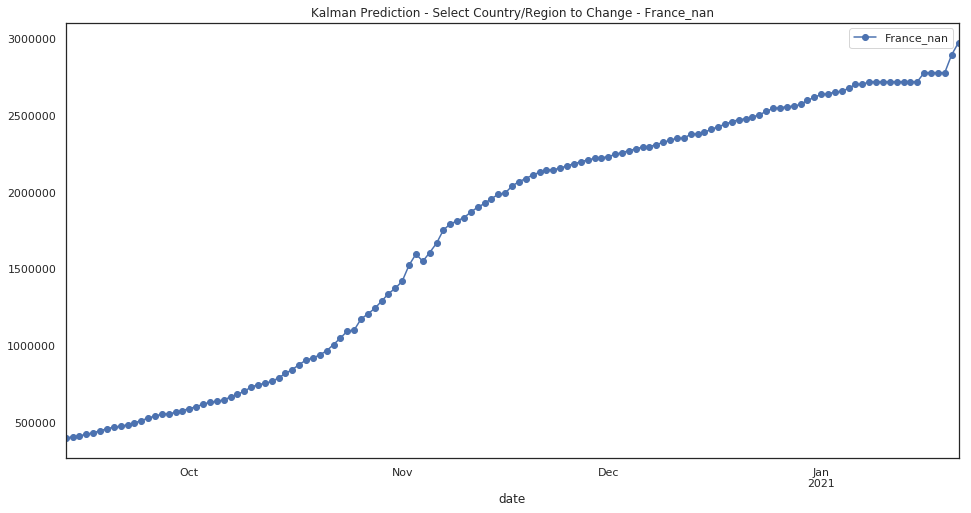

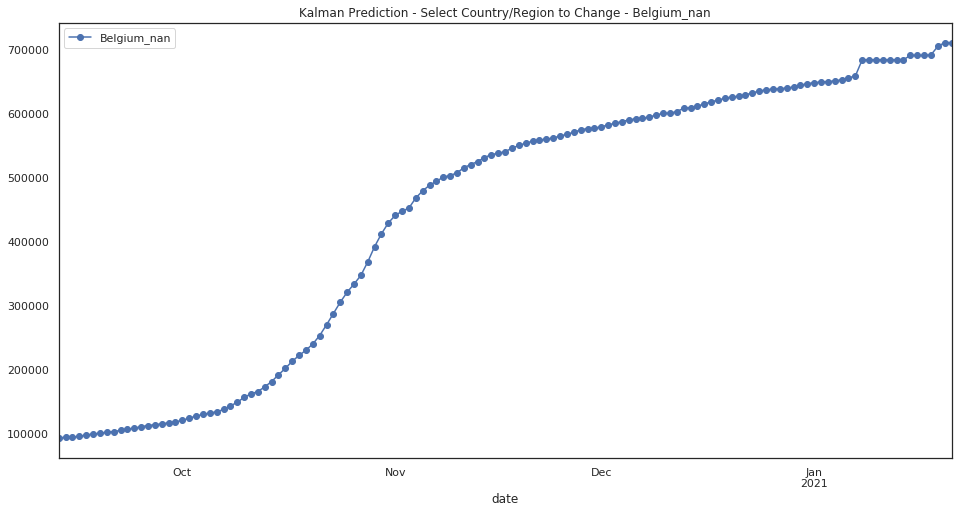

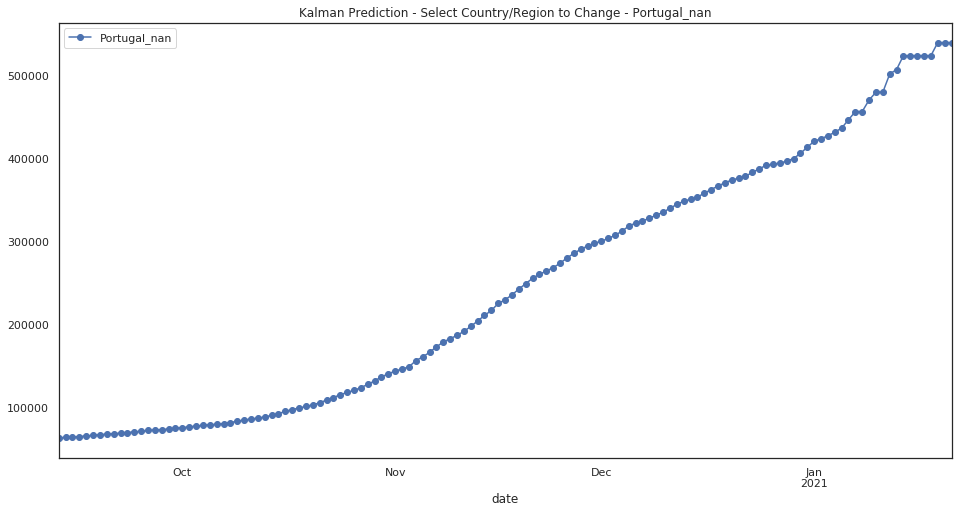

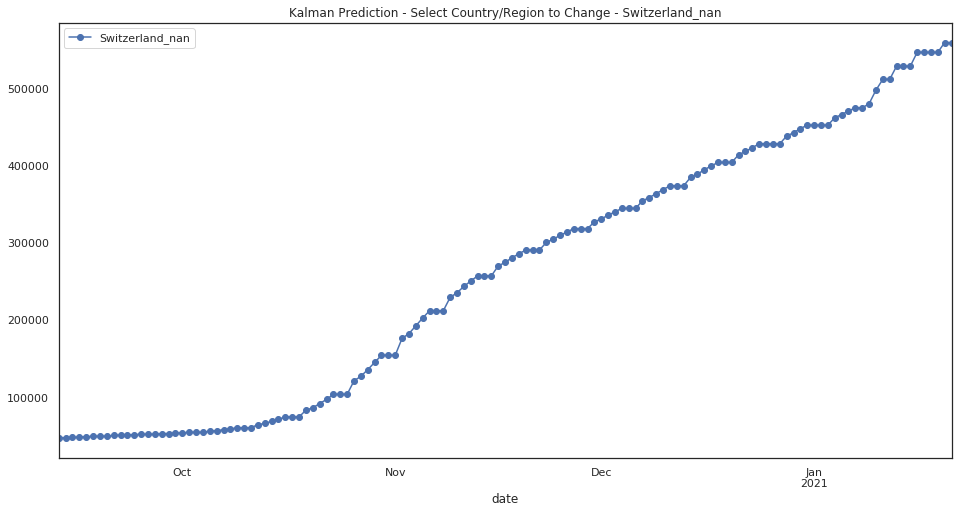

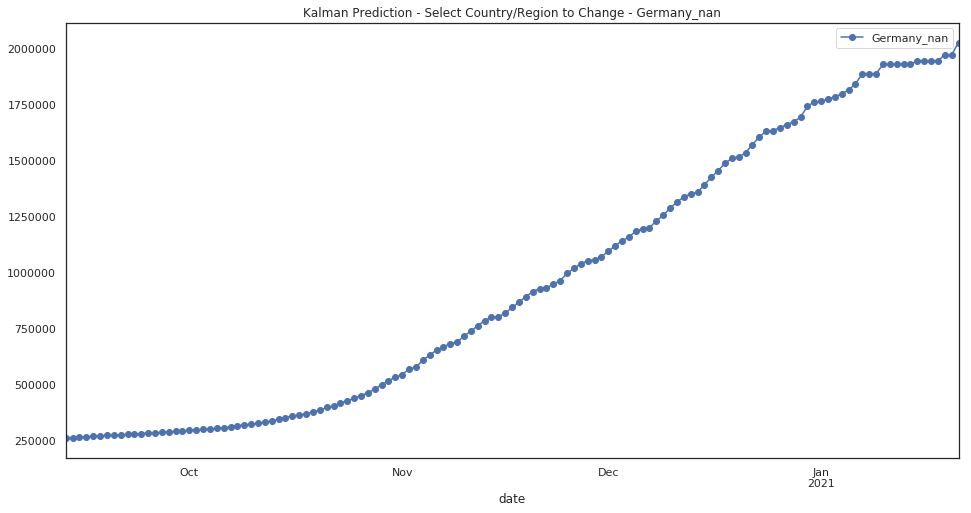

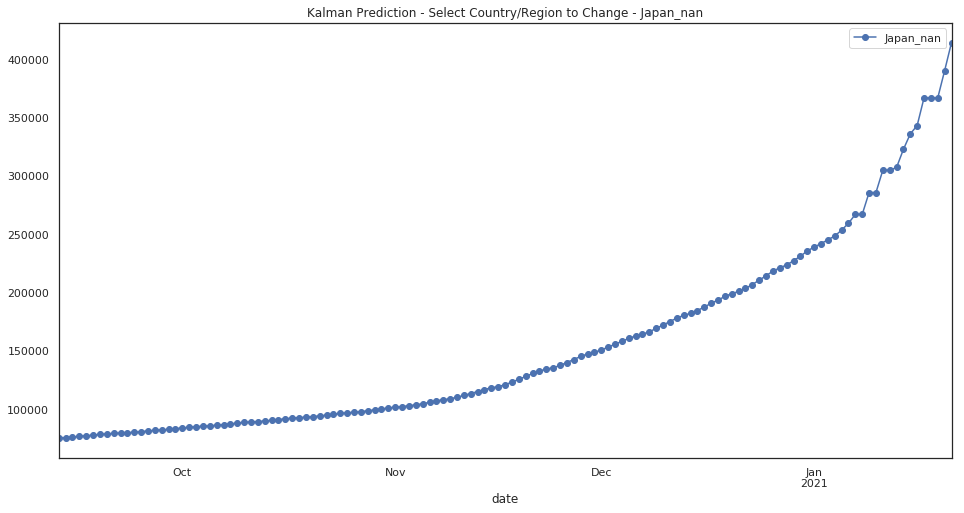

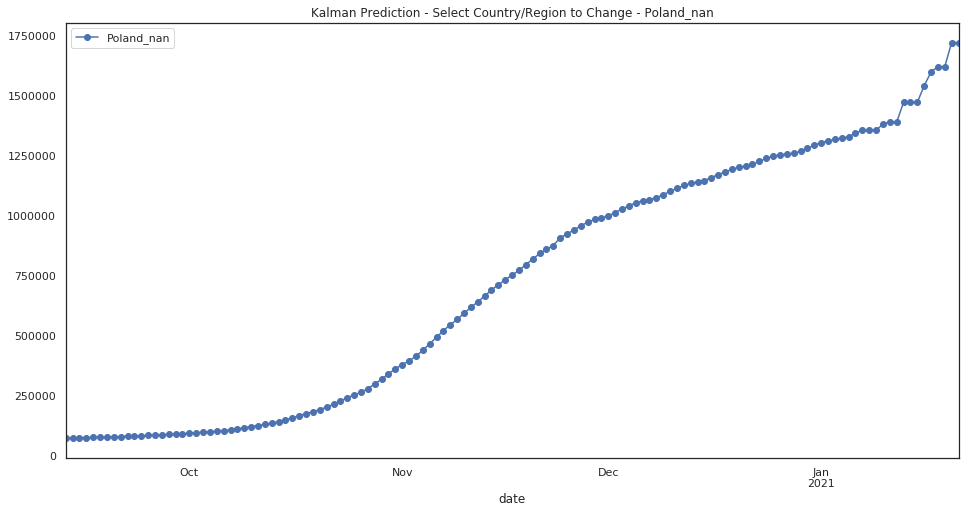

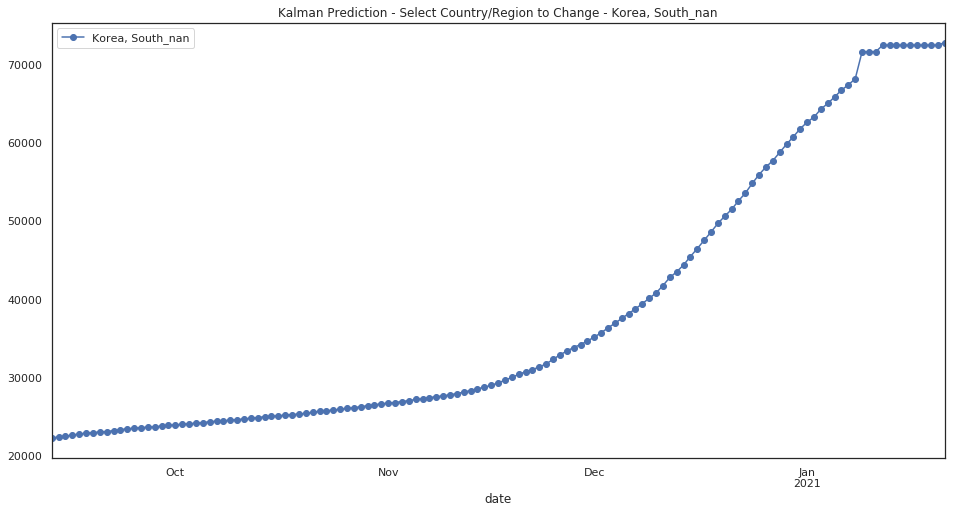

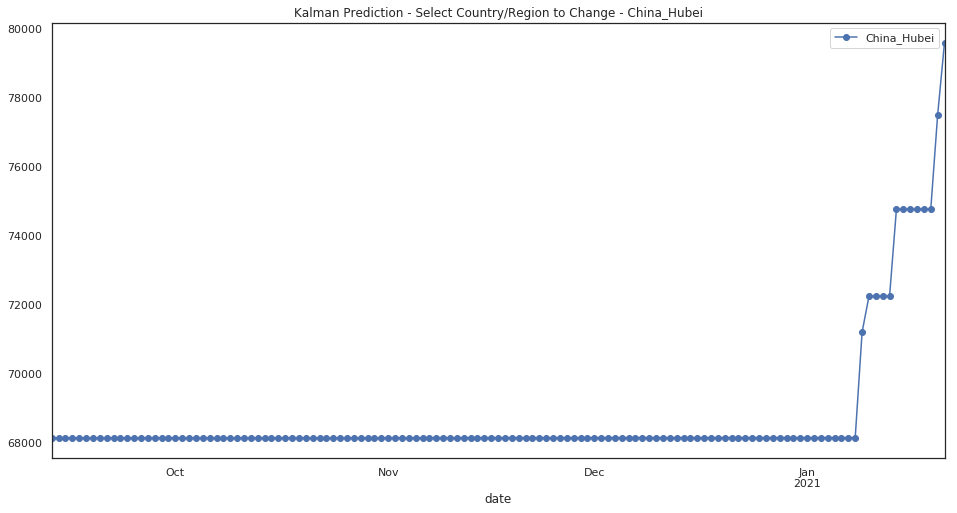

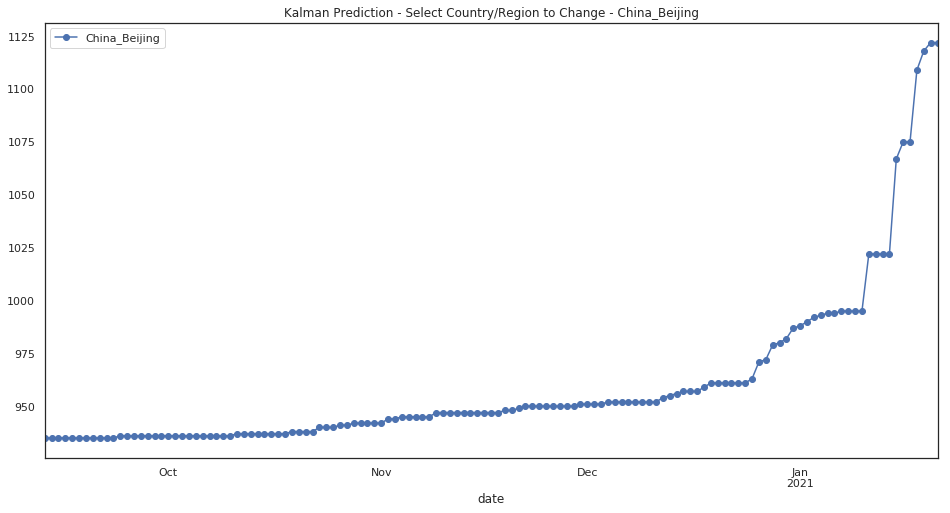

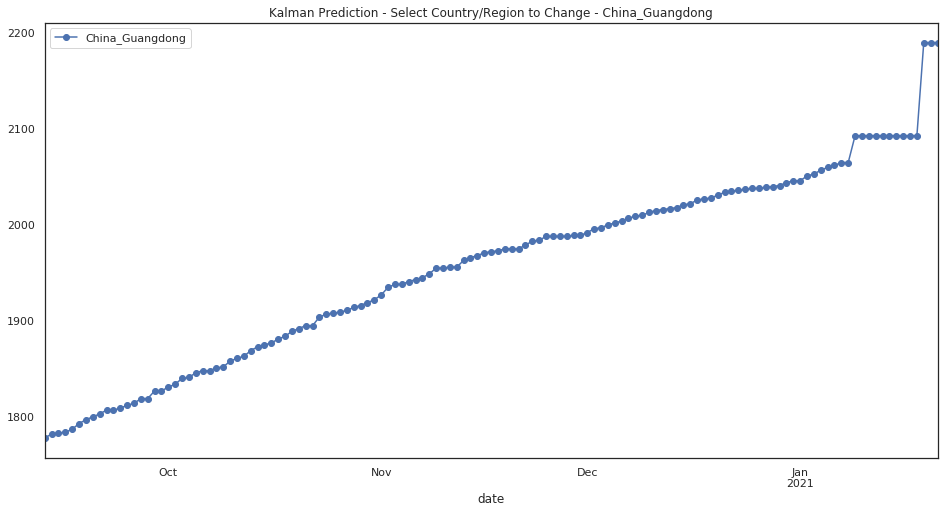

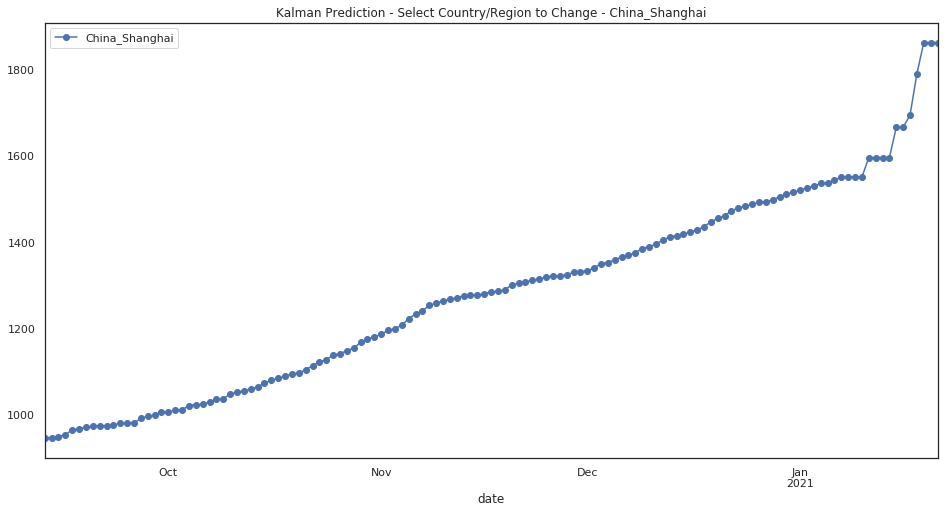

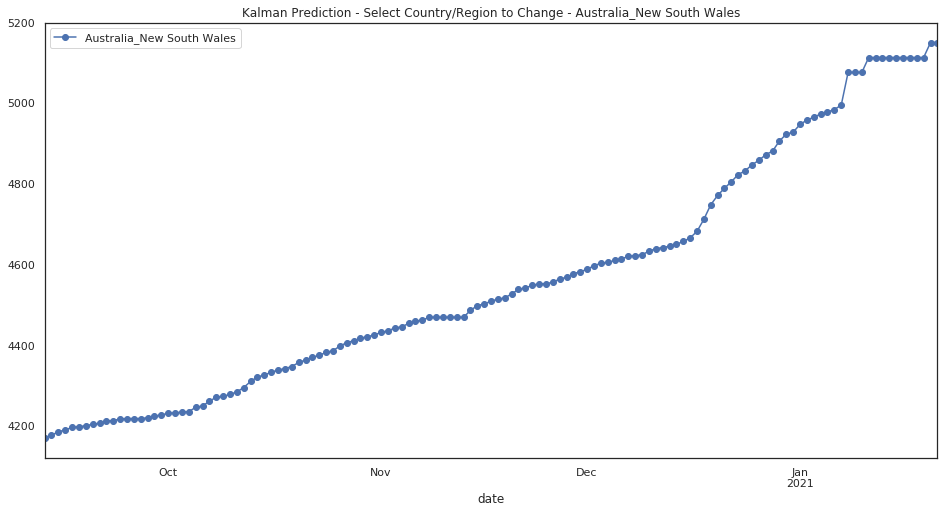

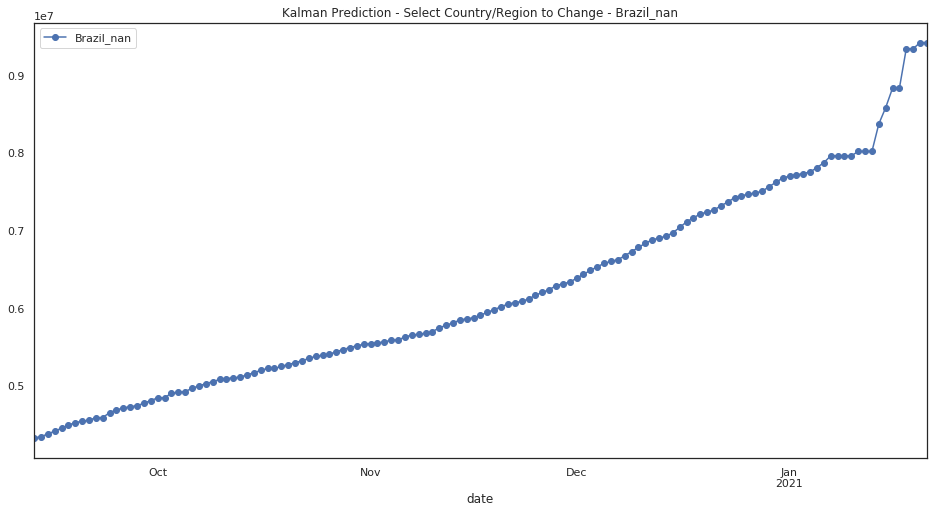

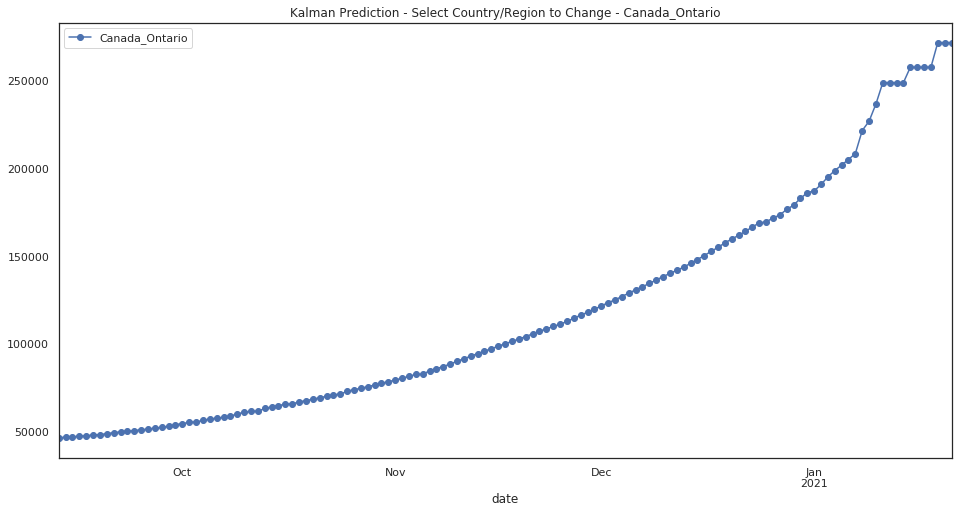

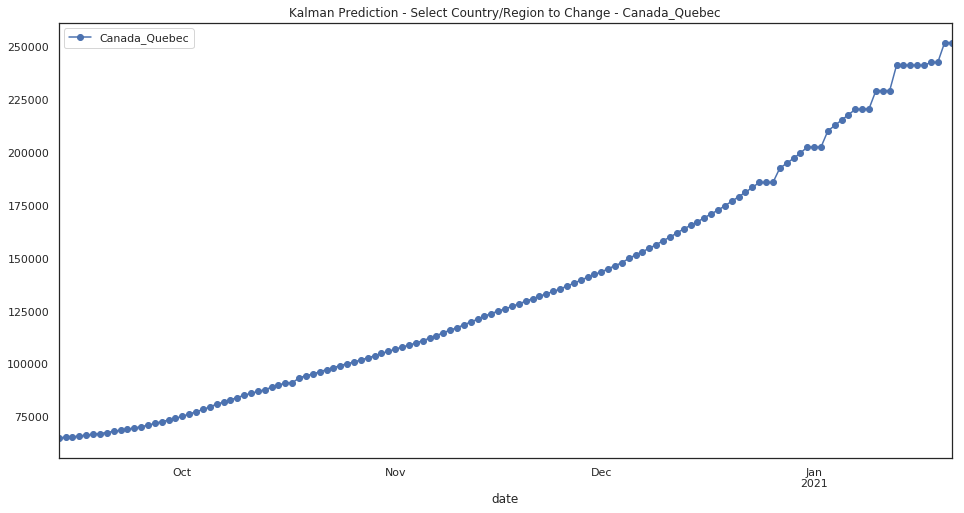

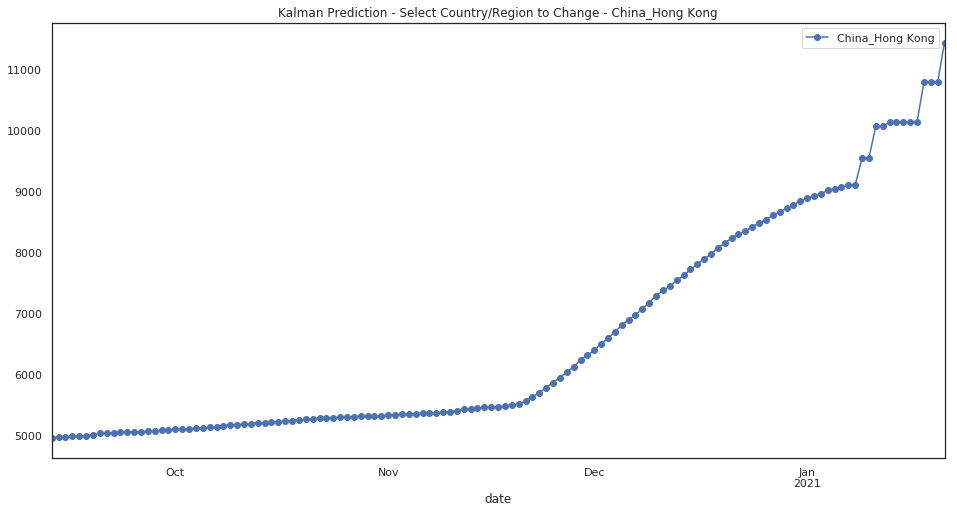

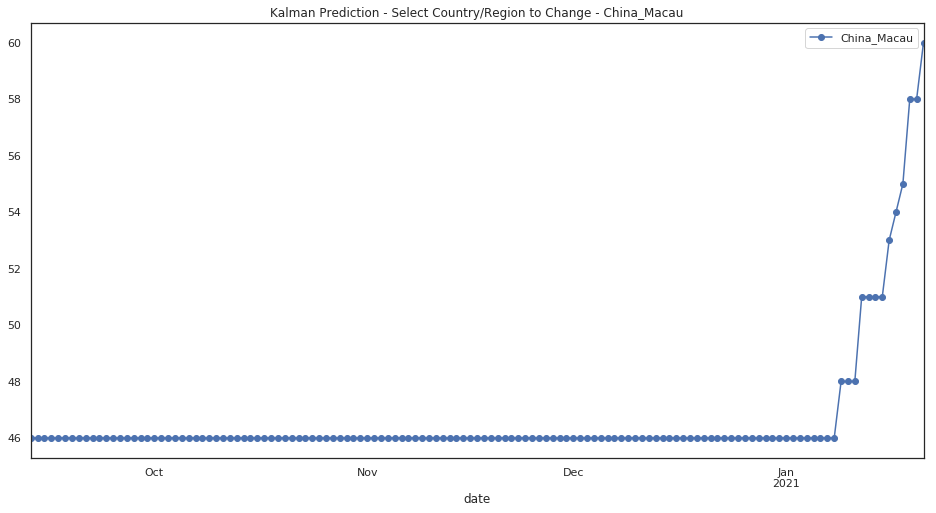

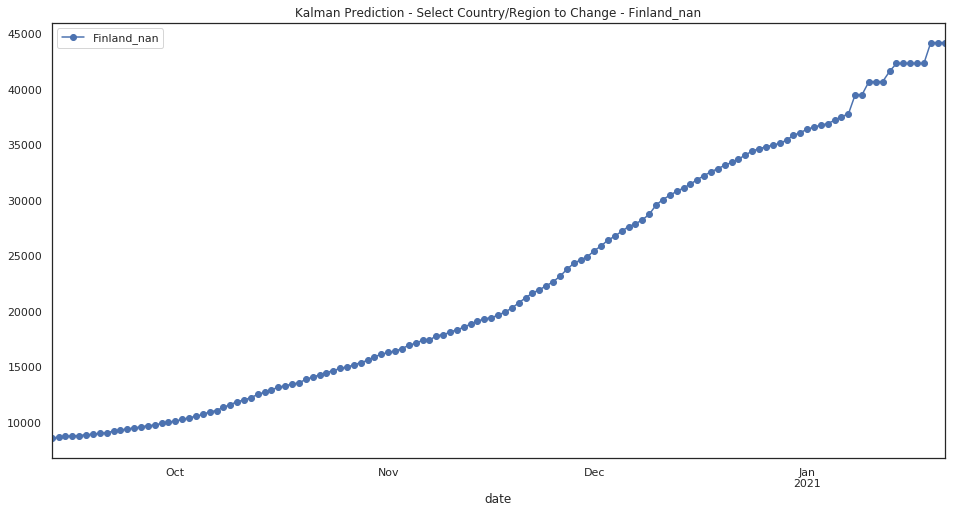

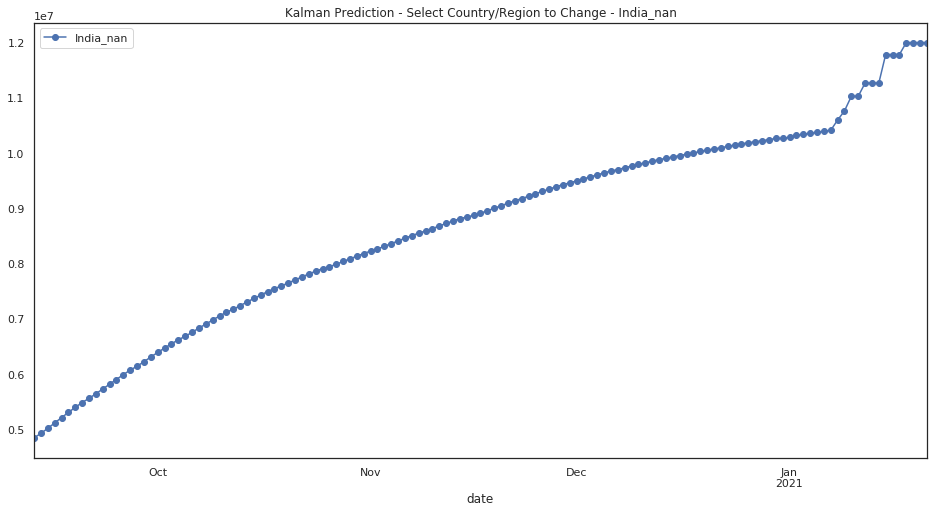

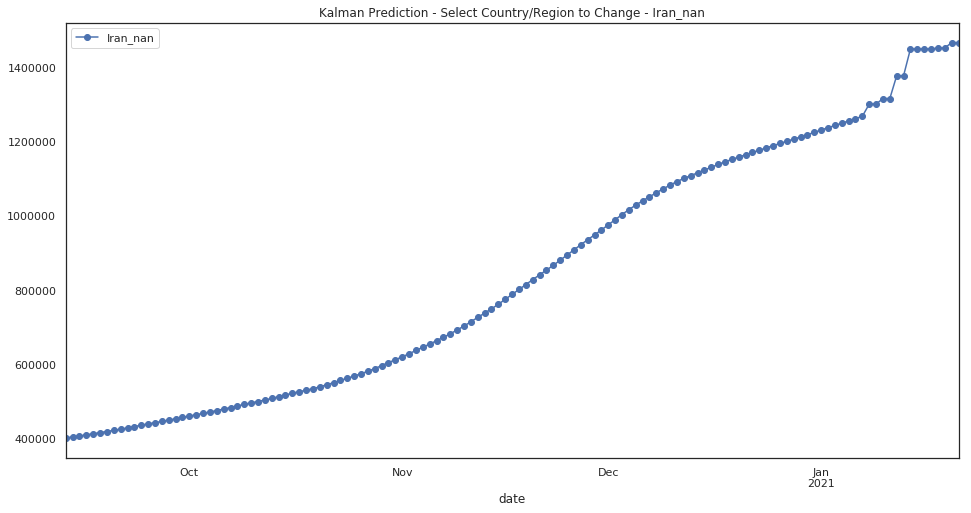

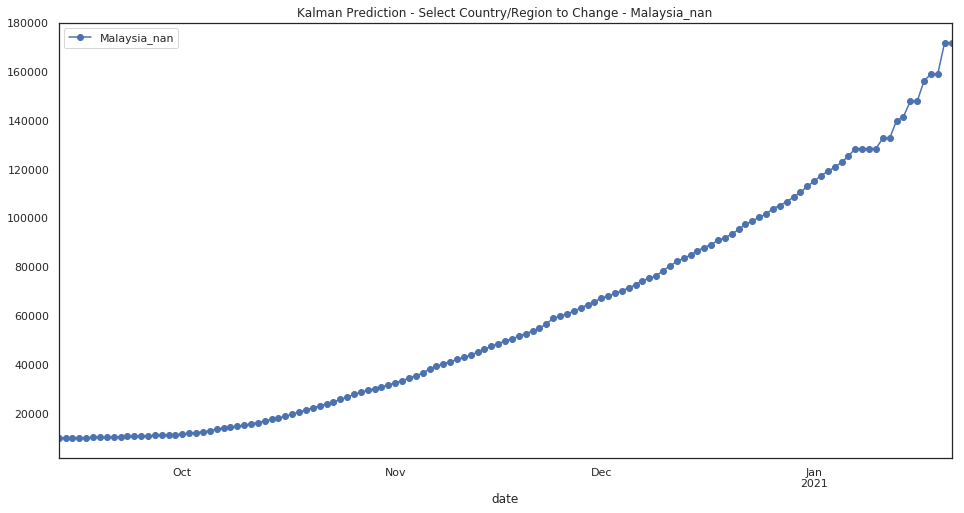

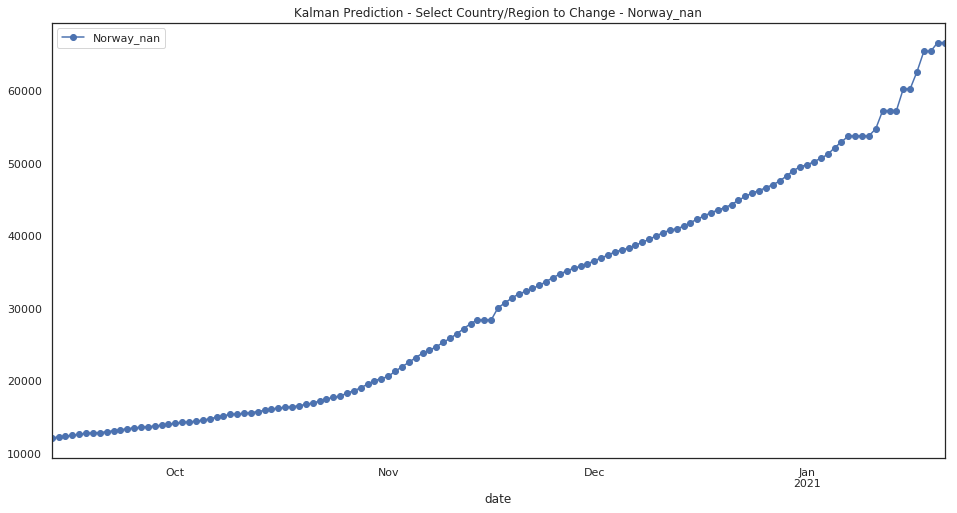

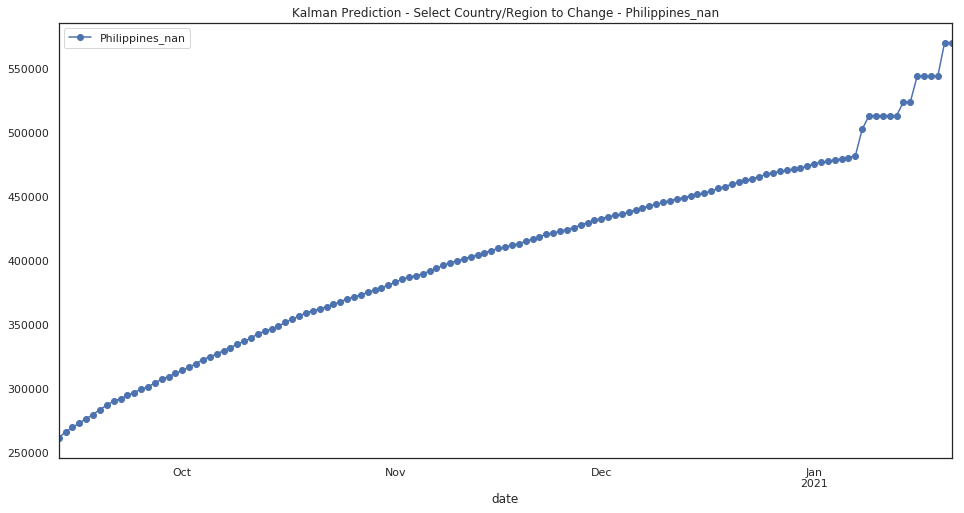

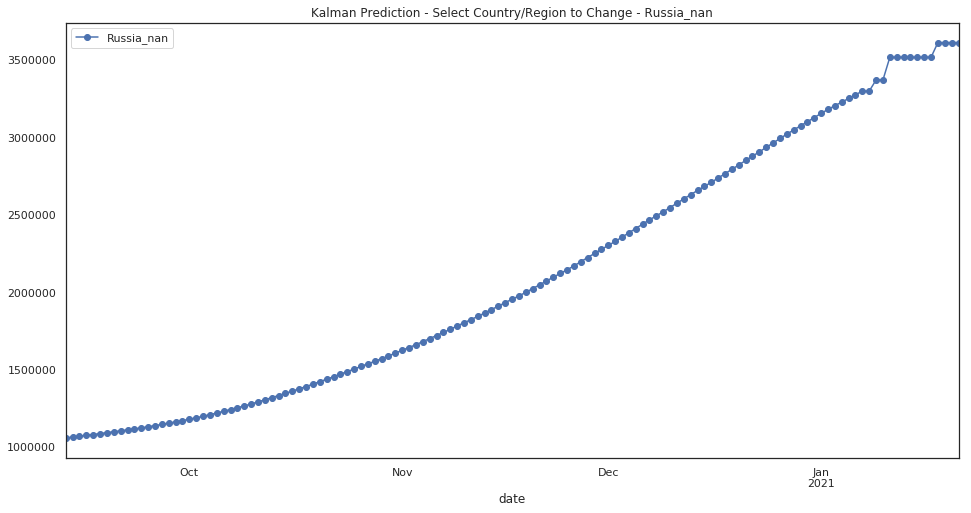

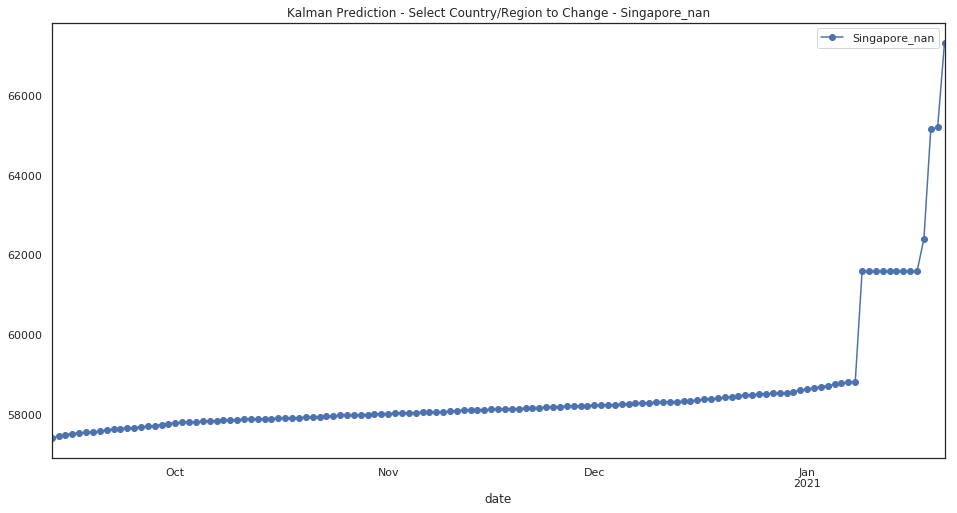

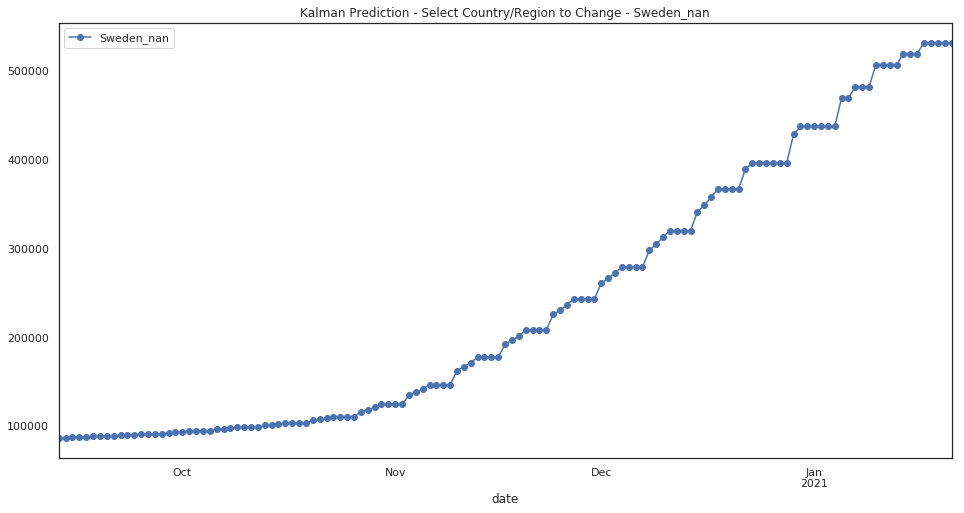

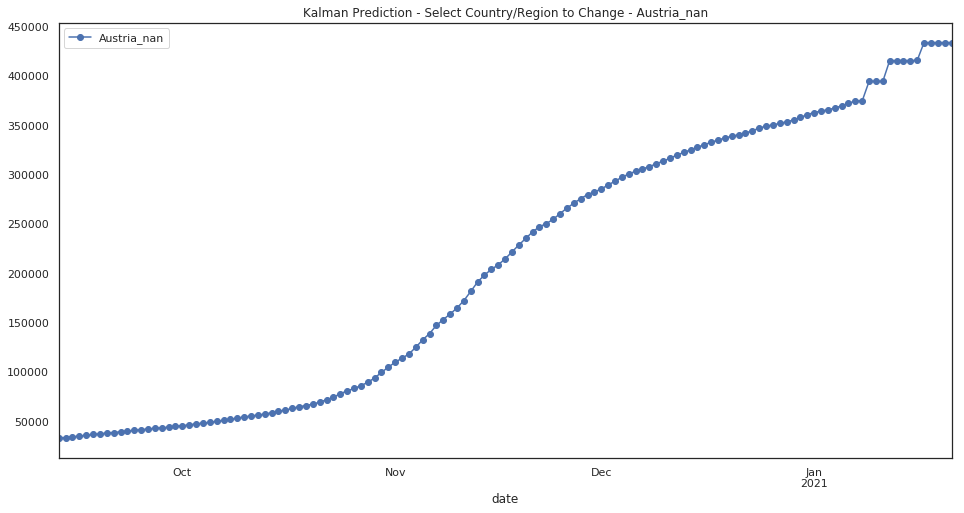

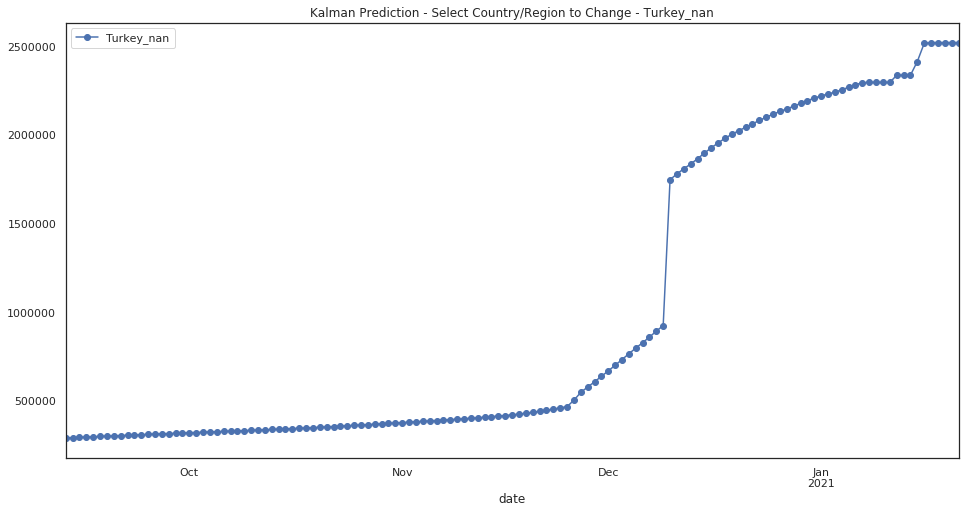

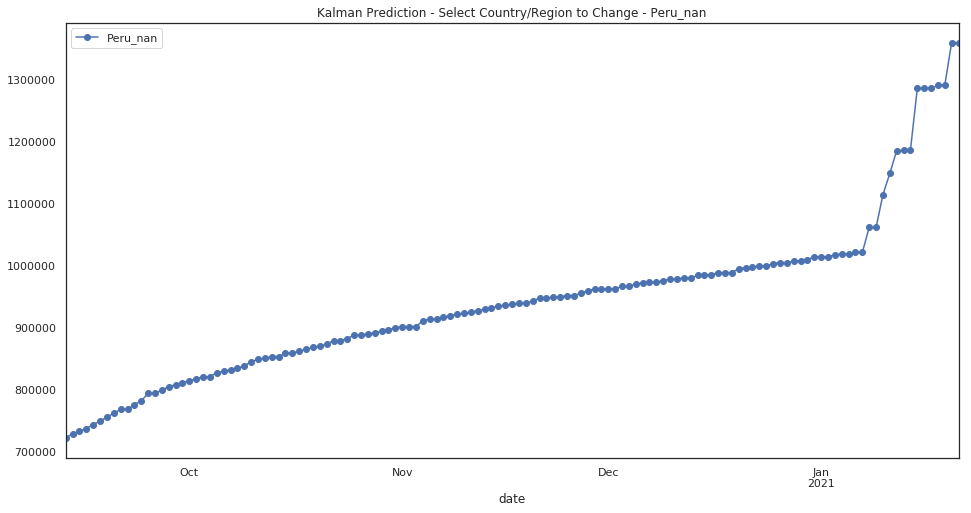

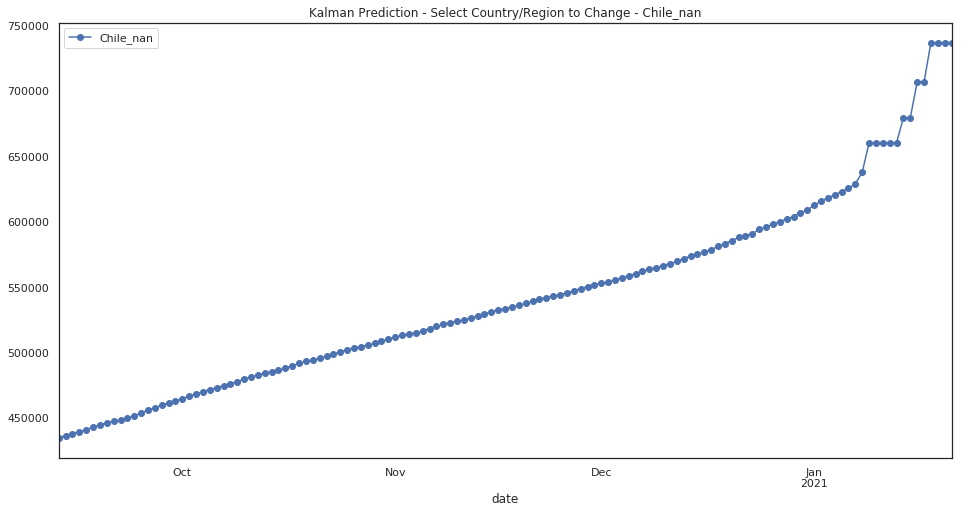

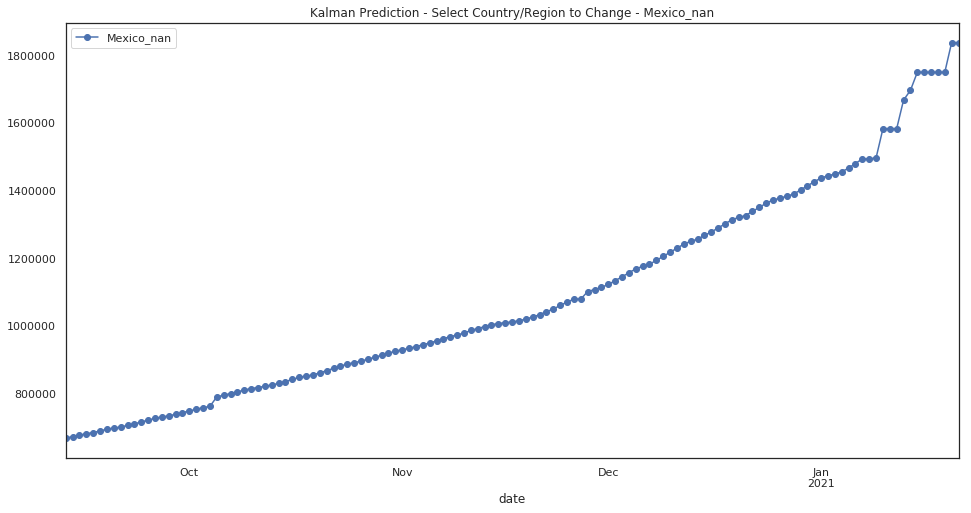

In [66]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [67]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2021-01-21 00:00:00
dtype: object


0  pred_confirmed
United States_nan                           NaN      25142553.0
India_nan                                   NaN      12001864.0
Brazil_nan                                  NaN       9419210.0
Russia_nan                                  NaN       3611008.0
United Kingdom_nan                          NaN       3443455.0
France_nan                                  NaN       2973257.0
Spain_nan                                   NaN       2835516.0
Italy_nan                                   NaN       2705344.0
Turkey_nan                                  NaN       2521851.0
Argentina_nan                               NaN       2233142.0
Colombia_nan                                NaN       2188238.0
Germany_nan                                 NaN       2025171.0
Mexico_nan                                  NaN       1837496.0
Poland_nan                                  NaN       1722541.0
Iran_nan                                    NaN       1466684.0
South Africa_nan                            NaN       1418462.0
Peru_nan                                    NaN       1360413.0
Ukraine_nan                                 NaN       1320586.0
Netherlands_nan                             NaN       1166517.0
Indonesia_nan                               NaN        921372.0
Czechia_nan                                 NaN        840154.0
Chile_nan                                   NaN        737010.0
Belgium_nan                                 NaN        710795.0
Romania_nan                                 NaN        696537.0
Iraq_nan                                    NaN        664174.0
Israel_nan                                  NaN        630378.0
Pakistan_nan                                NaN        592036.0
Morocco_nan                                 NaN        579425.0
Bangladesh_nan                              NaN        572463.0
Philippines_nan                             NaN        570727.0
...                                         ...             ...
Dominica_nan                                NaN           131.0
United Kingdom_British Virgin Islands       NaN           129.0
Canada_Prince Edward Island                 NaN           115.0
Australia_Northern Territory                NaN           104.0
China_Ningxia                               NaN            83.0
Canada_Yukon                                NaN            74.0
Fiji_nan                                    NaN            67.0
China_Macau                                 NaN            60.0
Timor-Leste_nan                             NaN            57.0
Laos_nan                                    NaN            46.0
France_New Caledonia                        NaN            45.0
Saint Kitts and Nevis_nan                   NaN            37.0
Holy See_nan                                NaN            34.0
Denmark_Greenland                           NaN            34.0
United Kingdom_Falkland Islands (Malvinas)  NaN            32.0
Canada_Northwest Territories                NaN            26.0
China_Qinghai                               NaN            20.0
France_Saint Pierre and Miquelon            NaN            17.0
Solomon Islands_nan                         NaN            17.0
United Kingdom_Anguilla                     NaN            15.0
Canada_Grand Princess                       NaN            15.0
United Kingdom_Montserrat                   NaN            14.0
Canada_Repatriated Travellers               NaN            14.0
MS Zaandam_nan                              NaN             9.0
France_Wallis and Futuna                    NaN             8.0
Marshall Islands_nan                        NaN             4.0
Samoa_nan                                   NaN             2.0
Vanuatu_nan                                 NaN             1.0
China_Tibet                                 NaN             1.0
Canada_Diamond Princess                     NaN             0.0

[272 rows x 2 columns]

In [68]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [69]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [70]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [71]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [72]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [73]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-09-13          59054.0      35503.0      67263.0      26888.0   
2020-09-14          59102.0      35646.0      67471.0      26969.0   
2020-09-15          38772.0      11520.0      48496.0       1438.0   
2020-09-16          38815.0      11672.0      48734.0       1438.0   
2020-09-17          38855.0      11816.0      48966.0       1483.0   
2020-09-18          38872.0      11948.0      49194.0       1483.0   
2020-09-19          38897.0      12073.0      49413.0       1564.0   
2020-09-20          38919.0      12226.0      49623.0       1564.0   
2020-09-21          39254.0      12524.0      50167.0       2089.0   
2020-09-22          39305.0      12681.0      50360.0       1681.0   
2020-09-23          39353.0      12836.0      50548.0       2206.0   
2020-09-24          39367.0      12981.0      50729.0       1753.0   
2020-09-25          39391.0      13083.0      50907.0       2239.0   
2020-09-26          39400.0      13211.0      51070.0       1836.0   
2020-09-27          39431.0      13344.0      51226.0       2255.0   
2020-09-28          39443.0      13472.0      51374.0       2367.0   
2020-09-29          39464.0      13559.0      51529.0       1966.0   
2020-09-30          39478.0      13703.0      51690.0       2498.0   
2020-10-01          39495.0      13855.0      51851.0       2050.0   
2020-10-02          39501.0      13978.0      52011.0       2512.0   
2020-10-03          39511.0      14136.0      52162.0       2110.0   
2020-10-04          39549.0      14302.0      52304.0       2488.0   
2020-10-05          39616.0      14452.0      52439.0       2711.0   
2020-10-06          39676.0      14615.0      52569.0       2370.0   
2020-10-07          39746.0      14758.0      52691.0       3113.0   
2020-10-08          39813.0      14924.0      52828.0       2568.0   
2020-10-09          39884.0      15087.0      52972.0       3206.0   
2020-10-10          39899.0      15259.0      53111.0       2696.0   
2020-10-11          39997.0      15432.0      53246.0       3177.0   
2020-10-12          40049.0      15600.0      53482.0       3434.0   
...                     ...          ...          ...          ...   
2020-12-24          50802.0      54889.0      97153.0       7947.0   
2020-12-25          50971.0      55454.0      97586.0       8022.0   
2020-12-26          51068.0      55864.0      98003.0       7995.0   
2020-12-27          51207.0      56358.0      98392.0       8043.0   
2020-12-28          51422.0      56692.0      98770.0       8198.0   
2020-12-29          51510.0      57232.0      99130.0       8123.0   
2020-12-30          51590.0      57803.0      99453.0       8215.0   
2020-12-31          51704.0      58395.0      99754.0       8234.0   
2021-01-01          51710.0      58493.0     100042.0       8302.0   
2021-01-02          51724.0      59087.0     100309.0       8356.0   
2021-01-03          51724.0      59530.0     100560.0       8441.0   
2021-01-04          53000.0      59756.0     100801.0       8553.0   
2021-01-05          53181.0      60378.0     101032.0       8518.0   
2021-01-06          53348.0      61074.0     101279.0       8560.0   
2021-01-07          53447.0      61787.0     101546.0       8625.0   
2021-01-08          53357.0      64715.0     102924.0       8726.0   
2021-01-09          55877.0      65157.0     103357.0       8711.0   
2021-01-10          56131.0      65587.0     103369.0       8700.0   
2021-01-11          56354.0      65637.0     103460.0       8860.0   
2021-01-12          57558.0      66356.0     103340.0       8534.0   
2021-01-13          57501.0      66563.0     108274.0       8934.0   
2021-01-14          57582.0      67113.0     110896.0       9262.0   
2021-01-15          57586.0      67255.0     110289.0       8917.0   
2021-01-16          58208.0      67317.0     110183.0       9184.0   
2021-01-17

In [74]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [75]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'Russia_nan',
 'United Kingdom_nan',
 'France_nan',
 'Spain_nan',
 'Italy_nan',
 'Turkey_nan',
 'Argentina_nan',
 'Colombia_nan',
 'Germany_nan',
 'Mexico_nan',
 'Poland_nan',
 'Iran_nan',
 'South Africa_nan',
 'Peru_nan',
 'Ukraine_nan',
 'Netherlands_nan',
 'Indonesia_nan',
 'Czechia_nan',
 'Chile_nan',
 'Belgium_nan',
 'Romania_nan',
 'Iraq_nan',
 'Israel_nan',
 'Pakistan_nan',
 'Morocco_nan',
 'Bangladesh_nan',
 'Philippines_nan',
 'Switzerland_nan',
 'Portugal_nan',
 'Sweden_nan',
 'Serbia_nan',
 'Austria_nan',
 'Japan_nan',
 'Saudi Arabia_nan',
 'Jordan_nan',
 'Hungary_nan',
 'Panama_nan',
 'Nepal_nan',
 'Canada_Ontario',
 'United Arab Emirates_nan',
 'Canada_Quebec',
 'Bulgaria_nan',
 'Azerbaijan_nan',
 'Georgia_nan',
 'Lebanon_nan',
 'Slovakia_nan',
 'Costa Rica_nan',
 'Belarus_nan',
 'Croatia_nan',
 'Kazakhstan_nan',
 'Ecuador_nan',
 'Bolivia_nan',
 'Egypt_nan',
 'Dominican Republic_nan',
 'Denmark_nan',
 'Armenia_nan',
 'Gua

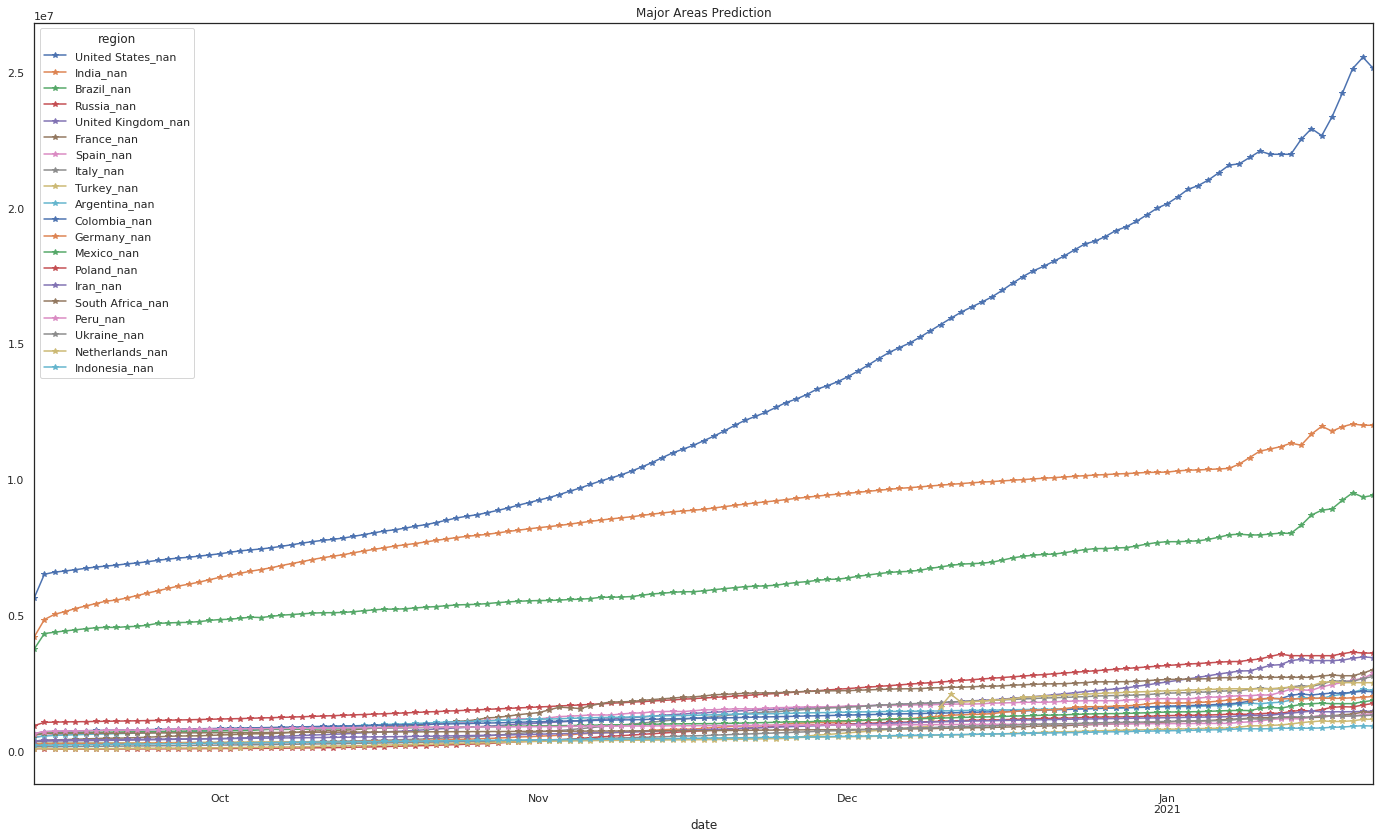

In [76]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

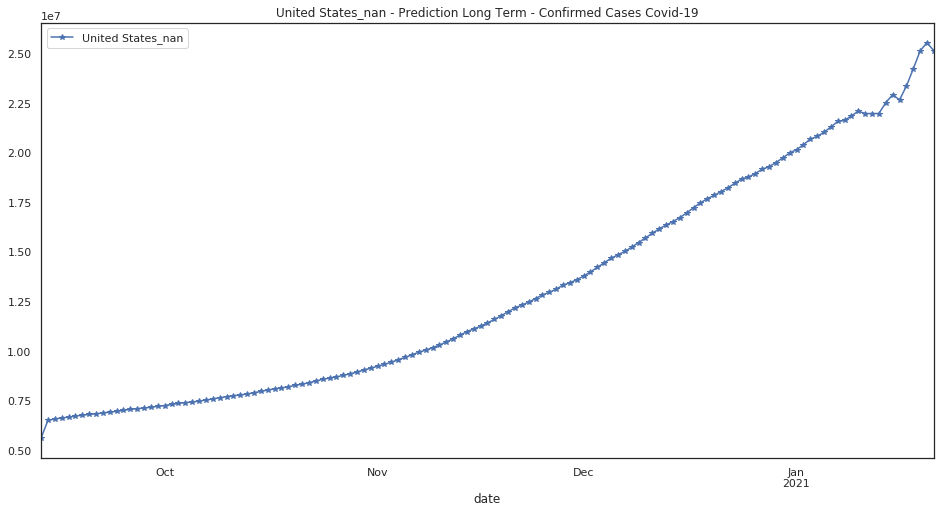

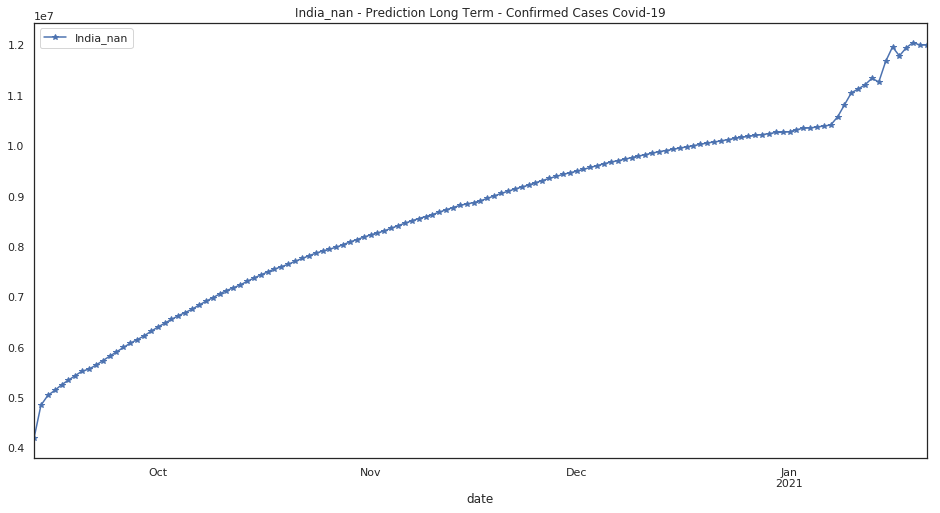

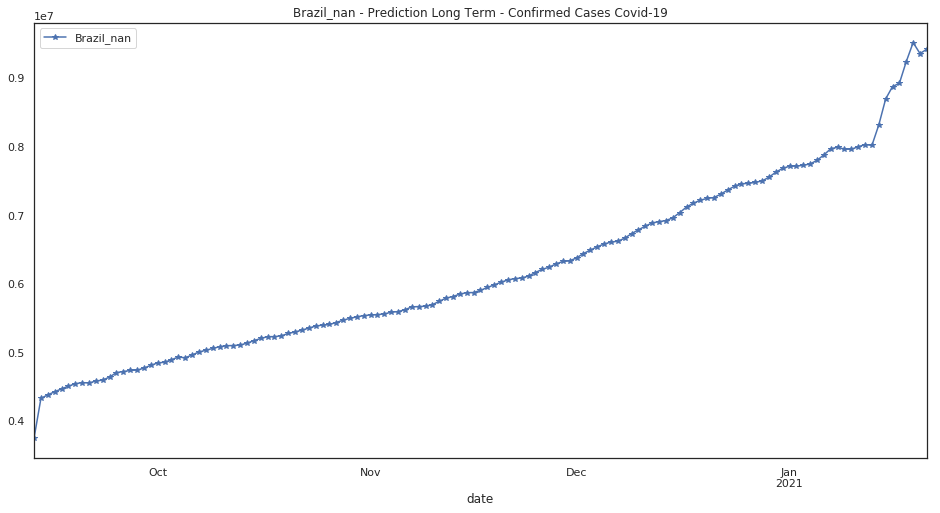

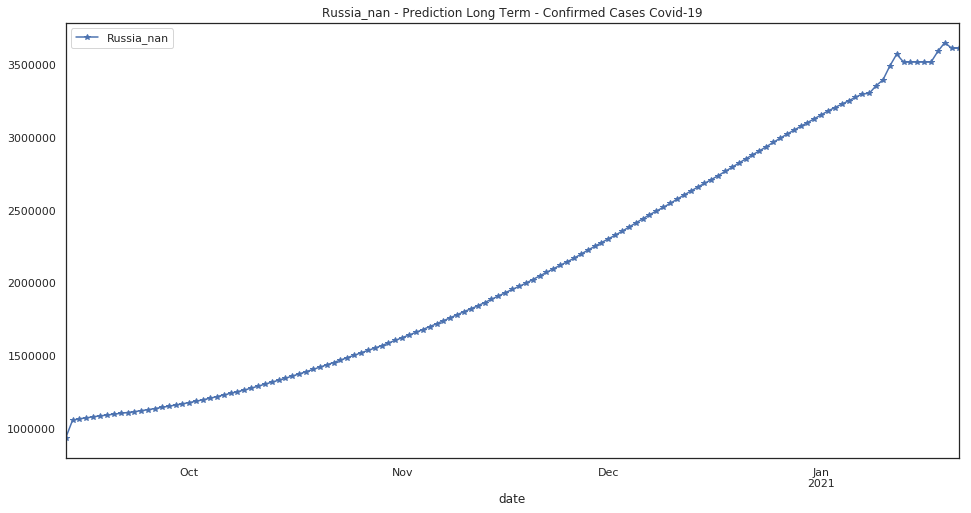

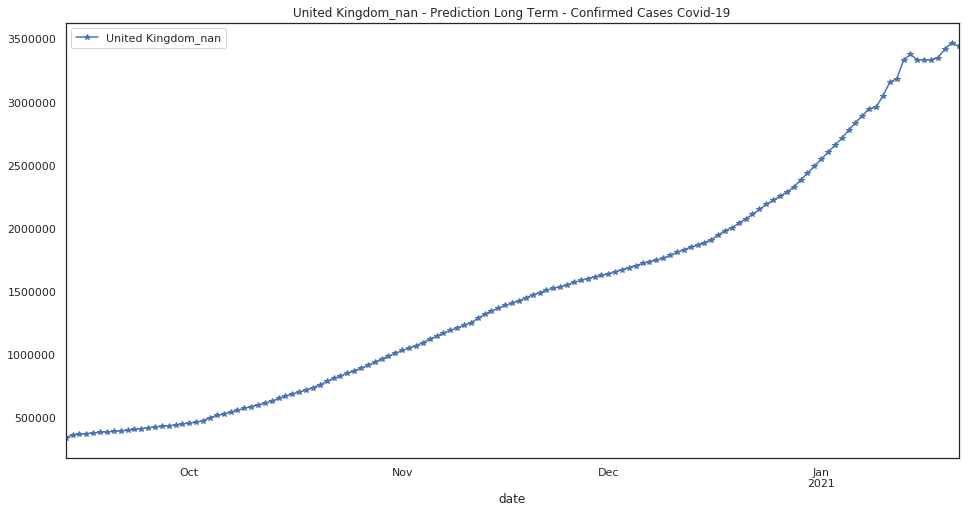

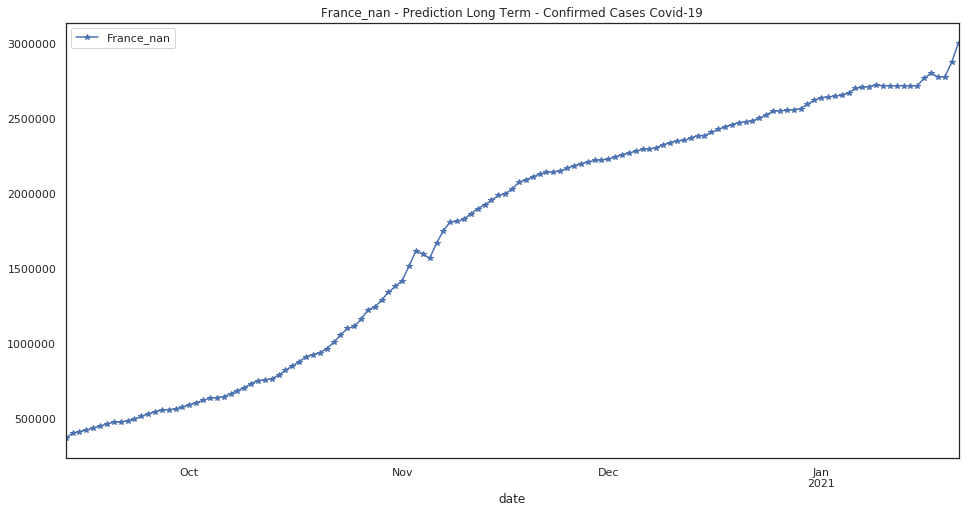

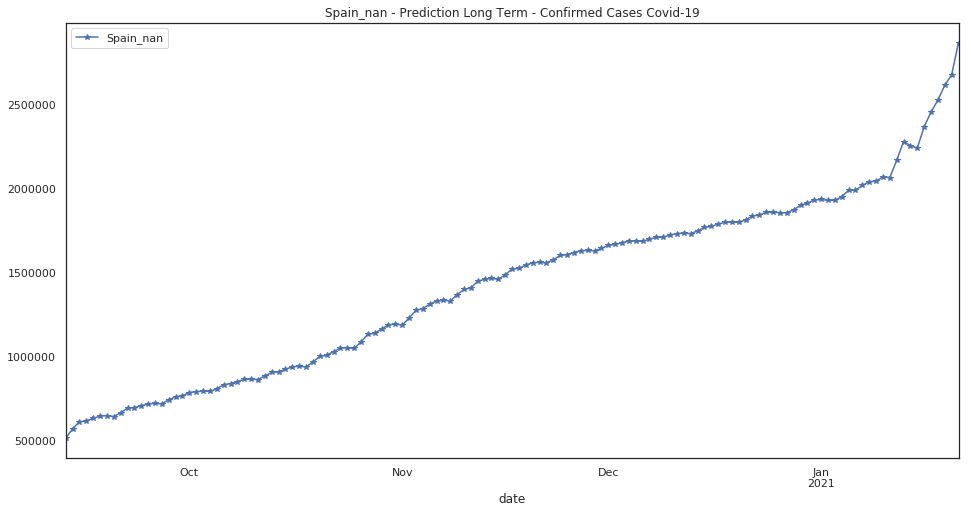

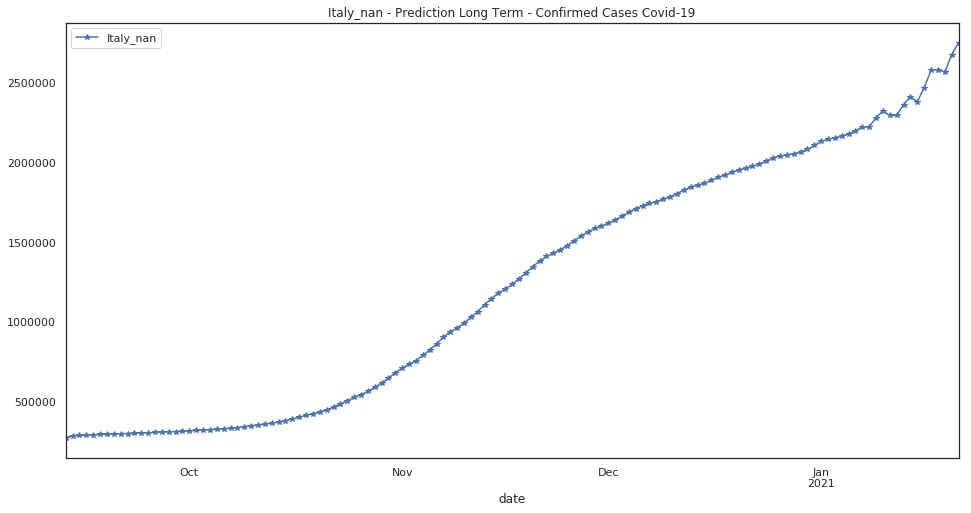

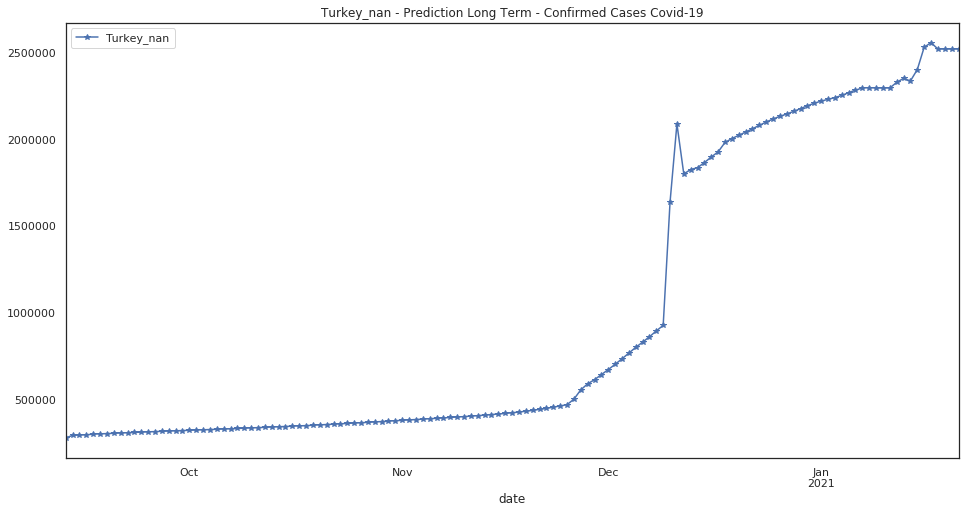

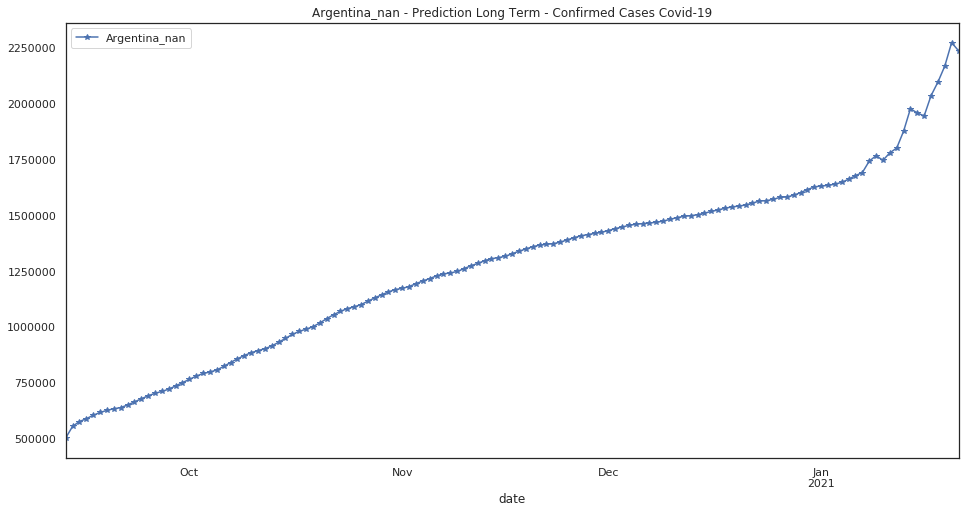

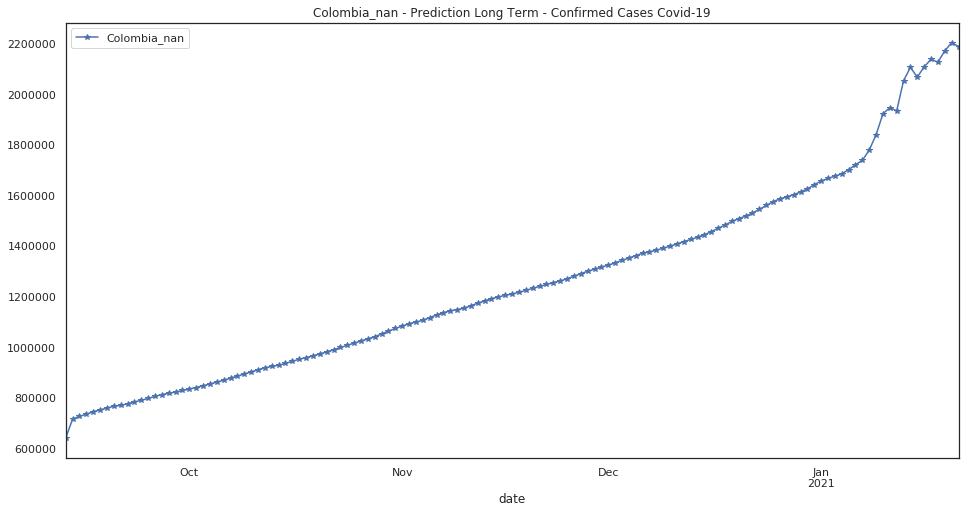

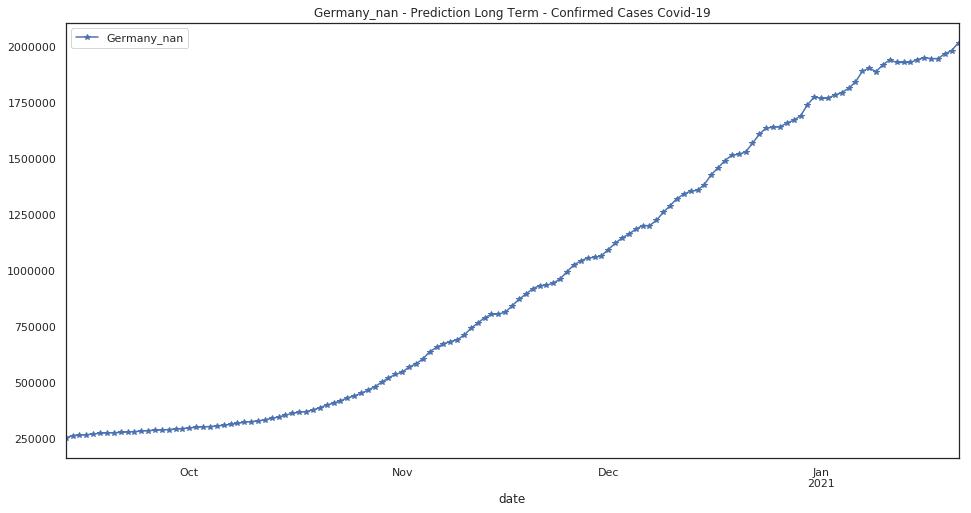

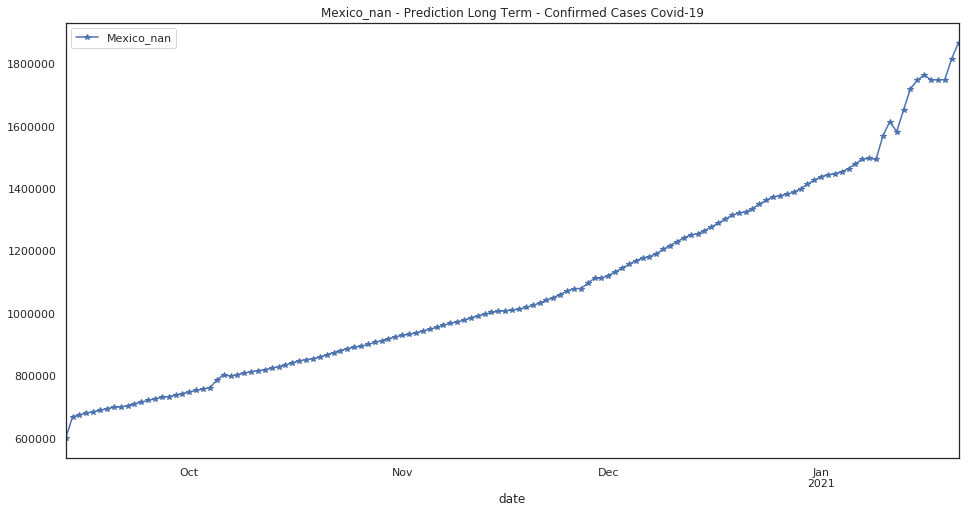

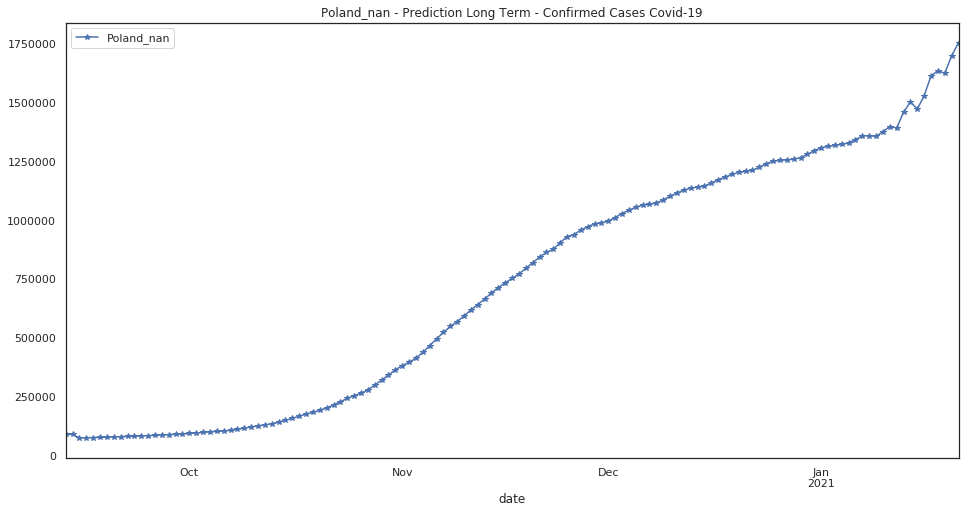

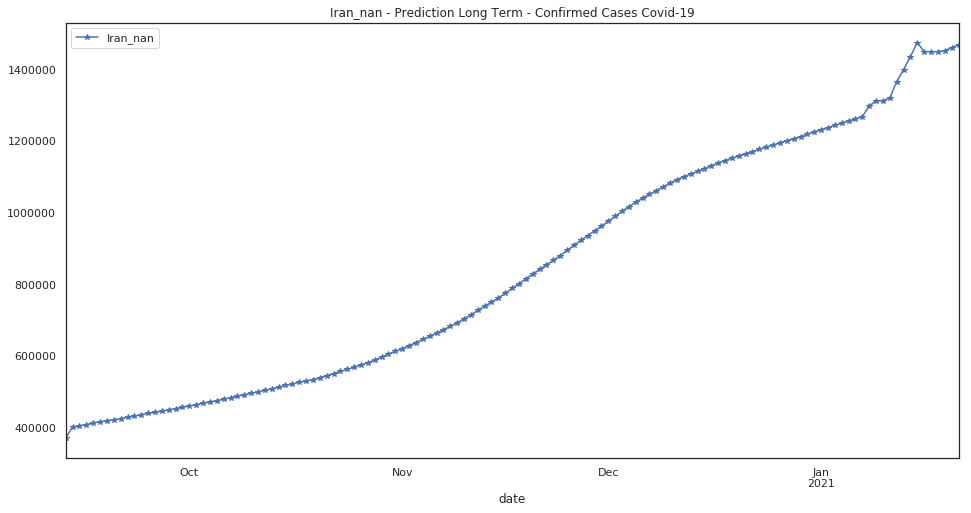

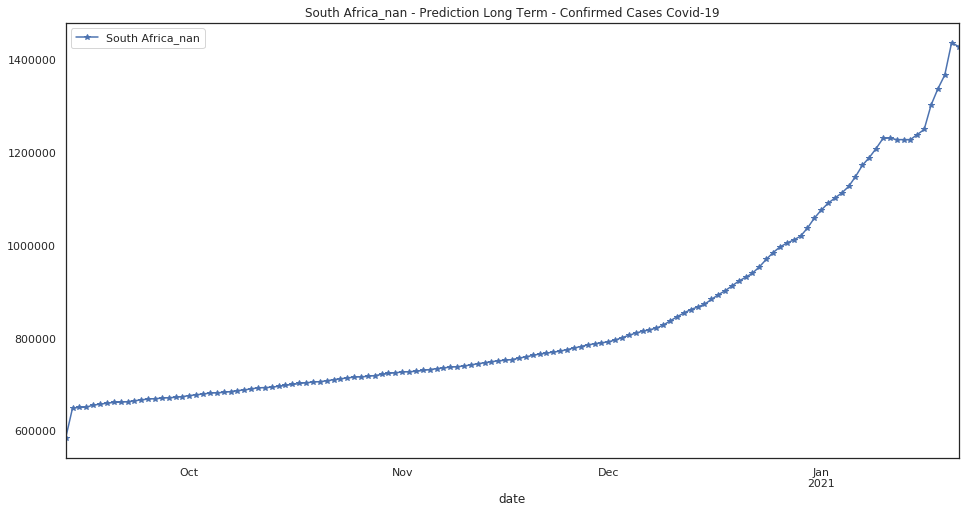

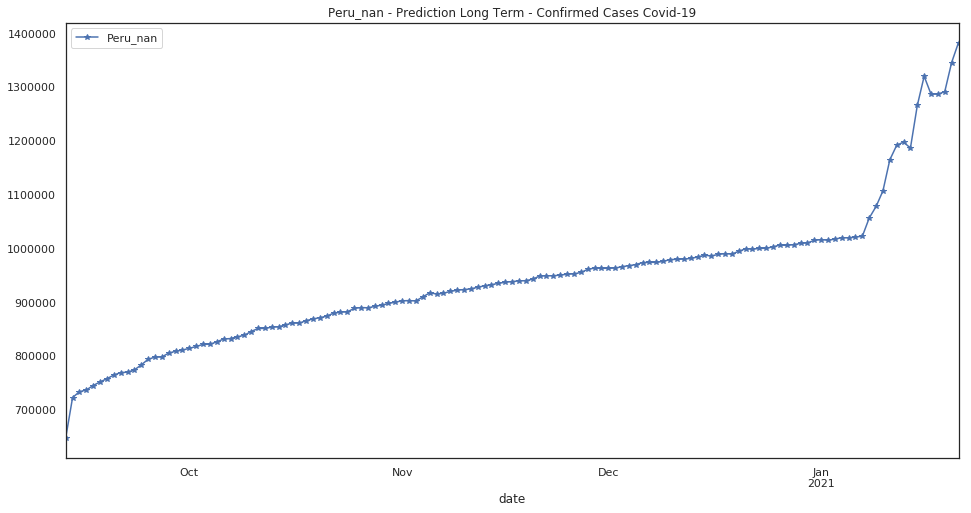

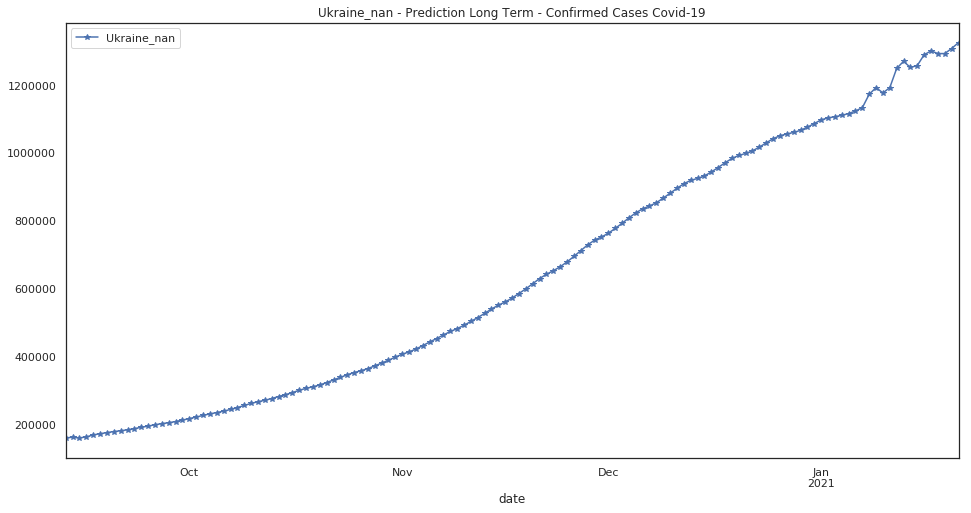

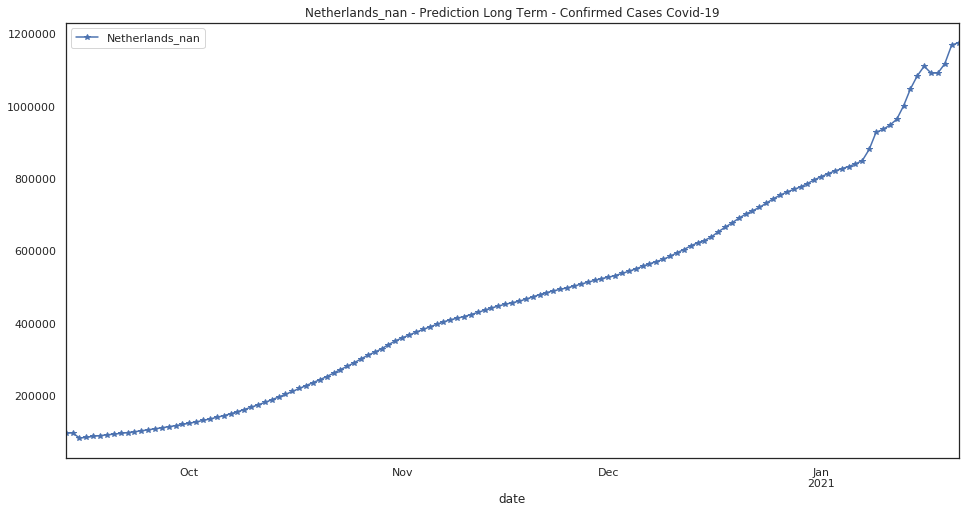

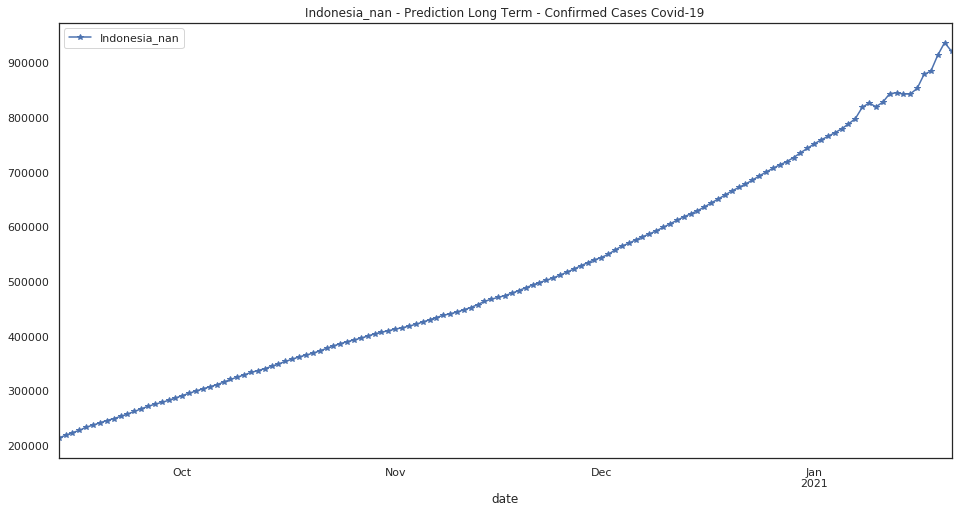

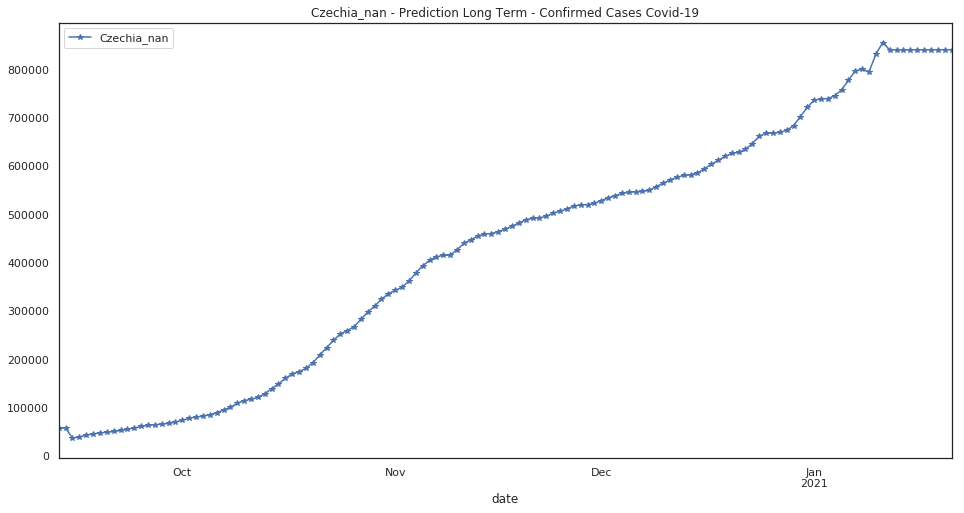

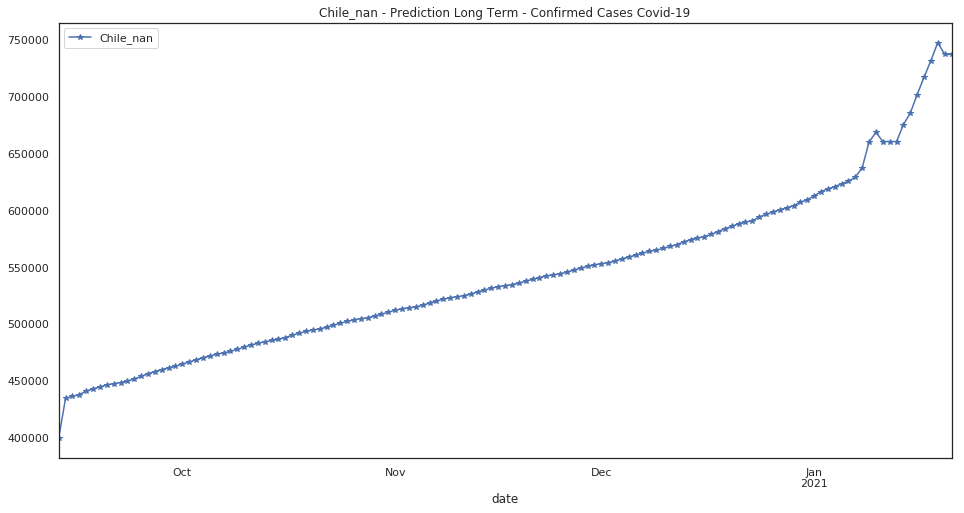

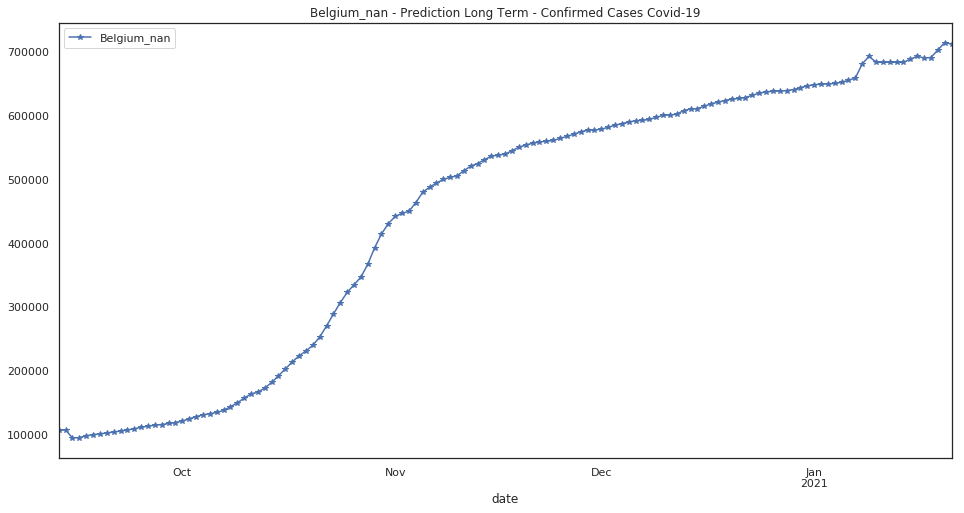

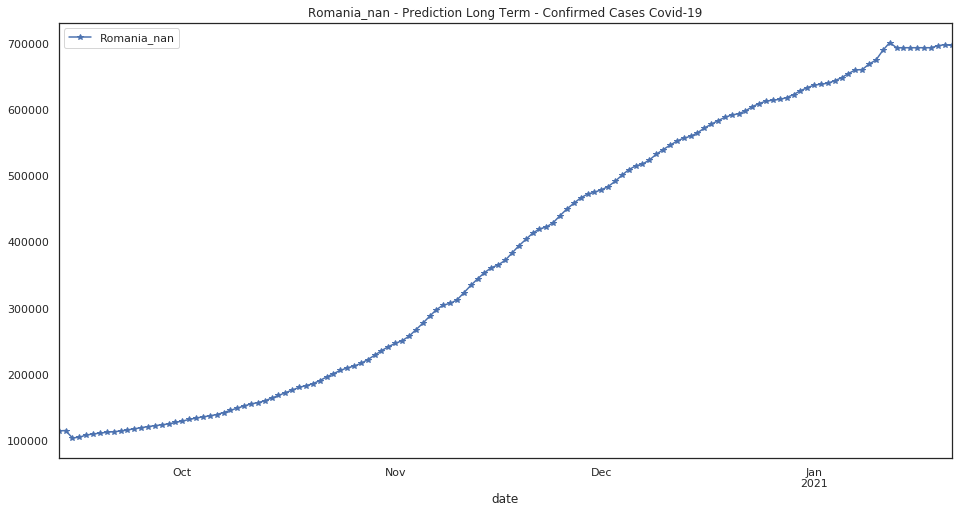

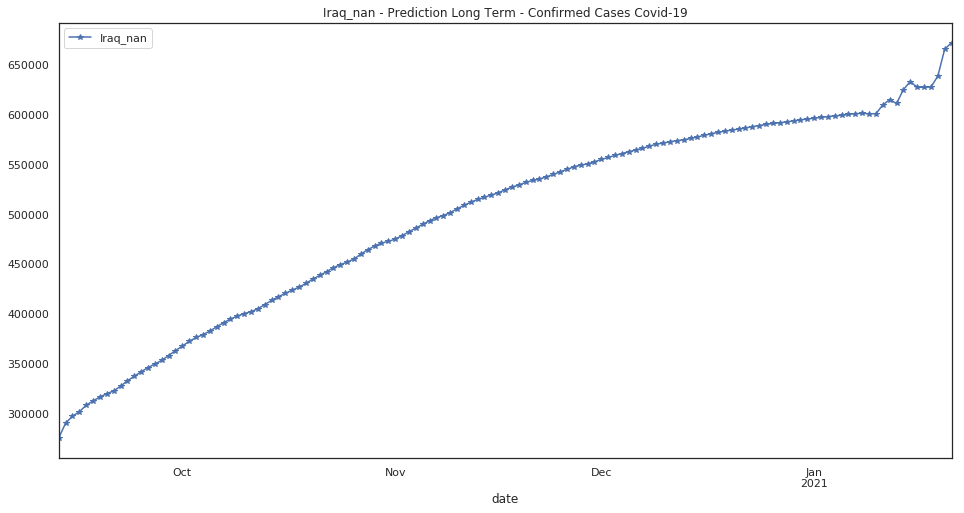

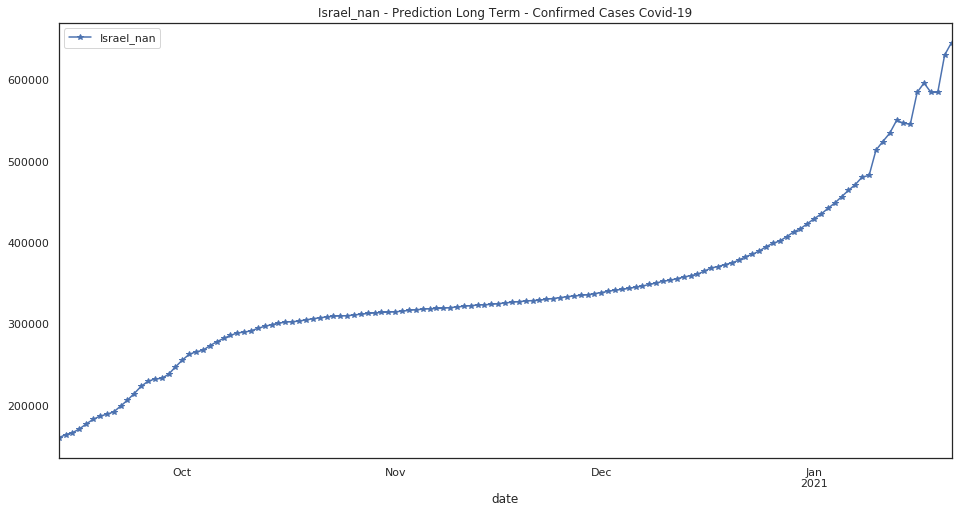

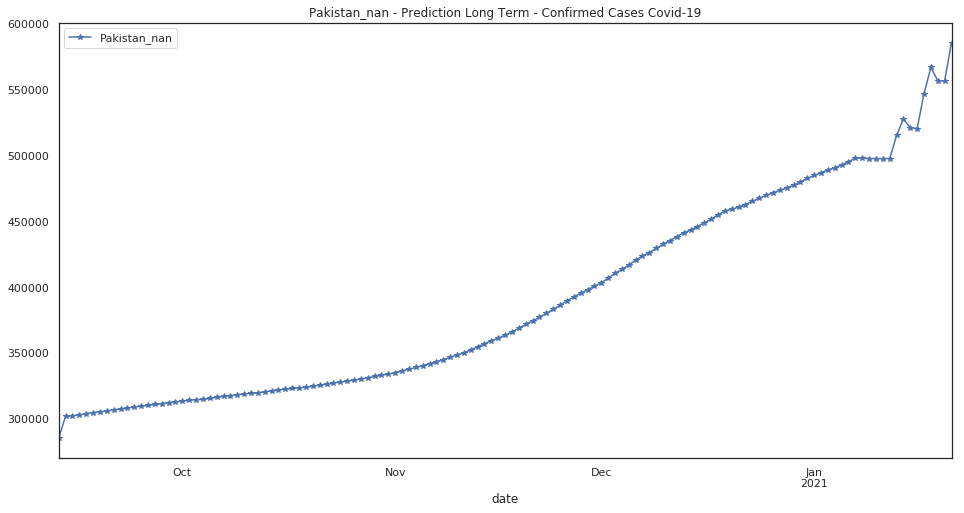

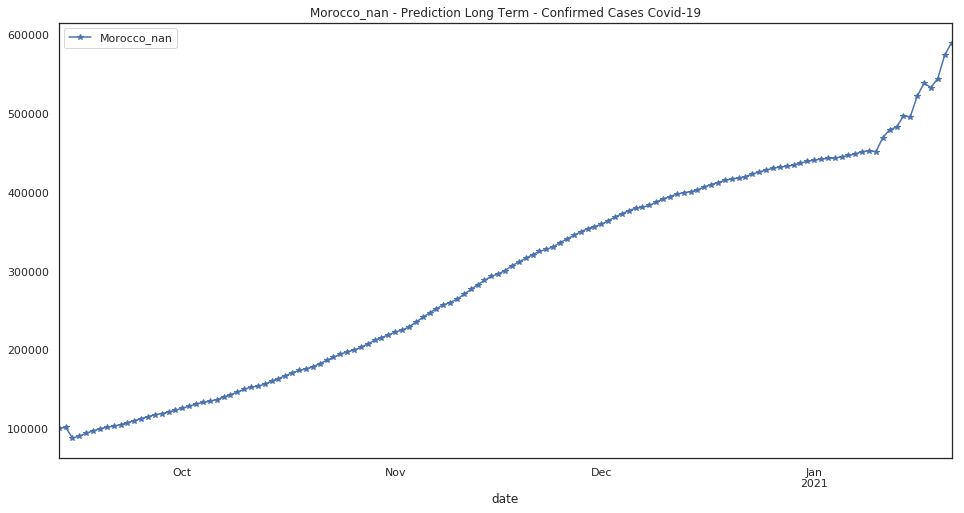

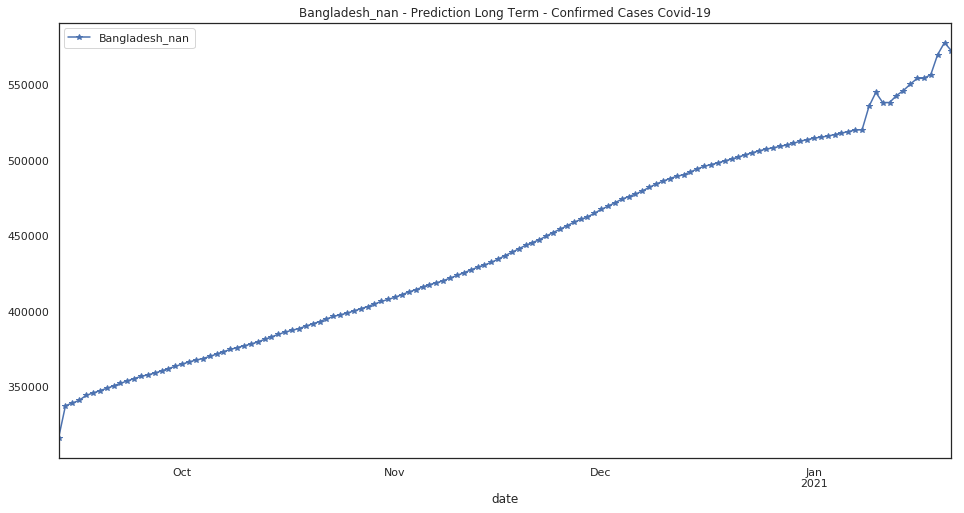

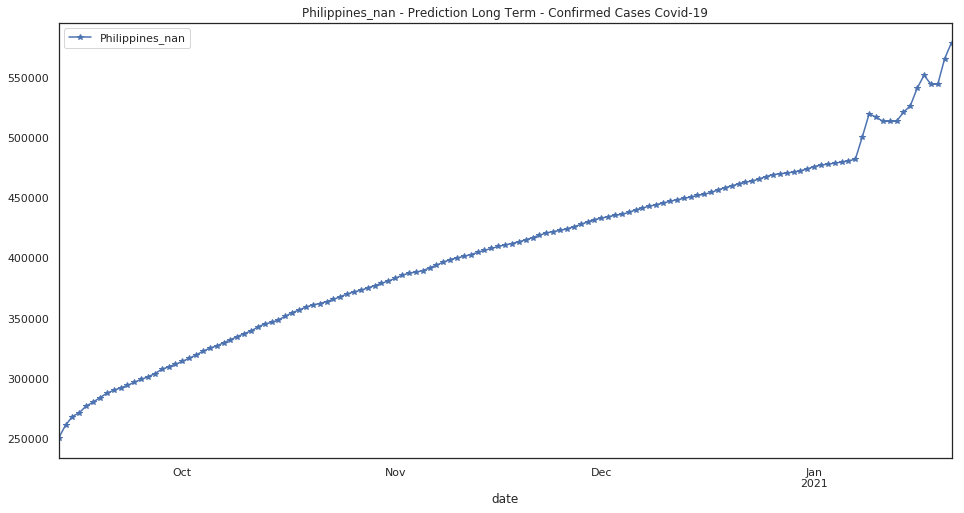

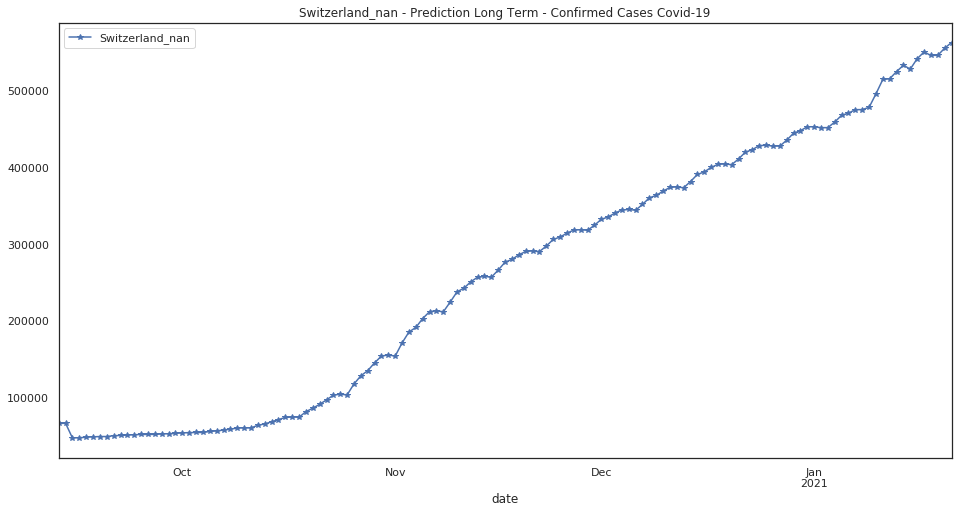

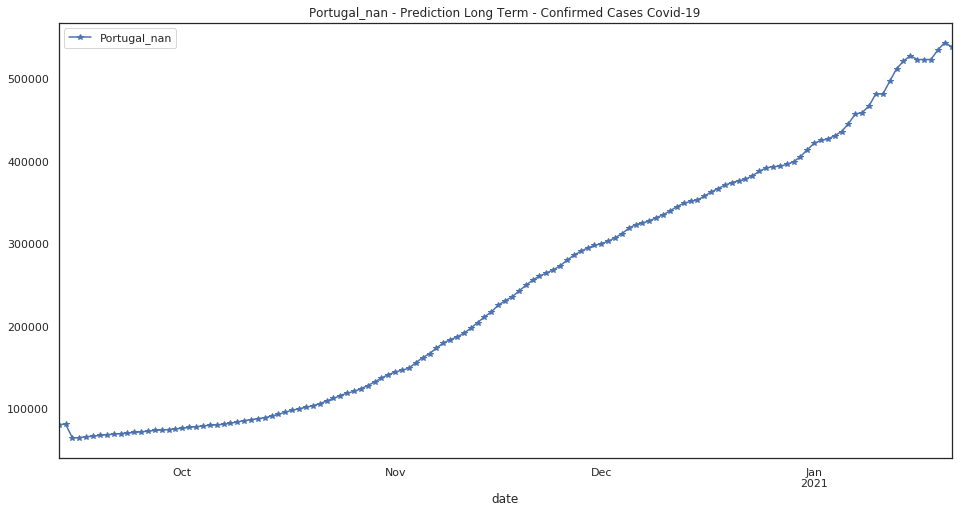

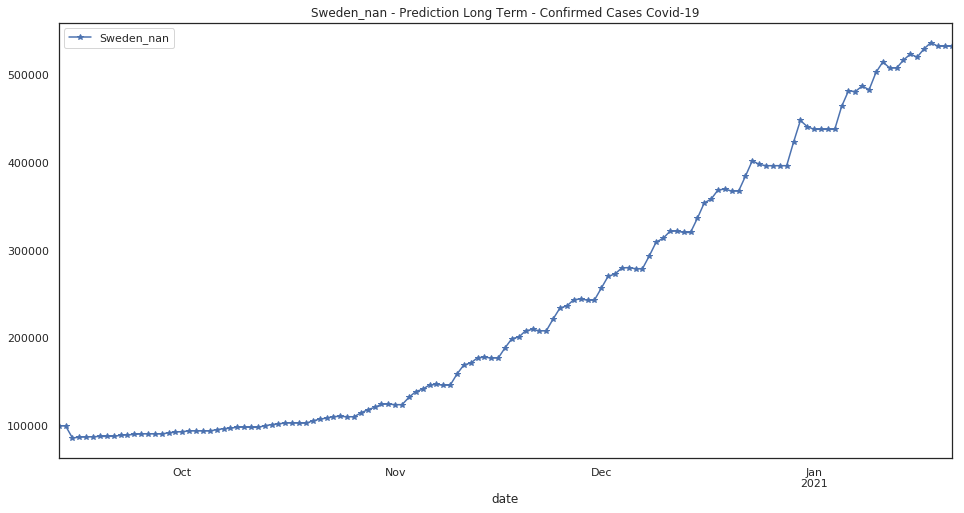

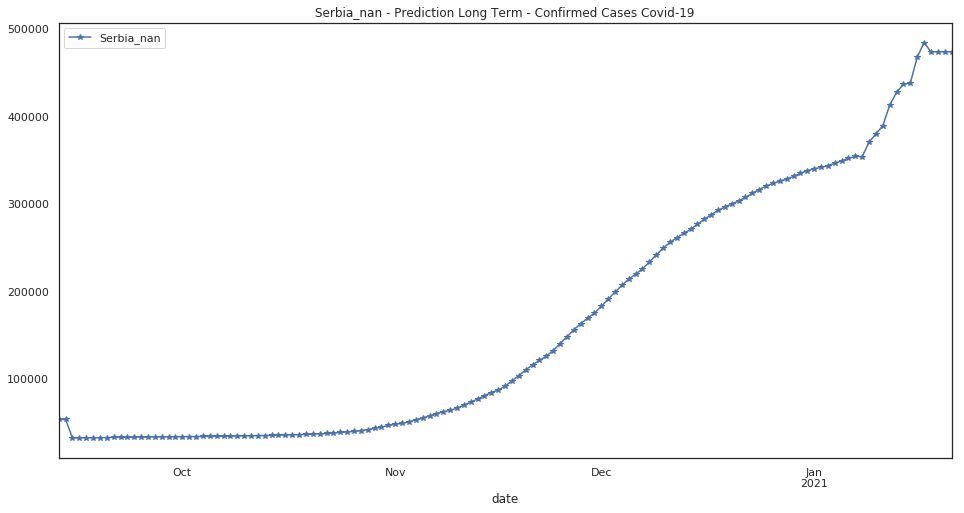

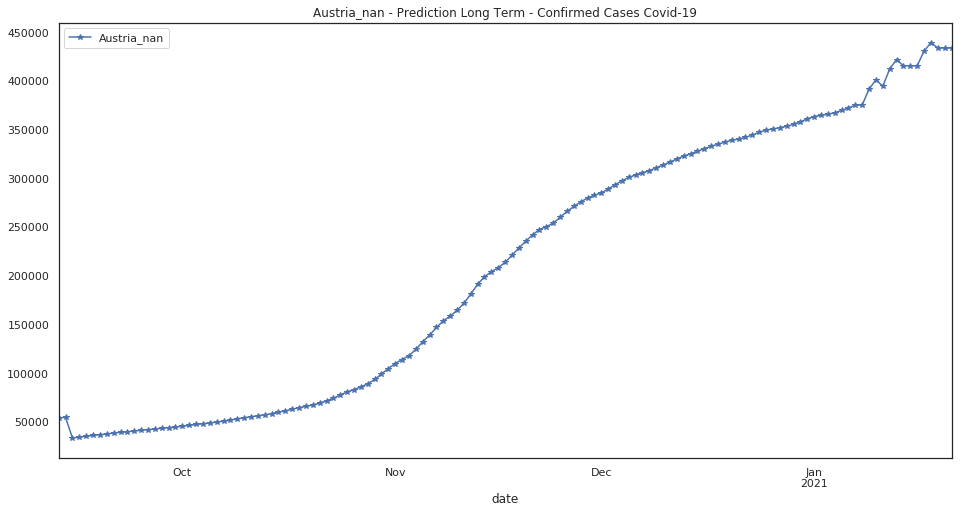

In [77]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

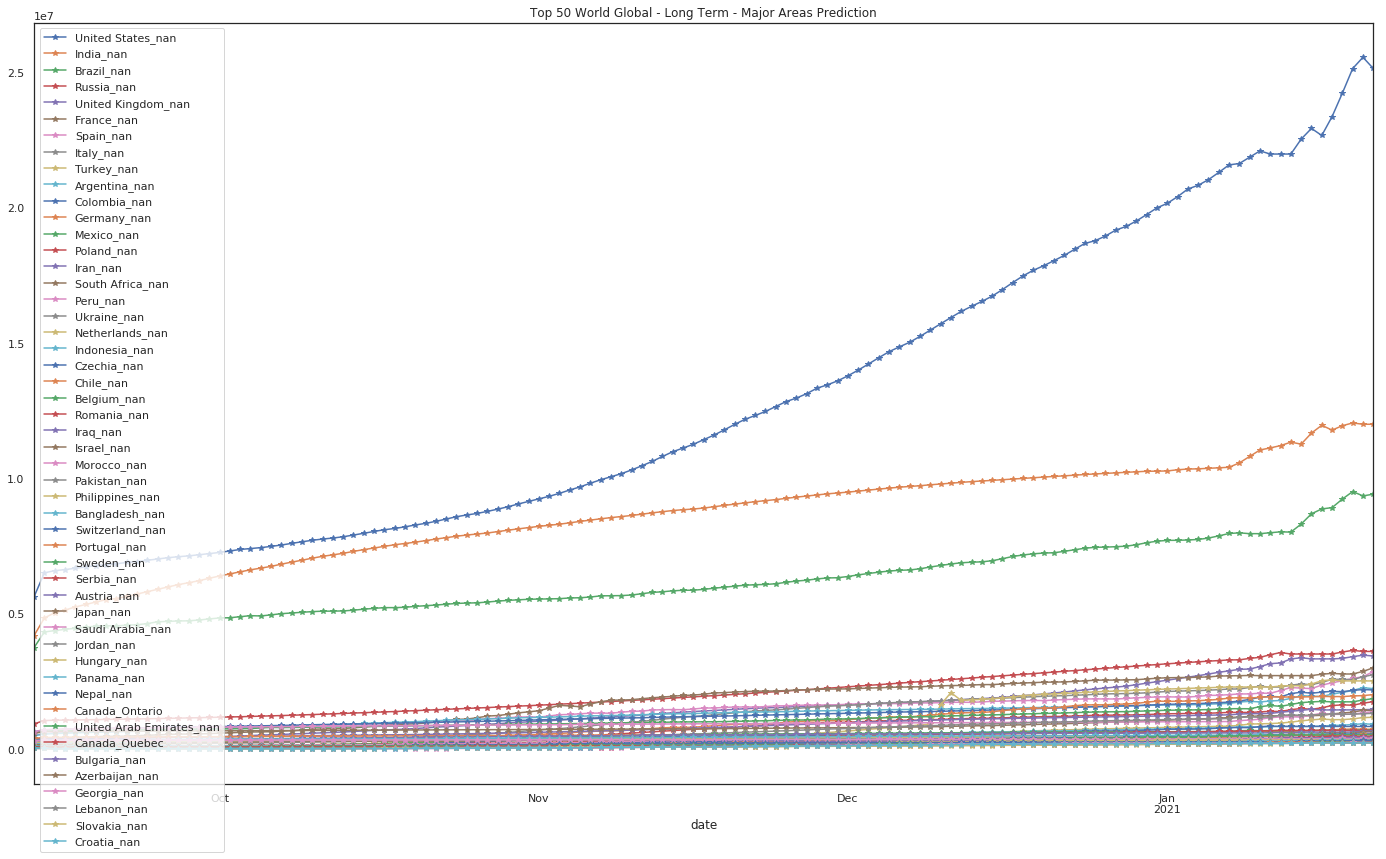

In [78]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

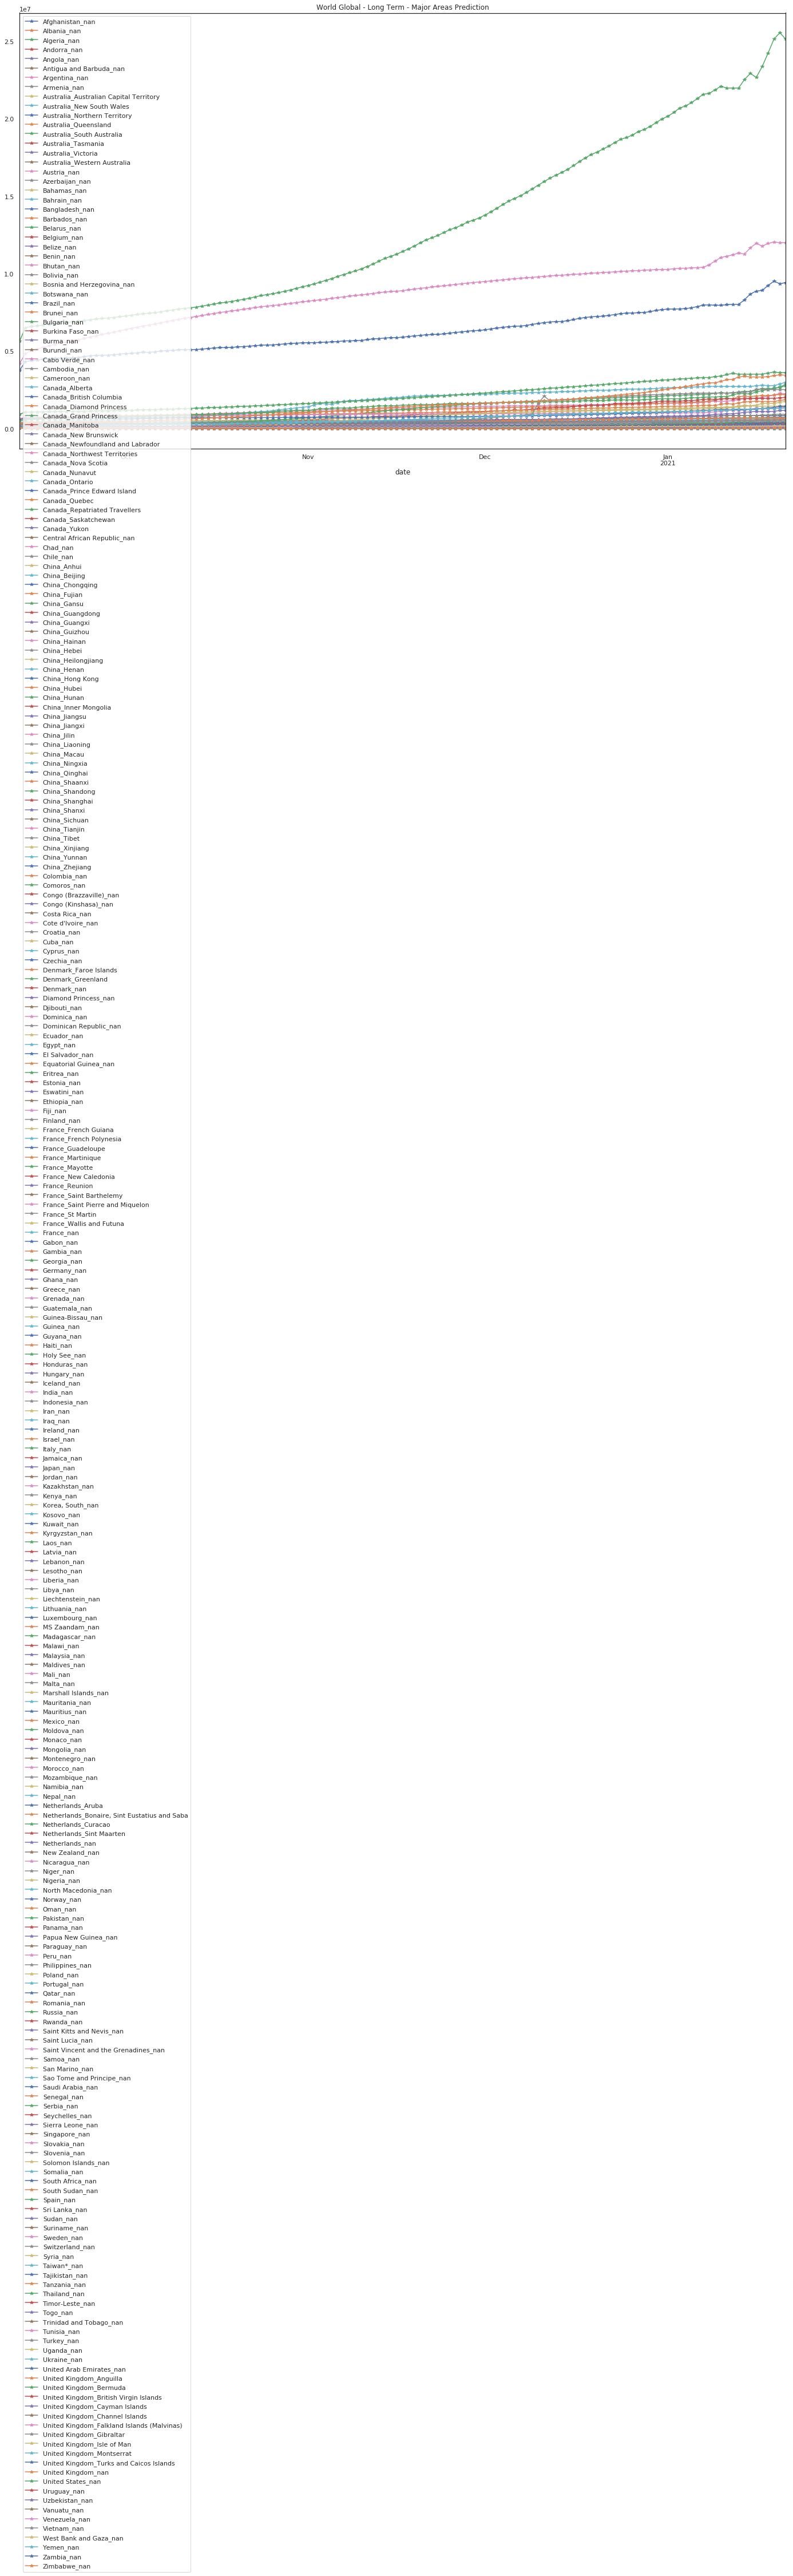

In [79]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [80]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [81]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-10-28          41318.0      20010.0      57155.0       4535.0   
2020-10-29          41440.0      20269.0      57463.0       4517.0   
2020-10-30          41513.0      20619.0      57782.0       4835.0   
2020-10-31          41612.0      20837.0      58077.0       4665.0   
2020-11-01          41682.0      21221.0      58400.0       4770.0   
2020-11-02          41806.0      21473.0      58703.0       4977.0   
2020-11-03          41897.0      21855.0      59093.0       5002.0   
2020-11-04          41993.0      22216.0      59620.0       5307.0   
2020-11-05          42114.0      22634.0      60249.0       5045.0   
2020-11-06          42156.0      23108.0      60888.0       5135.0   
2020-11-07          42227.0      23563.0      61481.0       5712.0   
2020-11-08          42339.0      24074.0      62131.0       5319.0   
2020-11-09          42458.0      24605.0      62765.0       5555.0   
2020-11-10          42625.0      25153.0      63491.0       5667.0   
2020-11-11          42773.0      25653.0      64291.0       5765.0   
2020-11-12          42957.0      26122.0      65137.0       5595.0   
2020-11-13          43126.0      26658.0      66009.0       5885.0   
2020-11-14          43205.0      27130.0      66857.0       5725.0   
2020-11-15          43408.0      27700.0      67709.0       6237.0   
2020-11-16          43601.0      28287.0      68608.0       5872.0   
2020-11-17          43813.0      28983.0      69592.0       6165.0   
2020-11-18          44064.0      29663.0      70630.0       6263.0   
2020-11-19          44310.0      30447.0      71661.0       6159.0   
2020-11-20          44503.0      31257.0      72756.0       6316.0   
2020-11-21          44660.0      32001.0      73790.0       6280.0   
2020-11-22          44853.0      32645.0      74860.0       6383.0   
2020-11-23          45109.0      33472.0      75877.0       6494.0   
2020-11-24          45299.0      34122.0      76981.0       6538.0   
2020-11-25          45528.0      34810.0      78034.0       6611.0   
2020-11-26          45741.0      35520.0      79103.0       6606.0   
...                     ...          ...          ...          ...   
2020-12-23          50579.0      54380.0      96680.0       7927.0   
2020-12-24          50802.0      54889.0      97153.0       7947.0   
2020-12-25          50971.0      55454.0      97586.0       8022.0   
2020-12-26          51068.0      55864.0      98003.0       7995.0   
2020-12-27          51207.0      56358.0      98392.0       8043.0   
2020-12-28          51422.0      56692.0      98770.0       8198.0   
2020-12-29          51510.0      57232.0      99130.0       8123.0   
2020-12-30          51590.0      57803.0      99453.0       8215.0   
2020-12-31          51704.0      58395.0      99754.0       8234.0   
2021-01-01          51710.0      58493.0     100042.0       8302.0   
2021-01-02          51724.0      59087.0     100309.0       8356.0   
2021-01-03          51724.0      59530.0     100560.0       8441.0   
2021-01-04          53000.0      59756.0     100801.0       8553.0   
2021-01-05          53181.0      60378.0     101032.0       8518.0   
2021-01-06          53348.0      61074.0     101279.0       8560.0   
2021-01-07          53447.0      61787.0     101546.0       8625.0   
2021-01-08          53357.0      64715.0     102924.0       8726.0   
2021-01-09          55877.0      65157.0     103357.0       8711.0   
2021-01-10          56131.0      65587.0     103369.0       8700.0   
2021-01-11          56354.0      65637.0     103460.0       8860.0   
2021-01-12          57558.0      66356.0     103340.0       8534.0   
2021-01-13          57501.0      66563.0     108274.0       8934.0   
2021-01-14          57582.0      67113.0     110896.0       9262.0   
2021-01-15          57586.0      67255.0     110289.0       8917.0   
2021-01-16

In [82]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [83]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [84]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [85]:
heatmap_m[:]

region        Lat        Long  \
0                               Afghanistan_nan  33.939110   67.709953   
1                                   Albania_nan  41.153300   20.168300   
2                                   Algeria_nan  28.033900    1.659600   
3                                   Andorra_nan  42.506300    1.521800   
4                                    Angola_nan -11.202700   17.873900   
5                       Antigua and Barbuda_nan  17.060800  -61.796400   
6                                 Argentina_nan -38.416100  -63.616700   
7                                   Armenia_nan  40.069100   45.038200   
8        Australia_Australian Capital Territory -35.473500  149.012400   
9                     Australia_New South Wales -33.868800  151.209300   
10                 Australia_Northern Territory -12.463400  130.845600   
11                         Australia_Queensland -27.469800  153.025100   
12                    Australia_South Australia -34.928500  138.600700   
13                           Australia_Tasmania -42.882100  147.327200   
14                           Australia_Victoria -37.813600  144.963100   
15                  Australia_Western Australia -31.950500  115.860500   
16                                  Austria_nan  47.516200   14.550100   
17                               Azerbaijan_nan  40.143100   47.576900   
18                                  Bahamas_nan  25.025885  -78.035889   
19                                  Bahrain_nan  26.027500   50.550000   
20                               Bangladesh_nan  23.685000   90.356300   
21                                 Barbados_nan  13.193900  -59.543200   
22                                  Belarus_nan  53.709800   27.953400   
23                                  Belgium_nan  50.833300    4.469936   
24                                   Belize_nan  17.189900  -88.497600   
25                                    Benin_nan   9.307700    2.315800   
26                                   Bhutan_nan  27.514200   90.433600   
27                                  Bolivia_nan -16.290200  -63.588700   
28                   Bosnia and Herzegovina_nan  43.915900   17.679100   
29                                 Botswana_nan -22.328500   24.684900   
..                                          ...        ...         ...   
248                                Thailand_nan  15.870032  100.992541   
249                             Timor-Leste_nan  -8.874217  125.727539   
250                                    Togo_nan   8.619500    0.824800   
251                     Trinidad and Tobago_nan  10.691800  -61.222500   
252                                 Tunisia_nan  33.886917    9.537499   
253                                  Turkey_nan  38.963700   35.243300   
254                           United States_nan  40.000000 -100.000000   
255                                  Uganda_nan   1.373333   32.290275   
256                                 Ukraine_nan  48.379400   31.165600   
257                    United Arab Emirates_nan  23.424076   53.847818   
258                     United Kingdom_Anguilla  18.220600  -63.068600   
259                      United Kingdom_Bermuda  32.307800  -64.750500   
260       United Kingdom_British Virgin Islands  18.420700  -64.640000   
261               United Kingdom_Cayman Islands  19.313300  -81.254600   
262              United Kingdom_Channel Islands  49.372300   -2.364400   
263  United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
264                    United Kingdom_Gibraltar  36.140800   -5.353600   
265                  United Kingdom_Isle of Man  54.236100   -4.548100   
266                   United Kingdom_Montserrat  16.742498  -62.187366   
267     United Kingdom_Turks and Caicos Islands  21.694000  -71.797900   
268                          United Kingdom_nan  55.378100   -3.436000   
269                                 Uruguay_nan -32.522800  -55.765800   
270                              Uzbekistan_n

In [86]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat,lng,num,totpred,ldaygrowth in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]],  (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg ):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred))+' 1DayChangePred='+str(round(ldaygrowth))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

ValueError: Location values cannot contain NaNs.

In [87]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                    region        Lat        Long  \
0       6             Argentina_nan -38.416100  -63.616700   
1      16               Austria_nan  47.516200   14.550100   
2      17            Azerbaijan_nan  40.143100   47.576900   
3      20            Bangladesh_nan  23.685000   90.356300   
4      23               Belgium_nan  50.833300    4.469936   
5      30                Brazil_nan -14.235000  -51.925300   
6      32              Bulgaria_nan  42.733900   25.485800   
7      51            Canada_Ontario  51.253800  -85.323200   
8      53             Canada_Quebec  52.939900  -73.549100   
9      59                 Chile_nan -35.675100  -71.543000   
10     93              Colombia_nan   4.570900  -74.297300   
11     97            Costa Rica_nan   9.748900  -83.753400   
12    102               Czechia_nan  49.817500   15.473000   
13    131                France_nan  46.227600    2.213700   
14    134               Georgia_nan  42.315400   43.356900   
15    135               Georgia_nan  42.315400   43.356900   
16    136               Germany_nan  51.165691   10.451526   
17    148               Hungary_nan  47.162500   19.503300   
18    150                 India_nan  20.593684   78.962880   
19    151             Indonesia_nan  -0.789300  113.921300   
20    152                  Iran_nan  32.427908   53.688046   
21    153                  Iraq_nan  33.223191   43.679291   
22    155                Israel_nan  31.046051   34.851612   
23    156                Israel_nan  31.046051   34.851612   
24    157                 Italy_nan  41.871940   12.567380   
25    159                 Japan_nan  36.204824  138.252924   
26    160                Jordan_nan  31.240000   36.510000   
27    169               Lebanon_nan  33.854700   35.862300   
28    170               Lebanon_nan  33.854700   35.862300   
29    187                Mexico_nan  23.634500 -102.552800   
30    192               Morocco_nan  31.791700   -7.092600   
31    195                 Nepal_nan  28.166700   84.250000   
32    200           Netherlands_nan  52.132600    5.291300   
33    208              Pakistan_nan  30.375300   69.345100   
34    209                Panama_nan   8.538000  -80.782100   
35    212                  Peru_nan  -9.190000  -75.015200   
36    213           Philippines_nan  12.879721  121.774017   
37    214                Poland_nan  51.919400   19.145100   
38    215              Portugal_nan  39.399900   -8.224500   
39    217               Romania_nan  45.943200   24.966800   
40    218                Russia_nan  61.524010  105.318756   
41    226          Saudi Arabia_nan  23.885942   45.079162   
42    228                Serbia_nan  44.016500   21.005900   
43    232              Slovakia_nan  48.669000   19.699000   
44    236          South Africa_nan -30.559500   22.937500   
45    238                 Spain_nan  40.463667   -3.749220   
46    242                Sweden_nan  60.128161   18.643501   
47    243           Switzerland_nan  46.818200    8.227500   
48    253                Turkey_nan  38.963700   35.243300   
49    254         United States_nan  40.000000 -100.000000   
50    256               Ukraine_nan  48.379400   31.165600   
51    257  United Arab Emirates_nan  23.424076   53.847818   
52    268        United Kingdom_nan  55.378100   -3.436000   

    2020-09-13 00:00:00  2020-09-14 00:00:00  2020-09-15 00:00:00  \
0              503875.0             555537.0             577353.0   
1               54271.0              54600.0              33541.0   
2               58719.0              58784.0              38403.0   
3              316230.0             337520.0             339352.0   
4              106167.0             106899.0              94306.0   
5             3752896.0            4330455.0            4380818.0   
6               41153.0              41276.0              18061.0   
7               65740.0              66102.0              46905.0   
8               81664.0           

In [88]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat2,lng2,num2,totpred2,ldaygrowth2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg ):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred2))+' 1DayChangePred='+str(round(ldaygrowth2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [89]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [90]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [91]:
exit()